<a href="https://colab.research.google.com/github/savindu29/NeuralNet/blob/main/cnn_lstm_with_xai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install torch-summary

In [2]:
# Standard Library
import os

# Data Processing & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning & Evaluation
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix

# PyTorch - Core
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

# PyTorch - Data Utilities
from torch.utils.data import (
    DataLoader,
    TensorDataset,
    Subset,
    SubsetRandomSampler,
    random_split
)
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Model Summary
from torchsummary import summary


In [4]:

# Mount Google Drive (only for Colab users)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Define paths to saved data
root_save_path = "/content/drive/MyDrive/preprocessed_Data"
numpy_save_path = os.path.join(root_save_path, "numpy_data")
torch_save_path = os.path.join(root_save_path, "torch_data")

In [6]:
# Load NumPy arrays
X_train = np.load(os.path.join(numpy_save_path, "X_train.npy"))
X_test = np.load(os.path.join(numpy_save_path, "X_test.npy"))
y_train = np.load(os.path.join(numpy_save_path, "y_train.npy"))
y_test = np.load(os.path.join(numpy_save_path, "y_test.npy"))

In [7]:
# Load PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.load(os.path.join(torch_save_path, "X_train.pt"), map_location=device)
X_test_tensor = torch.load(os.path.join(torch_save_path, "X_test.pt"), map_location=device)
y_train_tensor = torch.load(os.path.join(torch_save_path, "y_train.pt"), map_location=device)
y_test_tensor = torch.load(os.path.join(torch_save_path, "y_test.pt"), map_location=device)


In [8]:
# Print shapes to verify
print("NumPy arrays:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

NumPy arrays:
X_train shape: (4147, 22, 1001)
X_test shape: (1037, 22, 1001)
y_train shape: (4147,)
y_test shape: (1037,)


In [9]:
print("\nPyTorch tensors:")
print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"X_test_tensor shape: {X_test_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")
print(f"y_test_tensor shape: {y_test_tensor.shape}")


PyTorch tensors:
X_train_tensor shape: torch.Size([4147, 1, 22, 1001])
X_test_tensor shape: torch.Size([1037, 1, 22, 1001])
y_train_tensor shape: torch.Size([4147])
y_test_tensor shape: torch.Size([1037])


In [10]:
train_size = int(0.85 * len(X_train_tensor))
val_size = len(X_train_tensor) - train_size

In [11]:
# Create datasets
train_dataset = TensorDataset(X_train_tensor[:train_size], y_train_tensor[:train_size])
val_dataset = TensorDataset(X_train_tensor[train_size:], y_train_tensor[train_size:])
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 3524
Validation samples: 623
Test samples: 1037


In [12]:
class TrainModel():
    def __init__(self, patience=10):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.train_loss = []  # To store training loss for plotting
        self.train_accuracy = []  # To store training accuracy for plotting
        self.val_loss = []  # To store validation loss for plotting
        self.val_accuracy = []  # To store validation accuracy for plotting

    def train_model(self, model, train_dataset, validation_dataset=None, learning_rate=0.001, batch_size=64, epochs=500):
        # Send the model to the device (GPU or CPU)
        model = model.to(self.device)

        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Initialize the ReduceLROnPlateau scheduler
        scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5, verbose=True)

        # Create DataLoader for training data
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Track highest accuracy and patience for Early Stopping
        highest_train_accuracy = 0.0
        best_epoch = 0
        early_stopping_counter = 0

        for epoch in range(epochs):
            model.train()  # Set the model to training mode
            running_loss = 0.0
            correct = 0
            total = 0

            # Training loop
            for inputs, labels in train_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                optimizer.zero_grad()  # Zero the gradients

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                # Track running loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            # Calculate epoch loss and accuracy
            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_accuracy = correct / total

            # Update the learning rate scheduler based on training loss
            scheduler.step(epoch_loss)  # Reduce learning rate if loss doesn't improve

            # Collect the data for plotting
            self.train_loss.append(epoch_loss)
            self.train_accuracy.append(epoch_accuracy)

            # Validation step
            if validation_dataset is not None:
                val_loss, val_accuracy = self.validate_model(model, validation_dataset, criterion)
                self.val_loss.append(val_loss)
                self.val_accuracy.append(val_accuracy)

                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {(epoch_accuracy*100):.2f}%, "
                      f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy*100:.2f}%")
            else:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {(epoch_accuracy*100):.2f}%")

            # Early stopping
            if epoch_accuracy > highest_train_accuracy:
                highest_train_accuracy = epoch_accuracy
                best_epoch = epoch
            #     early_stopping_counter = 0  # Reset the early stopping counter
            # else:
            #     early_stopping_counter += 1  # Increment the counter if no improvement

            # # Check for early stopping
            # if early_stopping_counter >= self.patience:
            #     print("Early stopping triggered")
            #     break

        # Calculate the average training loss over all epochs
        average_loss = running_loss / len(train_loader.dataset)
        print("Average Loss:", average_loss)
        print("Highest Train Accuracy:", highest_train_accuracy)

        # Saving the trained model
        torch.save(model.state_dict(), 'trained_model.pth')

        # Plotting the results
        self.plot_results()

        return model

    def validate_model(self, model, validation_dataset, criterion):
        """Validation step to monitor the validation performance."""
        model.eval()  # Set the model to evaluation mode
        val_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)

        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():  # No need to track gradients during validation
            for inputs, labels in val_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        # Calculate validation loss and accuracy
        val_loss = val_loss / len(validation_dataset)
        val_accuracy = correct_val / total_val
        return val_loss, val_accuracy

    def plot_results(self):
        """Plot training and validation loss and accuracy."""
        epochs = len(self.train_loss)

        plt.figure(figsize=(10, 6))

        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(range(epochs), self.train_accuracy, label='accuracy', color='blue')
        plt.plot(range(epochs), self.val_accuracy, label='val_accuracy', color='blue', linestyle='dotted')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy vs Epochs')
        plt.legend()

        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(range(epochs), self.train_loss, label='loss', color='red')
        plt.plot(range(epochs), self.val_loss, label='val_loss', color='red', linestyle='dotted')
        plt.xlabel('Epochs')
        plt.ylabel('Loss (cross-entropy)')
        plt.title('Loss vs Epochs')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [13]:
class EvalModel():
    def __init__(self, model):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)

    def test_model(self, test_dataset):
        self.model.eval()
        correct = 0
        total = 0
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
        y_true = []
        y_pred = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        accuracy = (correct / total) * 100
        print("/------------------------------/")
        print(f"Test Accuracy: {accuracy:.2f}%")
        print("/------------------------------/")

        return accuracy, y_true, y_pred

    def print_classification_report(self, y_true, y_pred, target_names):
        print("Classification Report:\n")
        report = classification_report(y_true, y_pred, target_names=target_names)
        print(report)

    def plot_confusion_matrix(self, y_true, y_pred, classes):
        # Using actual values instead of percentages
        cf_matrix = confusion_matrix(y_true, y_pred)

        # Create a DataFrame for better visualization
        df_cm = pd.DataFrame(cf_matrix, index=classes, columns=classes)

        plt.figure(figsize=(10, 7))
        sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')  # 'fmt='d'' for integers
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix (Actual Values)')
        plt.savefig('confusion_matrix_model.png')
        plt.show()

    def plot_metrics(self, hist):
        # Plot accuracy and loss
        fig, ax = plt.subplots()
        ax.plot(hist['accuracy'], color='b', label='accuracy')
        ax.plot(hist['val_accuracy'], linestyle=':', color='b', label='val_accuracy')
        ax.set_ylabel("Accuracy", color='b')
        ax.set_ylim([0, 1])

        ax2 = ax.twinx()
        ax2.plot(hist['loss'], color='r', label='loss')
        ax2.plot(hist['val_loss'], linestyle=':', color='r', label='val_loss')
        ax2.set_ylabel("Loss (cross-entropy)", color='r')

        fig.legend(loc='best')
        plt.title('Accuracy and Loss over Epochs')
        plt.show()

    def plot_classification_metrics(self, y_true, y_pred, target_names):
        # Classification report and metrics
        report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
        report_df = pd.DataFrame(report).transpose()

        # Plot metrics
        report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 7))
        plt.title('Classification Report Metrics')
        plt.xlabel('Classes')
        plt.ylabel('Scores')
        plt.legend(loc='lower right')
        plt.show()

        # Plot Cohen's Kappa score
        kappa = cohen_kappa_score(y_true, y_pred)
        print(f"Cohen's Kappa: {kappa:.4f}")



In [14]:
class CrossValidator:
    def __init__(self, model_class, dataset, k_folds, train_args, target_names):
        self.model_class = model_class
        self.dataset = dataset
        self.k_folds = k_folds
        self.train_args = train_args
        self.target_names = target_names

    def run(self):
        kf = KFold(n_splits=self.k_folds, shuffle=True, random_state=42)
        fold_accuracies = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(self.dataset)):
            print(f"\n=== Fold {fold + 1}/{self.k_folds} ===")

            train_subset = Subset(self.dataset, train_idx)
            val_subset = Subset(self.dataset, val_idx)

            # Create a fresh model instance
            model = self.model_class().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

            trainer = TrainModel(patience=10)
            trainer.train_model(model, train_subset, validation_dataset=val_subset, **self.train_args)

            evaluator = EvalModel(model)
            acc, y_true, y_pred = evaluator.test_model(val_subset)

            evaluator.print_classification_report(y_true, y_pred, self.target_names)
            evaluator.plot_confusion_matrix(y_true, y_pred, self.target_names)

            fold_accuracies.append(acc)

        print(f"\n✅ Average Accuracy across {self.k_folds} folds: {np.mean(fold_accuracies):.2f}%")


In [15]:
class EEGNetLSTMModel(nn.Module):  # EEGNet with 2D CNN + LSTM
    def __init__(self, chans=22, classes=4, time_points=1001, temp_kernel=32,
                 f1=16, f2=32, d=2, pk1=8, pk2=16, lstm_hidden_size=128,
                 lstm_layers=2, dropout_rate=0.5, max_norm1=1, max_norm2=0.25):
        super(EEGNetLSTMModel, self).__init__()
        # Calculating the number of features after CNN layers for LSTM input
        linear_size = (time_points // (pk1 * pk2)) * f2

        # Temporal Filters
        self.block1 = nn.Sequential(
            nn.Conv2d(1, f1, (1, temp_kernel), padding='same', bias=False),
            nn.BatchNorm2d(f1),
        )

        # Spatial Filters
        self.block2 = nn.Sequential(
            nn.Conv2d(f1, d * f1, (chans, 1), groups=f1, bias=False),  # Depthwise Conv
            nn.BatchNorm2d(d * f1),
            nn.ELU(),
            nn.AvgPool2d((1, pk1)),
            nn.Dropout(dropout_rate)
        )

        # Separable and Pointwise Convolutions
        self.block3 = nn.Sequential(
            nn.Conv2d(d * f1, f2, (1, 16), groups=f2, bias=False, padding='same'),  # Separable Conv
            nn.Conv2d(f2, f2, kernel_size=1, bias=False),  # Pointwise Conv
            nn.BatchNorm2d(f2),
            nn.ELU(),
            nn.AvgPool2d((1, pk2)),
            nn.Dropout(dropout_rate)
        )

        # Flatten and reshape to feed into LSTM
        self.flatten = nn.Flatten()

        # LSTM for temporal context learning
        self.lstm = nn.LSTM(input_size=linear_size, hidden_size=lstm_hidden_size, num_layers=lstm_layers,
                            batch_first=True, dropout=dropout_rate, bidirectional=True)

        # Fully connected layer
        self.fc = nn.Linear(2 * lstm_hidden_size, classes)  # Bidirectional LSTM doubles hidden size

        # Apply max_norm constraint to the depthwise layer in block2
        self._apply_max_norm(self.block2[0], max_norm1)

        # Apply max_norm constraint to the linear layer
        self._apply_max_norm(self.fc, max_norm2)

    def _apply_max_norm(self, layer, max_norm):
        for name, param in layer.named_parameters():
            if 'weight' in name:
                param.data = torch.renorm(param.data, p=2, dim=0, maxnorm=max_norm)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.flatten(x)

        # Reshape for LSTM input: (batch_size, sequence_length, features)
        batch_size = x.size(0)
        x = x.view(batch_size, -1, x.size(1))

        # Pass through LSTM
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Take the output of the last time step

        # Final classification
        x = self.fc(lstm_out)
        return x

In [16]:
# Model Parameters
chans = 22
classes = 4
time_points = 1001
f1 = 32         # Reduced filters
f2 = 64         # Reduced filters
lstm_hidden_size = 64  # Reduced hidden size
dropout_rate = 0.5     # Increased dropout
temp_kernel = 16       # Smaller kernel



In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the improved model
improved_model = EEGNetLSTMModel(
    chans=chans,
    classes=classes,
    time_points=time_points,
    temp_kernel=temp_kernel,
    lstm_hidden_size=lstm_hidden_size,
    f1=f1,
    f2=f2,
    dropout_rate=dropout_rate
).to(device)

# Display the summary of the model
print("\nImproved Model Architecture:")
summary(improved_model, input_size=(1, chans, time_points))


Improved Model Architecture:
Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       512
|    └─BatchNorm2d: 2-2                  64
├─Sequential: 1-2                        --
|    └─Conv2d: 2-3                       1,408
|    └─BatchNorm2d: 2-4                  128
|    └─ELU: 2-5                          --
|    └─AvgPool2d: 2-6                    --
|    └─Dropout: 2-7                      --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-8                       1,024
|    └─Conv2d: 2-9                       4,096
|    └─BatchNorm2d: 2-10                 128
|    └─ELU: 2-11                         --
|    └─AvgPool2d: 2-12                   --
|    └─Dropout: 2-13                     --
├─Flatten: 1-4                           --
├─LSTM: 1-5                              987,136
├─Linear: 1-6                            1,028
Total params: 995,524
Trainable params: 995,524
Non-trainable par

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       512
|    └─BatchNorm2d: 2-2                  64
├─Sequential: 1-2                        --
|    └─Conv2d: 2-3                       1,408
|    └─BatchNorm2d: 2-4                  128
|    └─ELU: 2-5                          --
|    └─AvgPool2d: 2-6                    --
|    └─Dropout: 2-7                      --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-8                       1,024
|    └─Conv2d: 2-9                       4,096
|    └─BatchNorm2d: 2-10                 128
|    └─ELU: 2-11                         --
|    └─AvgPool2d: 2-12                   --
|    └─Dropout: 2-13                     --
├─Flatten: 1-4                           --
├─LSTM: 1-5                              987,136
├─Linear: 1-6                            1,028
Total params: 995,524
Trainable params: 995,524
Non-trainable params: 0

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv2d(


Epoch 1/300, Train Loss: 1.3783, Train Accuracy: 27.84%, Validation Loss: 1.3536, Validation Accuracy: 30.34%
Epoch 2/300, Train Loss: 1.3344, Train Accuracy: 33.03%, Validation Loss: 1.3047, Validation Accuracy: 40.13%
Epoch 3/300, Train Loss: 1.2860, Train Accuracy: 38.65%, Validation Loss: 1.2289, Validation Accuracy: 43.34%
Epoch 4/300, Train Loss: 1.2380, Train Accuracy: 41.03%, Validation Loss: 1.1793, Validation Accuracy: 49.60%
Epoch 5/300, Train Loss: 1.2027, Train Accuracy: 43.87%, Validation Loss: 1.1522, Validation Accuracy: 49.92%
Epoch 6/300, Train Loss: 1.1817, Train Accuracy: 44.69%, Validation Loss: 1.1386, Validation Accuracy: 50.08%
Epoch 7/300, Train Loss: 1.1515, Train Accuracy: 47.05%, Validation Loss: 1.1263, Validation Accuracy: 51.04%
Epoch 8/300, Train Loss: 1.1406, Train Accuracy: 47.28%, Validation Loss: 1.1102, Validation Accuracy: 51.52%
Epoch 9/300, Train Loss: 1.1162, Train Accuracy: 47.70%, Validation Loss: 1.0876, Validation Accuracy: 51.69%
Epoch 10/3

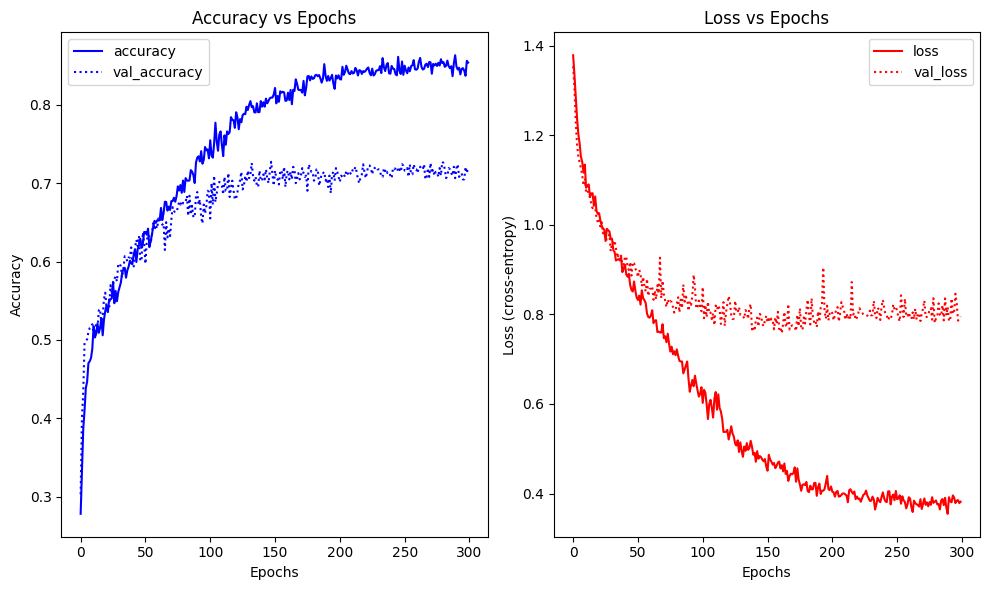

In [18]:
# Training Hyperparameters
EPOCHS = 300
BATCH_SIZE = 64  # Smaller batch size
LEARNING_RATE = 0.001  # Lower learning rate

# Initialize trainer with increased patience
trainer = TrainModel(patience=50)

# Train the model with improved hyperparameters
trained_model = trainer.train_model(
    improved_model,
    train_dataset,
    validation_dataset=val_dataset,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
)

In [19]:
torch.save(trained_model.state_dict(), 'cnn_lstm_model.pth')


In [20]:
classes_list = ['Left', 'Right', 'Foot', 'Tongue']
eval_model = EvalModel(trained_model)

In [21]:
# Testing the model
accuracy, y_true, y_pred = eval_model.test_model(test_dataset)

/------------------------------/
Test Accuracy: 72.61%
/------------------------------/


In [22]:

# Classification report
eval_model.print_classification_report(y_true, y_pred, classes_list)

Classification Report:

              precision    recall  f1-score   support

        Left       0.76      0.70      0.73       259
       Right       0.72      0.83      0.77       259
        Foot       0.71      0.64      0.68       260
      Tongue       0.71      0.73      0.72       259

    accuracy                           0.73      1037
   macro avg       0.73      0.73      0.72      1037
weighted avg       0.73      0.73      0.72      1037



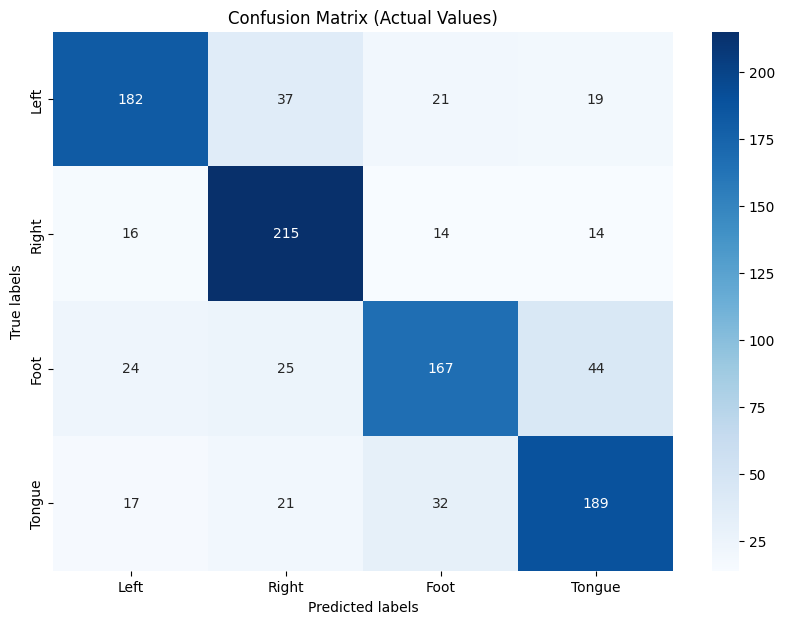

In [23]:

# Plot confusion matrix
eval_model.plot_confusion_matrix(y_true, y_pred, classes_list)

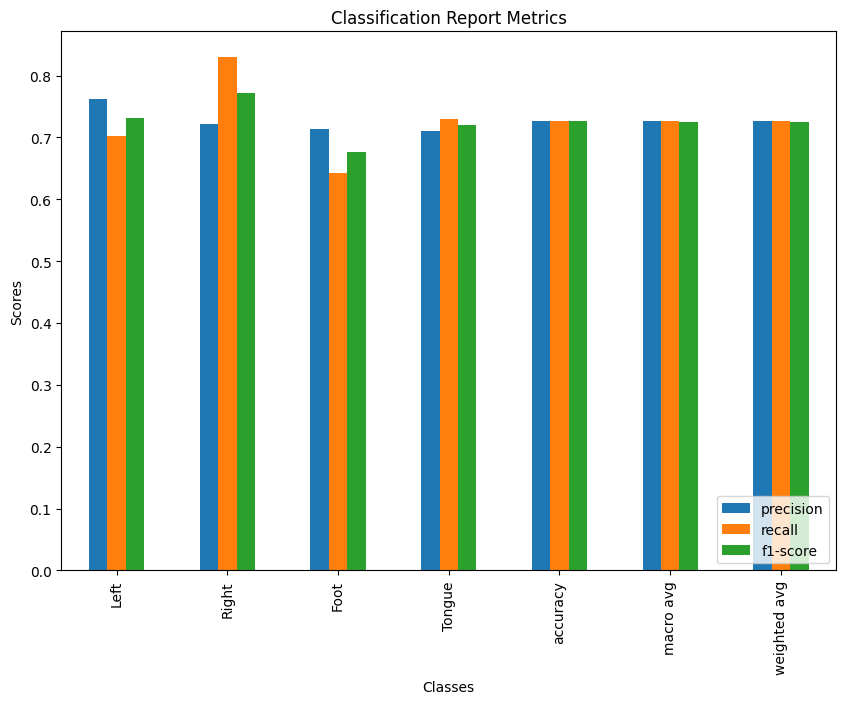

Cohen's Kappa: 0.6349


In [24]:
# Plot classification metrics like precision, recall, and f1-score
eval_model.plot_classification_metrics(y_true, y_pred, classes_list)

In [25]:
!pip install captum mne seaborn scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from captum.attr import (
    IntegratedGradients,
    Occlusion,
    GradientShap,
    DeepLift,
    LayerGradCam,
    visualization as viz
)
from captum.attr import NoiseTunnel
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torchvision.transforms import Normalize
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from mne.viz import plot_topomap
import mne
import pandas as pd
import os
from torch.utils.data import DataLoader

In [ ]:
class EEGExplainer:
    def __init__(self, model, device, class_names=None):
        """
        Initialize the EEG explainer with a trained model

        Args:
            model: Trained PyTorch model
            device: Device to run computations on (CPU or CUDA)
            class_names: Names of the classes for plotting
        """
        self.model = model
        self.device = device
        self.model.to(self.device)
        self.model.eval()

        # Default class names if not provided
        self.class_names = class_names if class_names else [f"Class {i}" for i in range(4)]

        # EEG channel names (standard 10-20 system for 22 channels)
        self.channel_names = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                             'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz', 'A1', 'A2', 'Oz']

        # Standard 10-20 positions for visualization
        self.channel_positions = np.array([
            [-0.3, 0.9], [0.3, 0.9],    # Fp1, Fp2
            [-0.5, 0.5], [0.5, 0.5],    # F3, F4
            [-0.5, 0], [0.5, 0],        # C3, C4
            [-0.5, -0.5], [0.5, -0.5],  # P3, P4
            [-0.3, -0.9], [0.3, -0.9],  # O1, O2
            [-0.8, 0.5], [0.8, 0.5],    # F7, F8
            [-0.8, 0], [0.8, 0],        # T3, T4
            [-0.8, -0.5], [0.8, -0.5],  # T5, T6
            [0, 0.5],                   # Fz
            [0, 0],                     # Cz
            [0, -0.5],                  # Pz
            [-0.9, -0.2], [0.9, -0.2],  # A1, A2
            [0, -0.9]                   # Oz
        ])

    def predict_sample(self, input_tensor):
        """Make a prediction for a single sample"""
        with torch.no_grad():
            input_tensor = input_tensor.to(self.device)
            output = self.model(input_tensor)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            predicted_class = torch.argmax(probabilities, dim=1).item()
            confidence = probabilities[0, predicted_class].item()

        return {
            "class_idx": predicted_class,
            "class_name": self.class_names[predicted_class],
            "confidence": confidence,
            "probabilities": probabilities.cpu().numpy()[0]
        }

    def evaluate_model(self, test_dataset, batch_size=64):
        """Evaluate the model on test data and generate performance metrics"""
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        y_true = []
        y_pred = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        # Generate confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=self.class_names,
                    yticklabels=self.class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

        # Classification report
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=self.class_names))

        return {
            "confusion_matrix": cm,
            "classification_report": classification_report(y_true, y_pred, target_names=self.class_names, output_dict=True)
        }

    def integrated_gradients(self, input_tensor, target_class=None, n_steps=50):
        """Apply Integrated Gradients to explain model predictions"""
        # Initialize integrated gradients
        ig = IntegratedGradients(self.model)

        # Create a baseline (zeros tensor with same shape as input)
        baseline = torch.zeros_like(input_tensor).to(self.device)

        # Set target class
        if target_class is None:
            prediction = self.predict_sample(input_tensor)
            target_class = prediction["class_idx"]

        # Temporarily set to training mode for backward pass
        was_training = self.model.training
        self.model.train()

        # Calculate attributions
        input_tensor = input_tensor.to(self.device)
        attributions = ig.attribute(input_tensor, baseline, target=target_class, n_steps=n_steps)

        # Restore original model state
        self.model.train(was_training)

        return attributions

    def deep_lift(self, input_tensor, target_class=None):
        """Apply DeepLift to explain model predictions"""
        # Initialize DeepLift
        dl = DeepLift(self.model)

        # Create a baseline (zeros tensor with same shape as input)
        baseline = torch.zeros_like(input_tensor).to(self.device)

        # Set target class
        if target_class is None:
            prediction = self.predict_sample(input_tensor)
            target_class = prediction["class_idx"]

        # Save original training state
        was_training = self.model.training

        # Temporarily set model to training mode for backward pass
        self.model.train()

        # Calculate attributions
        input_tensor = input_tensor.to(self.device)
        attributions = dl.attribute(input_tensor, baseline, target=target_class)

        # Restore original model state
        self.model.train(was_training)

        return attributions

    def gradient_shap(self, input_tensor, target_class=None, n_samples=50):
        """Apply GradientSHAP to explain model predictions"""
        # Initialize GradientSHAP
        gs = GradientShap(self.model)

        # Create multiple random baselines
        input_shape = input_tensor.shape
        baselines = torch.randn(n_samples, *input_shape[1:]) * 0.001
        baselines = baselines.to(self.device)

        # Set target class
        if target_class is None:
            prediction = self.predict_sample(input_tensor)
            target_class = prediction["class_idx"]

        # Calculate attributions
        input_tensor = input_tensor.to(self.device)
        attributions = gs.attribute(input_tensor, baselines, target=target_class)

        return attributions

    def occlusion_analysis(self, input_tensor, target_class=None, sliding_window_shapes=(1, 1, 50),
                          strides=(1, 1, 10)):
        """Apply Occlusion to identify important regions in the input"""
        # Initialize Occlusion
        occlusion = Occlusion(self.model)

        # Set target class
        if target_class is None:
            prediction = self.predict_sample(input_tensor)
            target_class = prediction["class_idx"]

        # Calculate attributions
        input_tensor = input_tensor.to(self.device)
        attributions = occlusion.attribute(input_tensor,
                                           strides=strides,
                                           target=target_class,
                                           sliding_window_shapes=sliding_window_shapes,
                                           baselines=0)

        return attributions

    def plot_attributions_over_time(self, attributions, channel_idx=None, title="Channel Attribution Over Time"):
        """Plot attributions over time for specific channels or averaged across channels"""
        # Convert attributions tensor to numpy array
        attr_np = attributions.squeeze().detach().cpu().numpy()  # Shape: [channels, time]

        plt.figure(figsize=(15, 8))

        if channel_idx is None:
            # Average across all channels
            avg_attr = np.mean(attr_np, axis=0)
            plt.plot(avg_attr)
            plt.title(f"{title} (Averaged across all channels)")
            plt.xlabel("Time Points")
            plt.ylabel("Attribution Value")
        else:
            # Plot specific channels
            if not isinstance(channel_idx, list):
                channel_idx = [channel_idx]

            for idx in channel_idx:
                plt.plot(attr_np[idx], label=f"Channel {self.channel_names[idx]}")

            plt.title(title)
            plt.xlabel("Time Points")
            plt.ylabel("Attribution Value")
            plt.legend()

        plt.grid(True)
        plt.show()

    def plot_channel_importance(self, attributions, title="Channel Importance"):
        """Plot overall importance of each EEG channel"""
        # Convert attributions tensor to numpy array
        attr_np = attributions.squeeze().detach().cpu().numpy()  # Shape: [channels, time]

        # Calculate the importance of each channel (mean of absolute values)
        channel_importance = np.mean(np.abs(attr_np), axis=1)

        plt.figure(figsize=(12, 6))
        plt.bar(self.channel_names, channel_importance)
        plt.title(title)
        plt.xlabel("EEG Channels")
        plt.ylabel("Importance Score")
        plt.xticks(rotation=45)
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.show()

        return channel_importance

    def plot_topomap_attribution(self, attributions, title="EEG Channel Attribution Topomap"):
        """Plot a topographic map of channel attributions using matplotlib only"""
        # Convert attributions tensor to numpy array
        attr_np = attributions.squeeze().cpu().numpy()  # Shape: [channels, time]

        # Calculate the importance of each channel (mean of absolute values)
        channel_importance = np.mean(np.abs(attr_np), axis=1)

        # Create a figure
        fig, ax = plt.subplots(figsize=(10, 8))

        # Draw head circle
        head_circle = plt.Circle((0, 0), 0.9, fill=False, color='black', linewidth=2)
        ax.add_patch(head_circle)

        # Draw nose and ears
        nose = plt.Line2D([0, 0], [0.9, 1.1], color='black', linewidth=2)
        ax.add_line(nose)
        left_ear = plt.Line2D([-0.9, -1.1], [0, -0.2], color='black', linewidth=2)
        right_ear = plt.Line2D([0.9, 1.1], [0, -0.2], color='black', linewidth=2)
        ax.add_line(left_ear)
        ax.add_line(right_ear)

        # Normalize values for colormap
        vmin = -np.max(np.abs(channel_importance))
        vmax = np.max(np.abs(channel_importance))
        norm = plt.Normalize(vmin=vmin, vmax=vmax)

        # Plot channels
        for i, pos in enumerate(self.channel_positions):
            # Choose color from colormap
            color = plt.cm.RdBu_r(norm(channel_importance[i]))

            # Plot channel as colored circle
            channel_circle = plt.Circle(pos, 0.05, color=color, zorder=2)
            ax.add_patch(channel_circle)

            # Add channel name
            ax.text(pos[0], pos[1], self.channel_names[i],
                    ha='center', va='center', fontsize=8,
                    fontweight='bold', color='black', zorder=3)

        # Create interpolation grid
        grid_resolution = 100
        xi = np.linspace(-1, 1, grid_resolution)
        yi = np.linspace(-1, 1, grid_resolution)
        Xi, Yi = np.meshgrid(xi, yi)

        # Use scipy's griddata for interpolation
        from scipy.interpolate import griddata

        # Extract x and y coordinates from channel positions
        x = self.channel_positions[:, 0]
        y = self.channel_positions[:, 1]

        # Interpolate channel values onto the grid
        Zi = griddata((x, y), channel_importance, (Xi, Yi), method='cubic', fill_value=0)

        # Create a mask for points outside the head
        mask = np.sqrt(Xi**2 + Yi**2) > 0.9
        Zi = np.ma.masked_array(Zi, mask=mask)

        # Plot interpolated values
        im = ax.contourf(Xi, Yi, Zi, 60, cmap='RdBu_r', norm=norm, zorder=1, alpha=0.8)

        # Add colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Attribution Strength')

        # Set title and axis properties
        plt.title(title)
        ax.set_xlim(-1.2, 1.2)
        ax.set_ylim(-1.2, 1.2)
        ax.set_aspect('equal')
        ax.set_axis_off()

        plt.tight_layout()
        plt.show()

        return channel_importance

    def plot_time_frequency_attribution(self, attributions, sampling_rate=250):
        """Plot time-frequency representation of attributions using spectrogram"""
        # Convert attributions tensor to numpy array
        attr_np = attributions.squeeze().cpu().numpy()  # Shape: [channels, time]

        # Average across channels for visualization
        avg_attr = np.mean(np.abs(attr_np), axis=0)

        # Calculate spectrogram
        from scipy import signal
        f, t, Sxx = signal.spectrogram(avg_attr, fs=sampling_rate, nperseg=128, noverlap=64)

        plt.figure(figsize=(12, 8))
        plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='viridis')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.title('Attribution Spectrogram (Power Density)')
        plt.colorbar(label='Power/Frequency [dB/Hz]')
        plt.ylim([0, 50])  # Limit to frequencies up to 50 Hz
        plt.tight_layout()
        plt.show()

    def get_lstm_feature_importance(self, input_tensor):
        """Extract and visualize the activations from the LSTM layer"""
        # Register a hook to get the LSTM output
        lstm_output = None

        def hook_fn(module, input, output):
            nonlocal lstm_output
            lstm_output = output[0].detach()  # output[0] is the output tensor

        # Attach the hook to the LSTM layer
        hook = self.model.lstm.register_forward_hook(hook_fn)

        # Forward pass
        with torch.no_grad():
            input_tensor = input_tensor.to(self.device)
            self.model(input_tensor)

        # Remove the hook
        hook.remove()

        # Analyze LSTM output
        lstm_output = lstm_output.cpu().numpy()

        # Plot LSTM activations
        plt.figure(figsize=(15, 8))
        plt.imshow(lstm_output[0].T, aspect='auto', cmap='viridis')
        plt.colorbar(label='Activation Strength')
        plt.xlabel('Time Steps')
        plt.ylabel('LSTM Units')
        plt.title('LSTM Layer Activations')
        plt.tight_layout()
        plt.show()

        return lstm_output

    def get_layer_gradcam(self, input_tensor, target_layer, target_class=None):
        """Apply GradCAM to a specific layer to visualize feature importance"""
        # Check target layer is valid
        if not hasattr(self.model, target_layer):
            raise ValueError(f"Layer {target_layer} not found in model")

        # Find the actual layer
        layer = getattr(self.model, target_layer)

        # Initialize GradCAM
        grad_cam = LayerGradCam(self.model, layer)

        # Set target class
        if target_class is None:
            prediction = self.predict_sample(input_tensor)
            target_class = prediction["class_idx"]

        # Calculate attributions
        input_tensor = input_tensor.to(self.device)
        attributions = grad_cam.attribute(input_tensor, target=target_class)

        return attributions

    def analyze_sample(self, input_tensor, target_class=None, sampling_rate=250):
        """Comprehensive analysis of a single sample using multiple XAI methods"""
        # Make a prediction
        prediction = self.predict_sample(input_tensor)
        target_class = prediction["class_idx"] if target_class is None else target_class

        print(f"Predicted class: {prediction['class_name']} (Confidence: {prediction['confidence']:.4f})")

        # Plot class probabilities
        plt.figure(figsize=(10, 5))
        plt.bar(self.class_names, prediction["probabilities"])
        plt.ylabel("Probability")
        plt.title("Class Probabilities")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Apply Integrated Gradients
        print("\n--- Integrated Gradients Analysis ---")
        ig_attr = self.integrated_gradients(input_tensor, target_class)
        self.plot_channel_importance(ig_attr, title="Channel Importance (Integrated Gradients)")
        self.plot_attributions_over_time(ig_attr, channel_idx=None,
                                        title="Attribution Over Time (Integrated Gradients)")
        self.plot_topomap_attribution(ig_attr, title="Topographic Attribution Map (Integrated Gradients)")

        # Apply DeepLift
        print("\n--- DeepLift Analysis ---")
        dl_attr = self.deep_lift(input_tensor, target_class)
        self.plot_channel_importance(dl_attr, title="Channel Importance (DeepLift)")
        self.plot_attributions_over_time(dl_attr, channel_idx=None,
                                        title="Attribution Over Time (DeepLift)")

        # Apply Occlusion
        print("\n--- Occlusion Analysis ---")
        occl_attr = self.occlusion_analysis(input_tensor, target_class)
        self.plot_attributions_over_time(occl_attr, channel_idx=None,
                                         title="Attribution Over Time (Occlusion)")

        # Apply GradCAM to block3 layer
        print("\n--- GradCAM Analysis ---")
        try:
            gradcam_attr = self.get_layer_gradcam(input_tensor, "block3", target_class)
            # Process and visualize GradCAM results
            # Note: GradCAM visualization depends on the layer structure
        except Exception as e:
            print(f"GradCAM analysis failed: {str(e)}")

        # LSTM Feature Importance
        print("\n--- LSTM Feature Analysis ---")
        lstm_output = self.get_lstm_feature_importance(input_tensor)

        # Time-Frequency Analysis
        print("\n--- Time-Frequency Analysis ---")
        self.plot_time_frequency_attribution(ig_attr, sampling_rate)

        return {
            "prediction": prediction,
            "integrated_gradients": ig_attr,
            "deep_lift": dl_attr,
            "occlusion": occl_attr,
            "lstm_features": lstm_output
        }

    def analyze_most_influential_time_points(self, attributions, top_n=5):
        """Identify the most influential time points in the input data"""
        # Convert attributions tensor to numpy array
        attr_np = attributions.squeeze().cpu().numpy()  # Shape: [channels, time]

        # Calculate the importance of each time point (mean of absolute values across channels)
        time_importance = np.mean(np.abs(attr_np), axis=0)

        # Find the top N most influential time points
        top_indices = np.argsort(time_importance)[-top_n:]
        top_values = time_importance[top_indices]

        # Plot results
        plt.figure(figsize=(12, 6))
        plt.plot(time_importance)
        plt.scatter(top_indices, top_values, color='red', s=100, zorder=5)

        for i, idx in enumerate(top_indices):
            plt.annotate(f"{idx}", (idx, top_values[i]),
                         xytext=(5, 5), textcoords='offset points')

        plt.title(f"Top {top_n} Most Influential Time Points")
        plt.xlabel("Time Points")
        plt.ylabel("Attribution Importance")
        plt.grid(True)
        plt.show()

        return {
            "top_indices": top_indices,
            "top_values": top_values
        }

    def analyze_frequency_bands(self, input_tensor, attributions, sampling_rate=250):
        """Analyze attributions in standard EEG frequency bands"""
        # Convert attributions tensor to numpy array
        attr_np = attributions.squeeze().cpu().numpy()  # Shape: [channels, time]

        # Define standard EEG frequency bands
        bands = {
            'Delta': (0.5, 4),
            'Theta': (4, 8),
            'Alpha': (8, 13),
            'Beta': (13, 30),
            'Gamma': (30, 50)
        }

        # Convert input tensor to numpy for frequency analysis
        input_np = input_tensor.squeeze().cpu().numpy()

        # Calculate frequency importance for each band
        band_importance = {}

        from scipy import signal

        for band_name, (low_freq, high_freq) in bands.items():
            # Design bandpass filter
            b, a = signal.butter(4, [low_freq, high_freq], btype='bandpass', fs=sampling_rate)

            # Apply filter to get band-specific signal
            band_signal = np.zeros_like(input_np)
            for ch in range(input_np.shape[0]):
                band_signal[ch] = signal.filtfilt(b, a, input_np[ch])

            # Calculate correlation between band signal and attributions
            corr_sum = 0
            for ch in range(input_np.shape[0]):
                corr = np.corrcoef(np.abs(band_signal[ch]), np.abs(attr_np[ch]))[0, 1]
                if not np.isnan(corr):
                    corr_sum += corr

            band_importance[band_name] = corr_sum / input_np.shape[0]

        # Plot band importance
        plt.figure(figsize=(10, 6))
        bars = plt.bar(bands.keys(), [band_importance[band] for band in bands.keys()])

        # Add values on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom')

        plt.title("Frequency Band Importance")
        plt.ylabel("Attribution Correlation")
        plt.grid(True, axis='y')
        plt.ylim(0, max([band_importance[band] for band in bands.keys()]) * 1.2)
        plt.show()

        return band_importance

    def visualize_class_differences(self, test_dataset, num_samples=5, batch_size=16):
        """Visualize attribution differences between classes"""
        # Create data loader
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

        # Collect samples for each class
        class_samples = {i: [] for i in range(len(self.class_names))}
        class_attributions = {i: [] for i in range(len(self.class_names))}

        for inputs, labels in test_loader:
            # Process only until we have enough samples for each class
            if all(len(class_samples[i]) >= num_samples for i in range(len(self.class_names))):
                break

            for i, label in enumerate(labels):
                label = label.item()
                if len(class_samples[label]) < num_samples:
                    input_tensor = inputs[i:i+1]
                    class_samples[label].append(input_tensor)

                    # Calculate attributions for this sample
                    attributions = self.integrated_gradients(input_tensor, target_class=label)
                    class_attributions[label].append(attributions)

        # Average attributions for each class
        avg_attributions = {}
        for class_idx, attr_list in class_attributions.items():
            if attr_list:  # Check if we have samples for this class
                # Stack and average
                stacked_attr = torch.stack([attr.squeeze() for attr in attr_list])
                avg_attr = torch.mean(stacked_attr, dim=0).unsqueeze(0)
                avg_attributions[class_idx] = avg_attr

        # Plot average attributions for each class
        plt.figure(figsize=(15, 12))

        for i, class_idx in enumerate(avg_attributions.keys()):
            plt.subplot(len(avg_attributions), 1, i+1)

            # Convert to numpy for plotting
            attr_np = avg_attributions[class_idx].squeeze().cpu().numpy()
            attr_mean = np.mean(attr_np, axis=0)  # Average across channels

            plt.plot(attr_mean)
            plt.title(f"Class: {self.class_names[class_idx]}")
            plt.xlabel("Time Points")
            plt.ylabel("Attribution Value")
            plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Create topographic maps for each class
        plt.figure(figsize=(15, len(avg_attributions) * 5))

        for i, class_idx in enumerate(avg_attributions.keys()):
            plt.subplot(len(avg_attributions), 1, i+1)

            # Plot topographic map
            self.plot_topomap_attribution(avg_attributions[class_idx],
                                         title=f"Topographic Map - Class: {self.class_names[class_idx]}")

        return avg_attributions

Evaluating overall model performance...


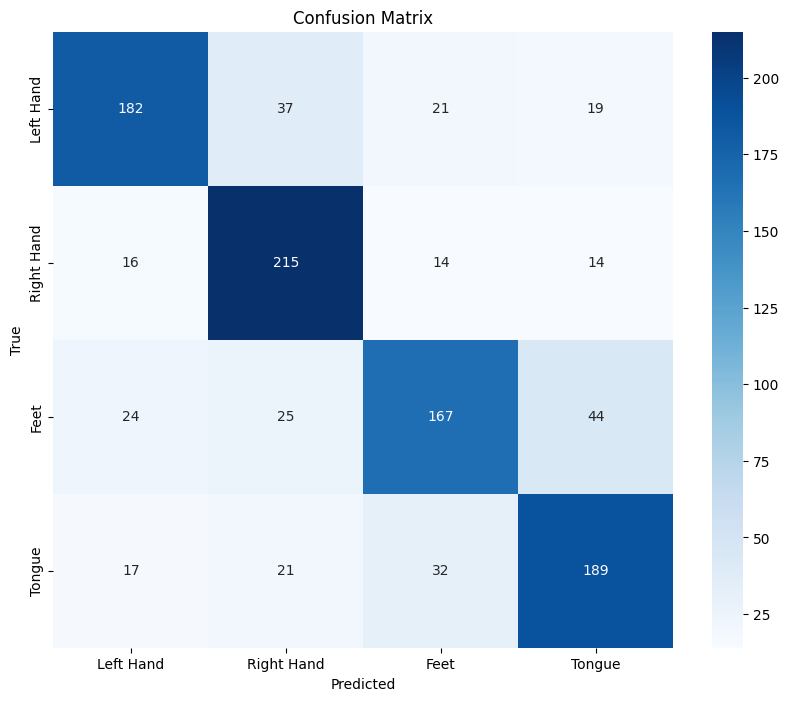


Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.76      0.70      0.73       259
  Right Hand       0.72      0.83      0.77       259
        Feet       0.71      0.64      0.68       260
      Tongue       0.71      0.73      0.72       259

    accuracy                           0.73      1037
   macro avg       0.73      0.73      0.72      1037
weighted avg       0.73      0.73      0.72      1037


Starting class-specific analysis...

ANALYZING CLASS: Left Hand

Analyzing Left Hand - Sample 1/5


/usr/local/lib/python3.11/dist-packages/captum/attr/_core/deep_lift.py:294: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
/usr/local/lib/python3.11/dist-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


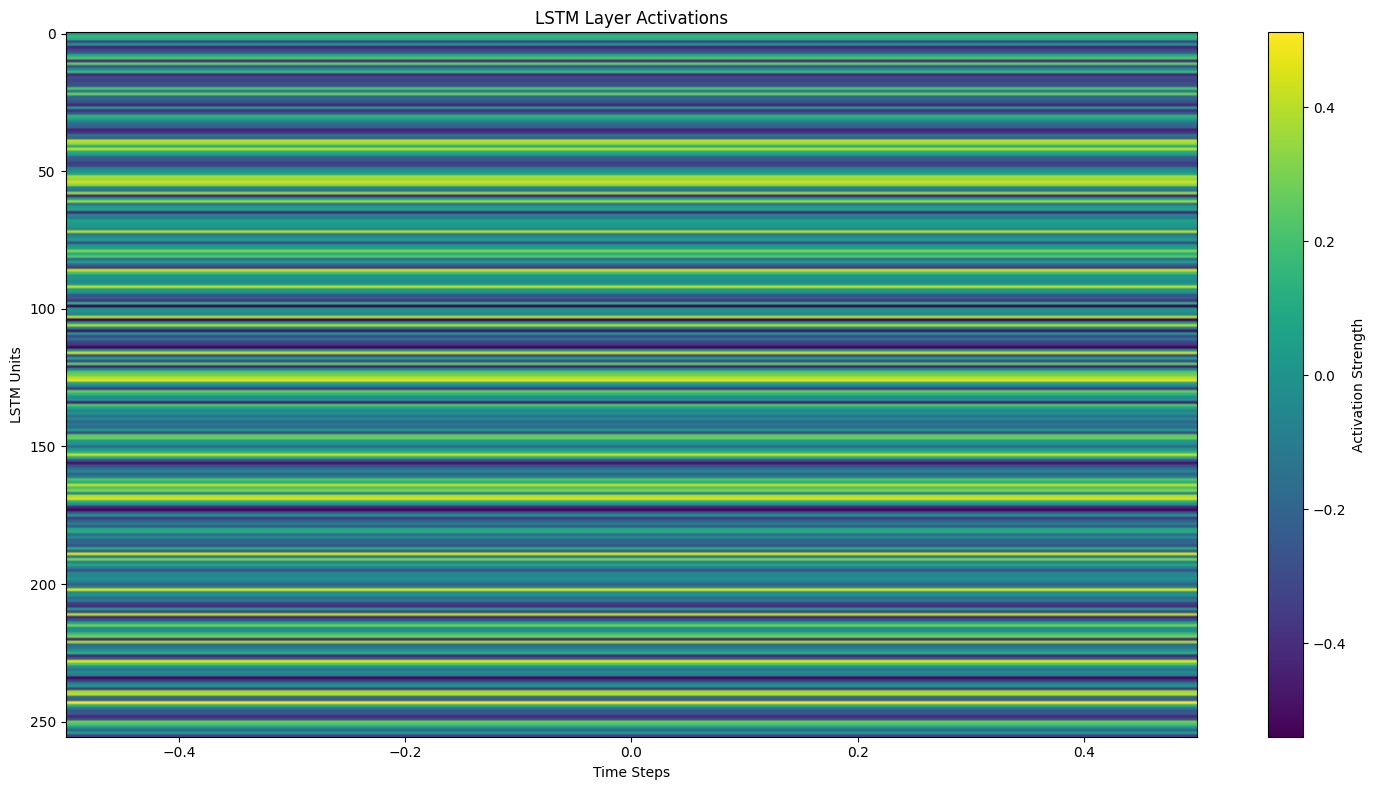

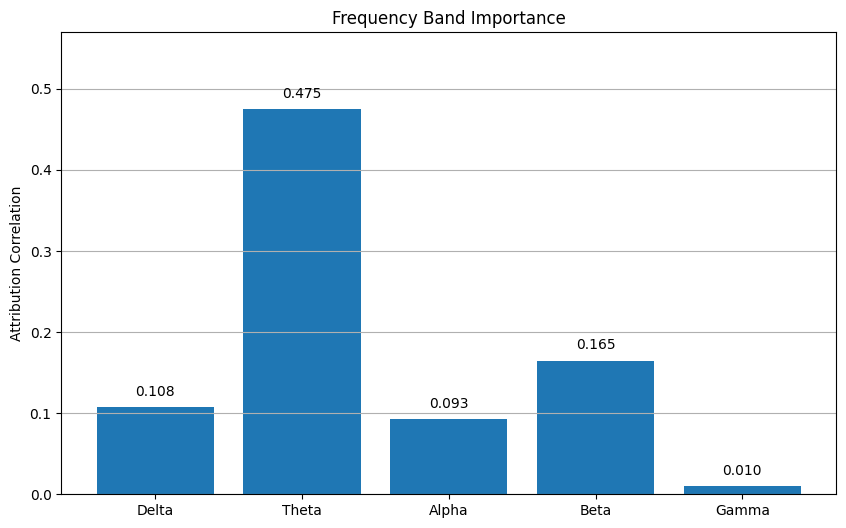


Analyzing Left Hand - Sample 2/5


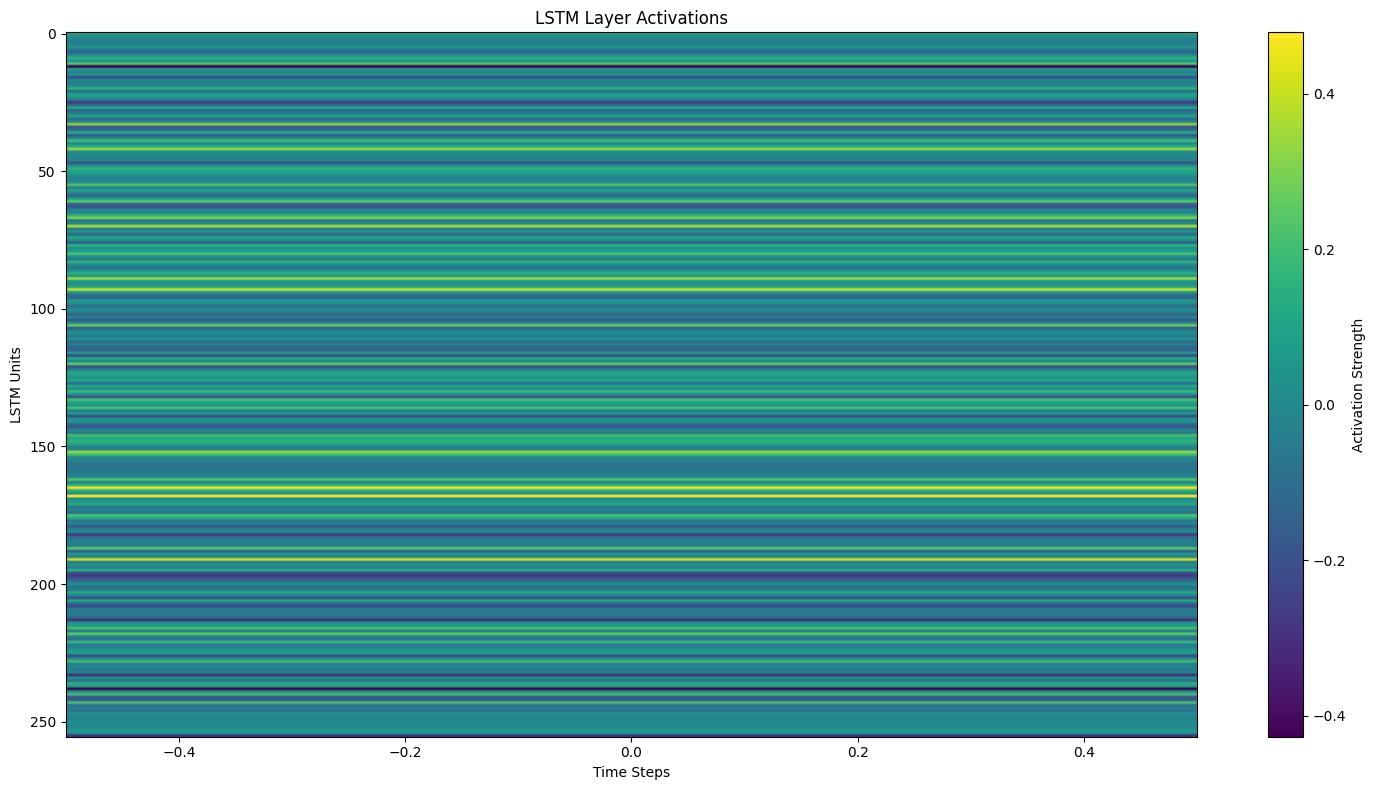

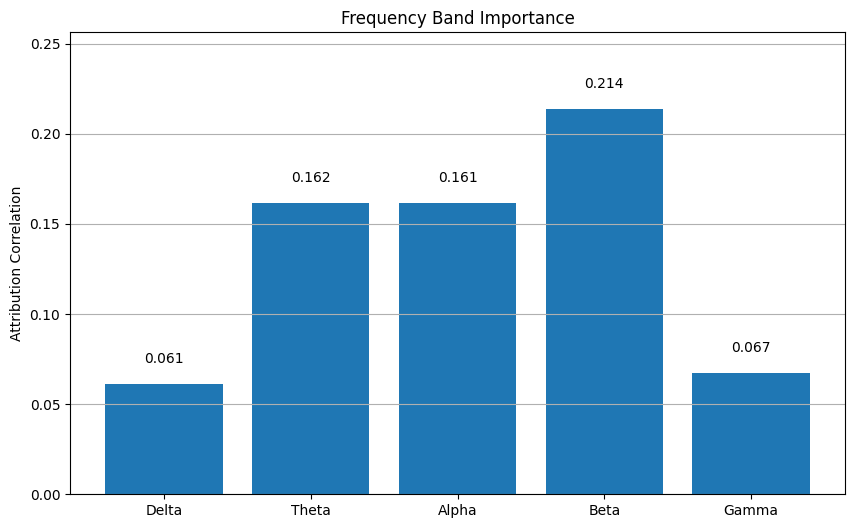


Analyzing Left Hand - Sample 3/5


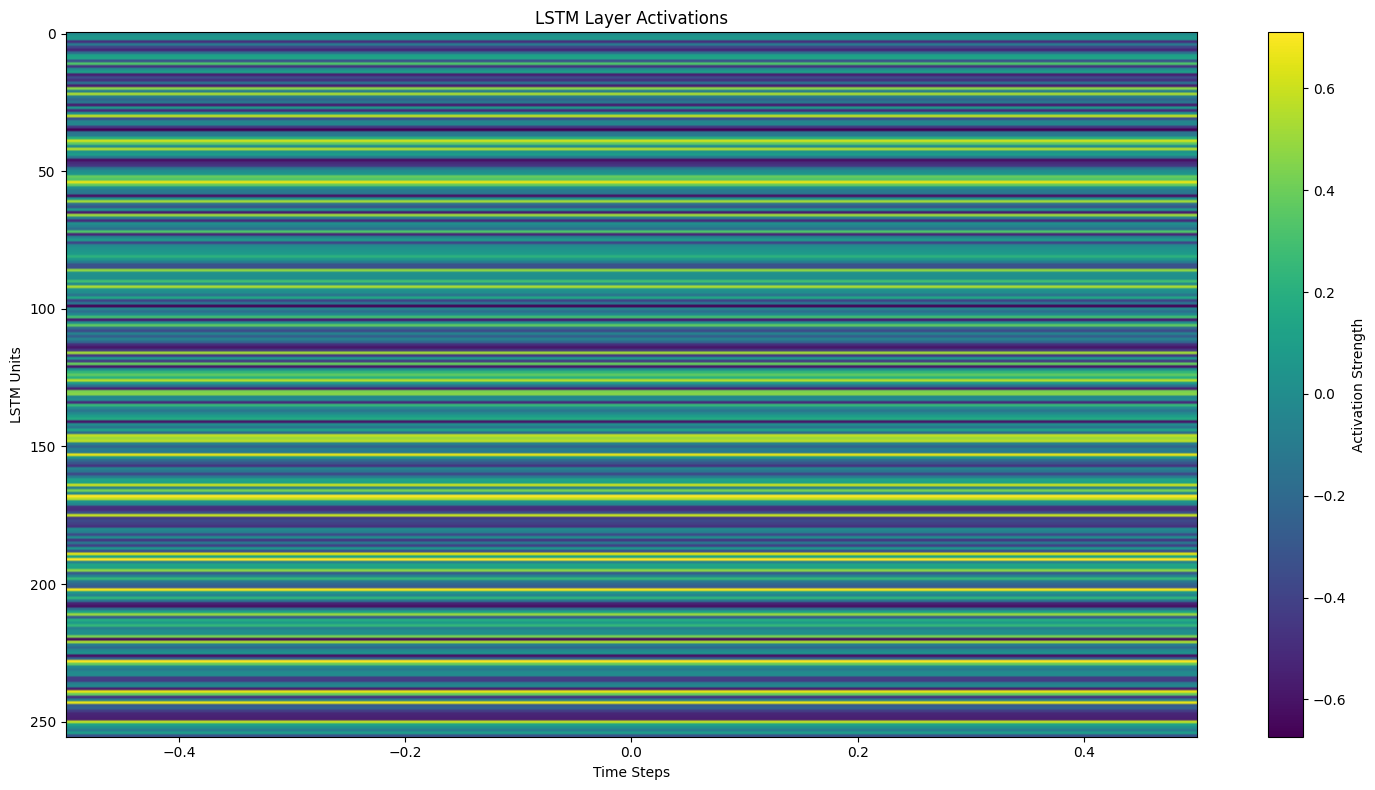

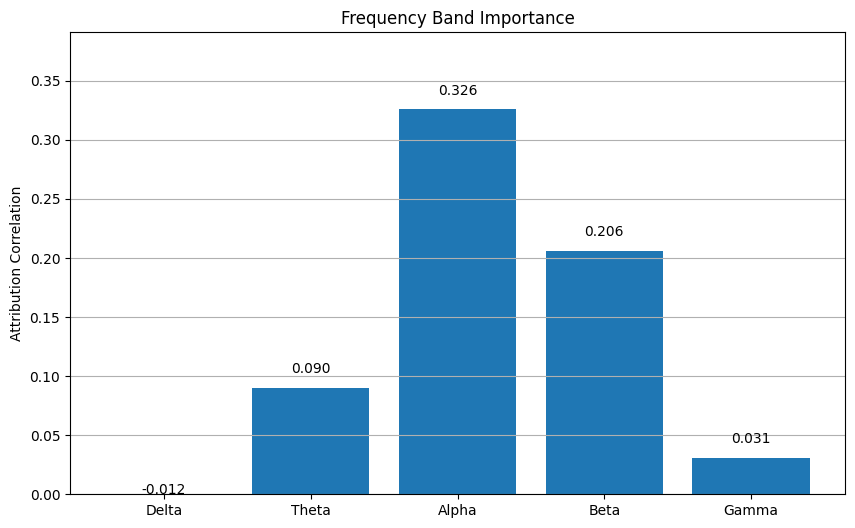


Analyzing Left Hand - Sample 4/5


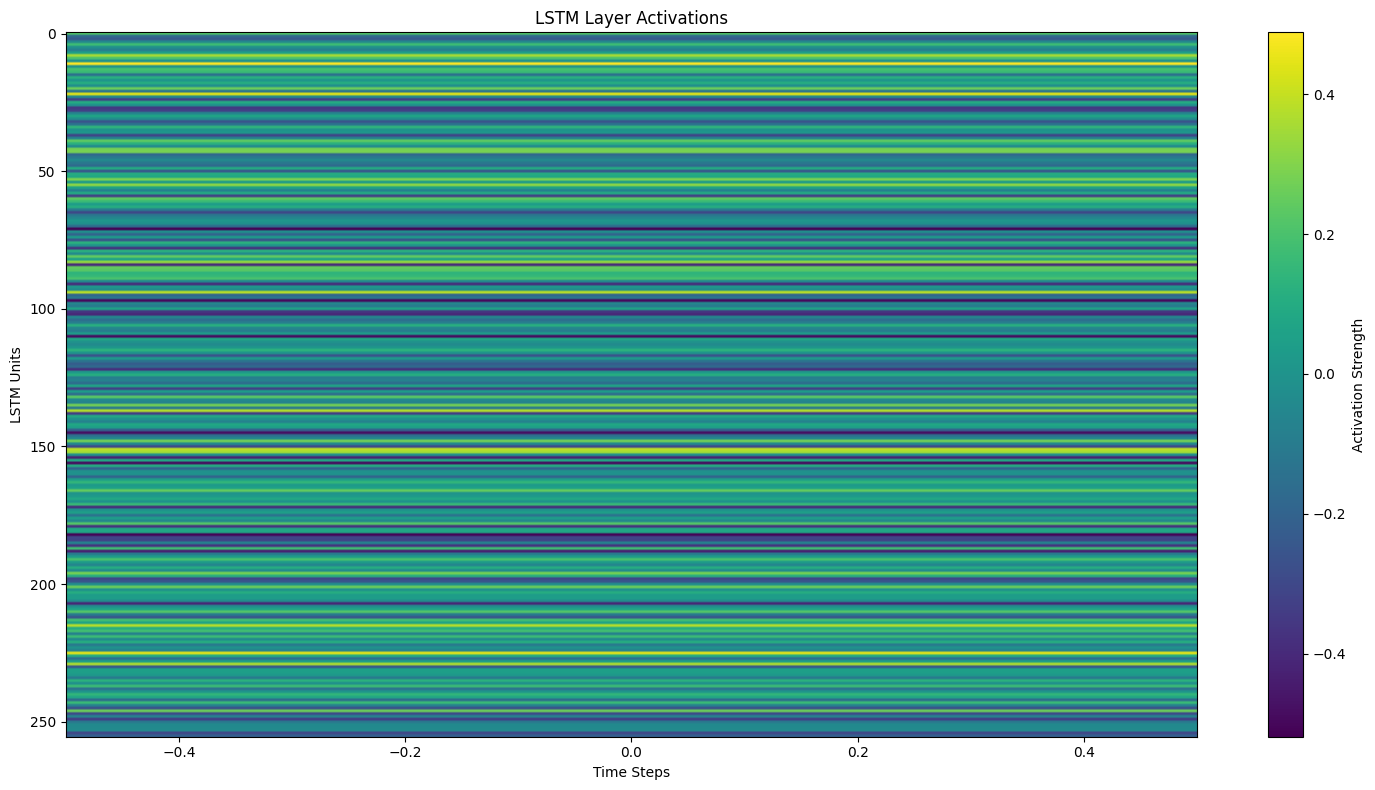

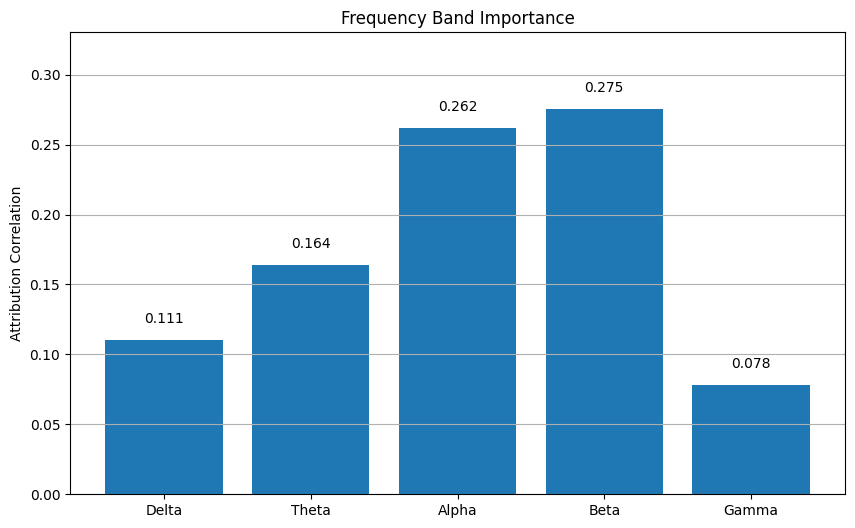


Analyzing Left Hand - Sample 5/5


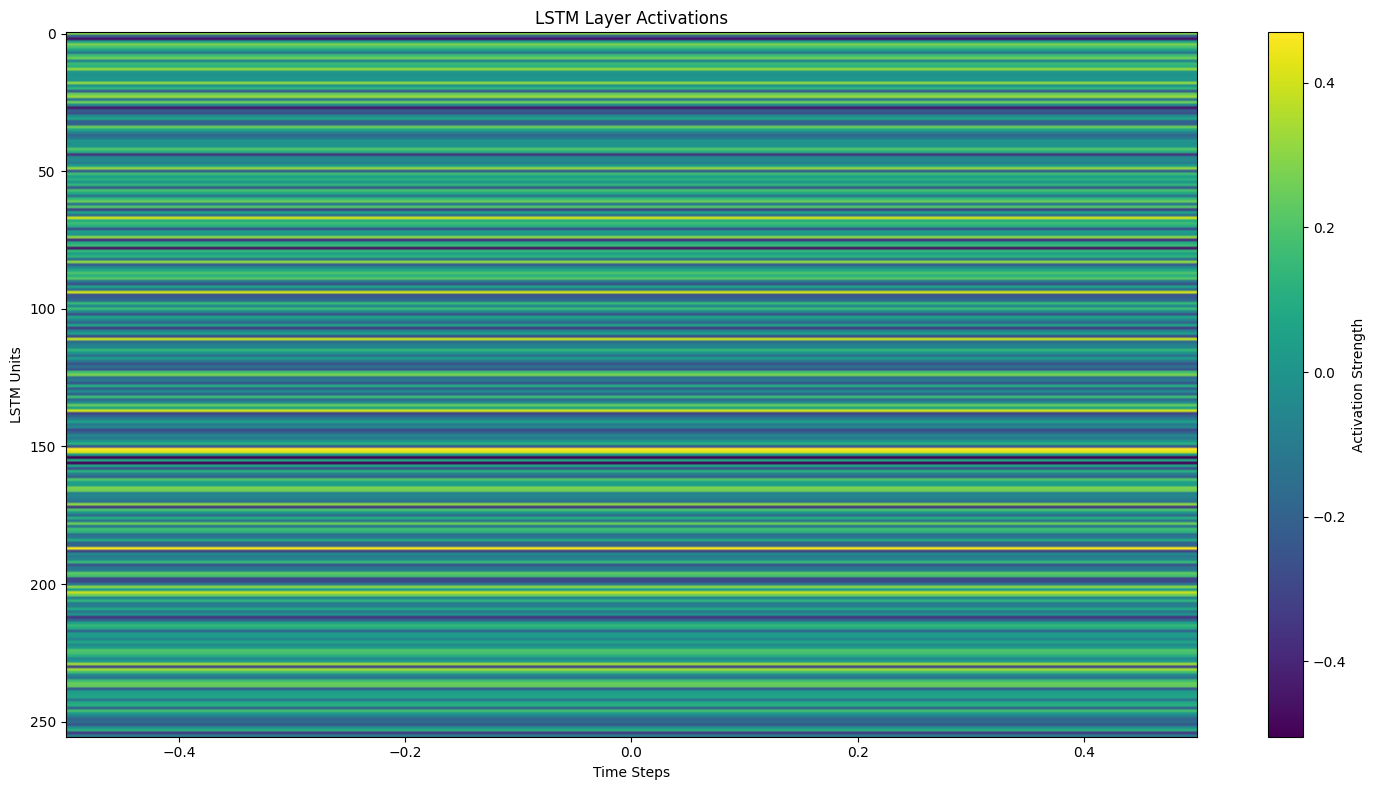

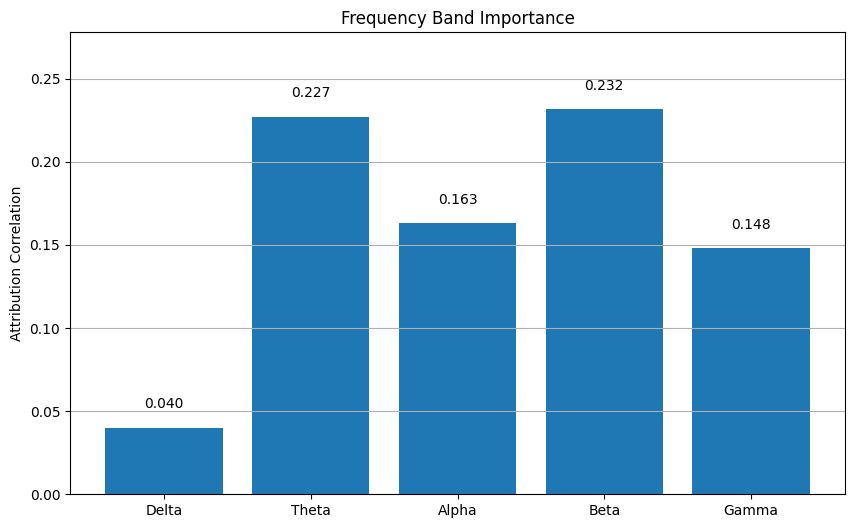


Channel Importance for Left Hand


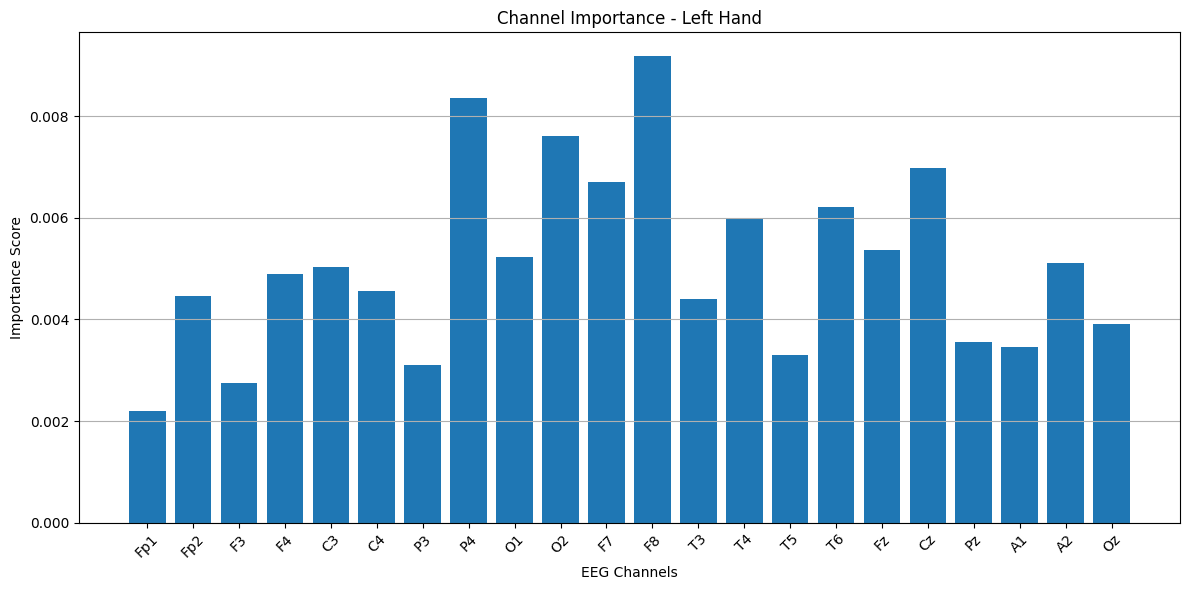


Attributions Over Time for Left Hand


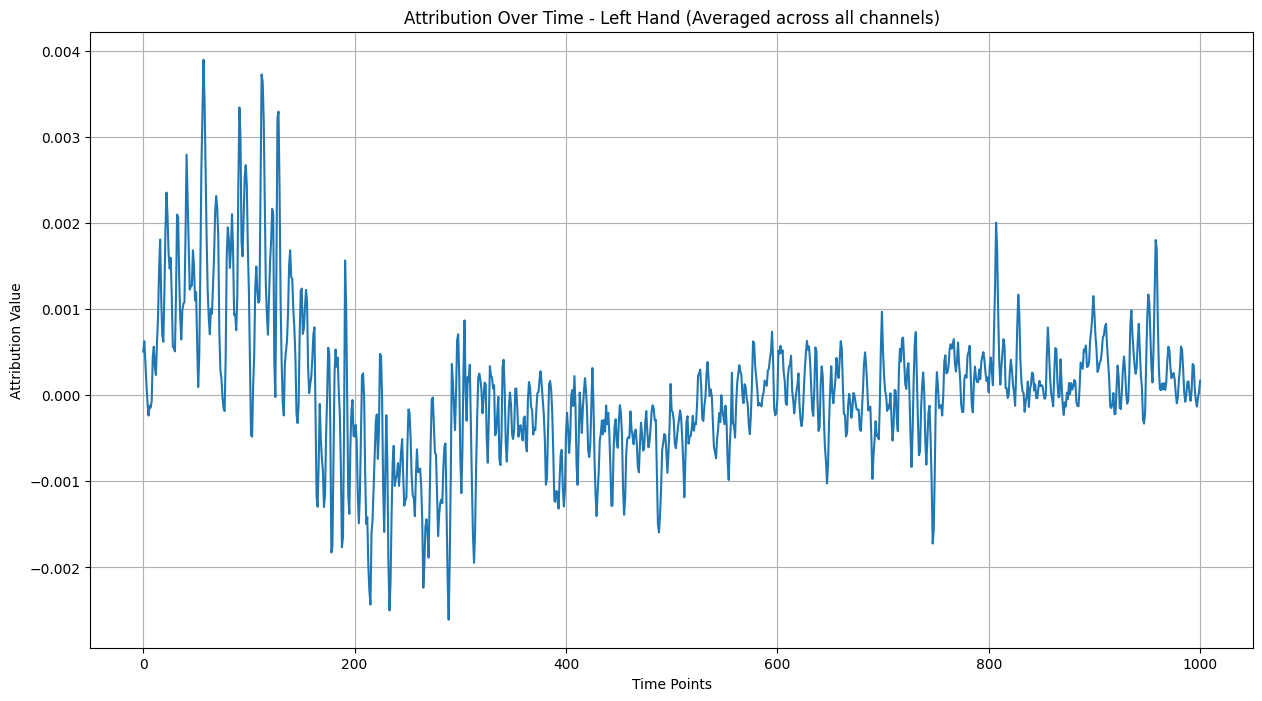


Topographic Attribution Map for Left Hand


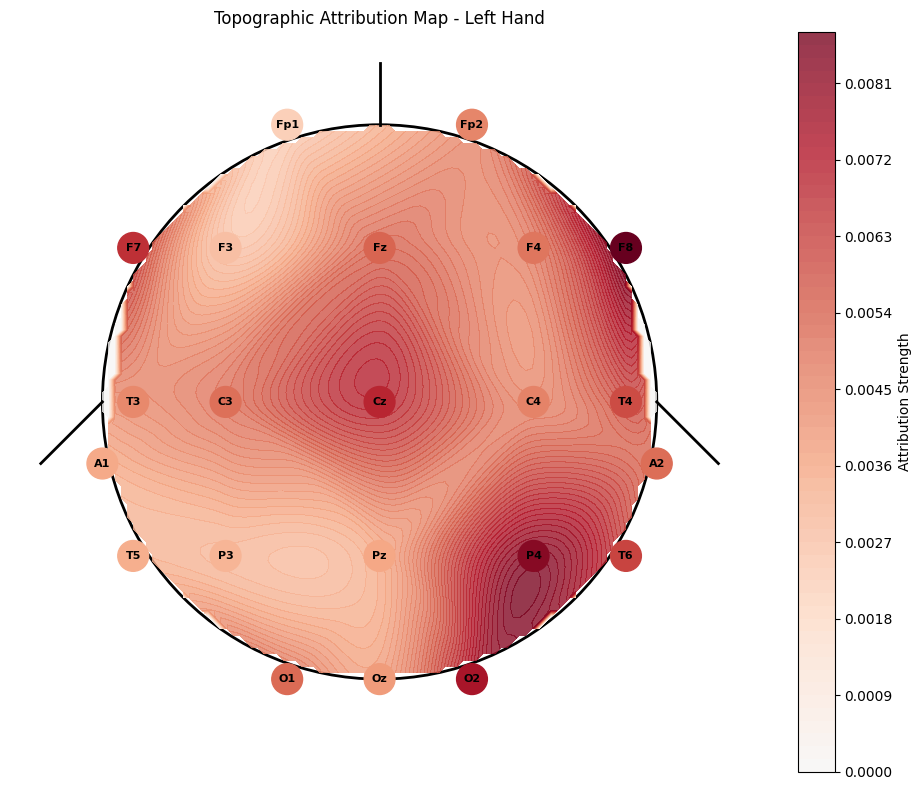


Most Influential Time Points for Left Hand


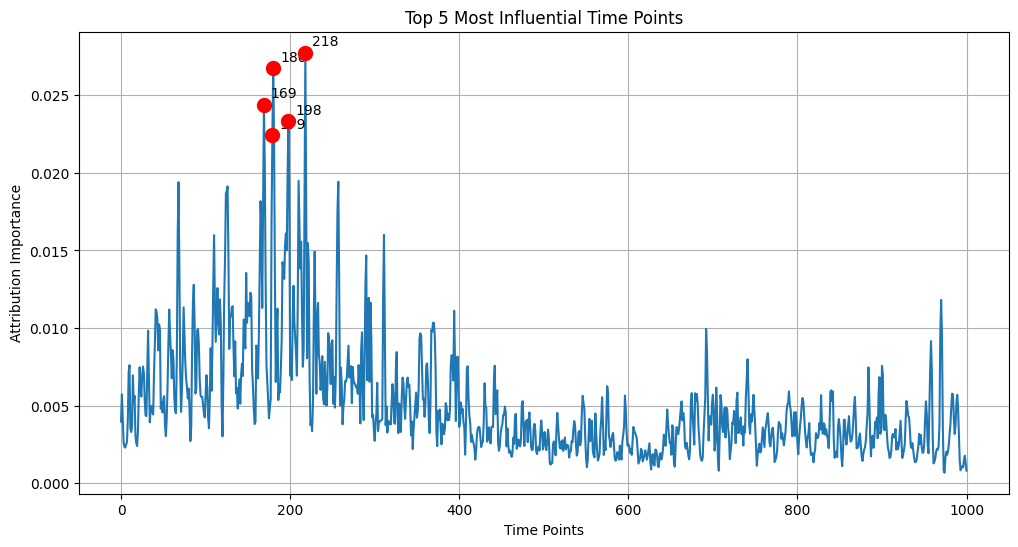


Frequency Band Importance for Left Hand


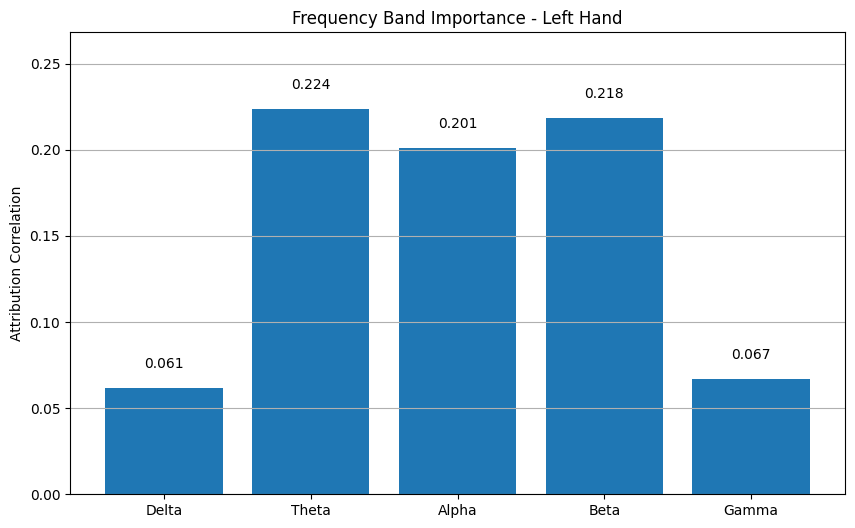


Time-Frequency Analysis for Left Hand


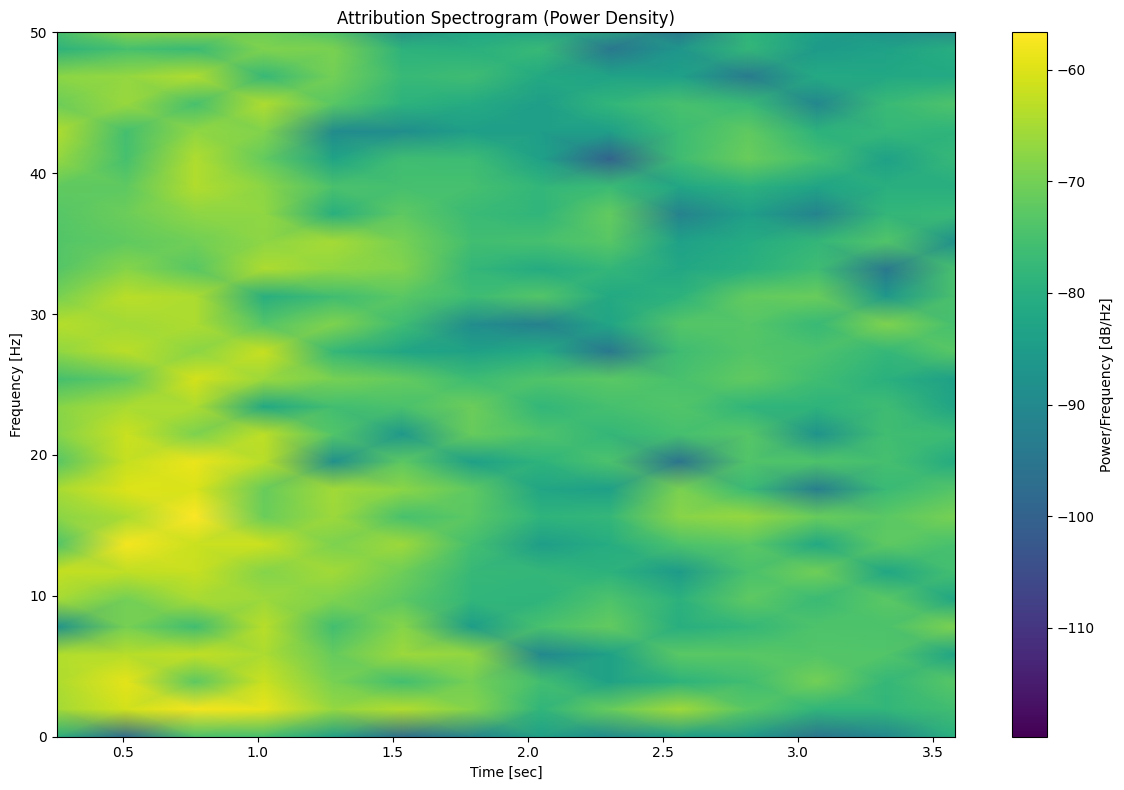

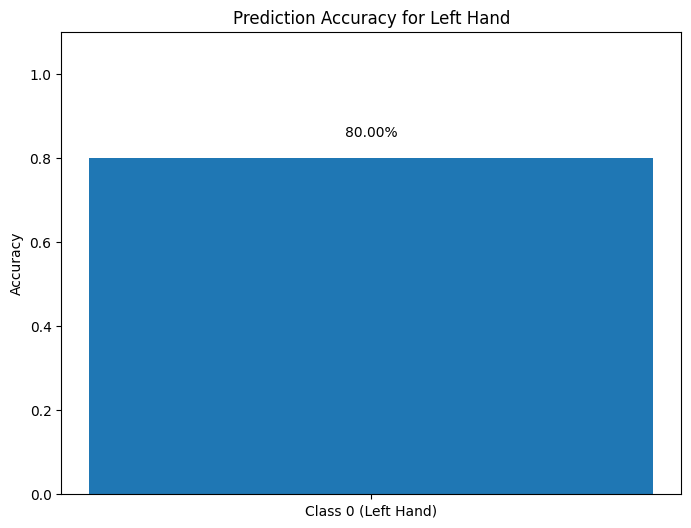


ANALYZING CLASS: Right Hand

Analyzing Right Hand - Sample 1/5


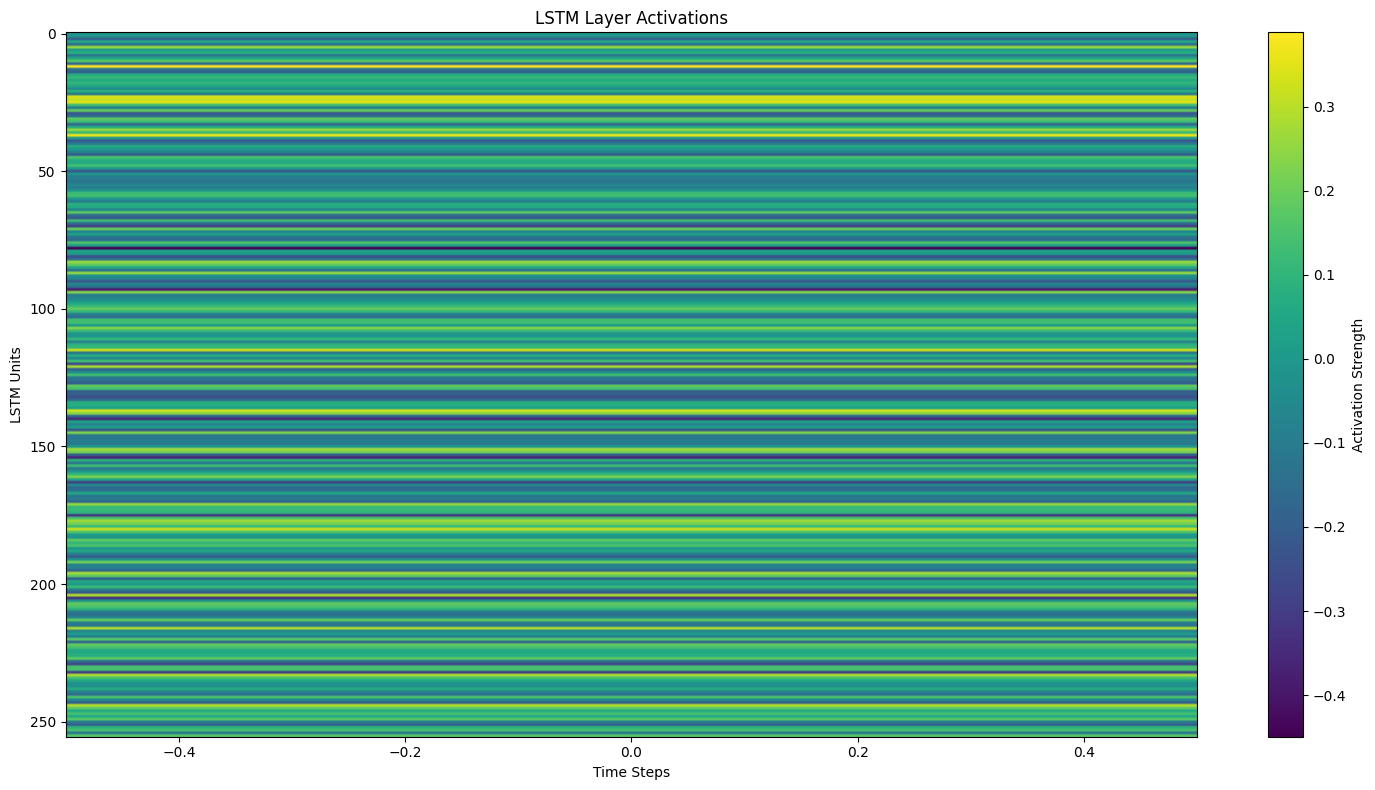

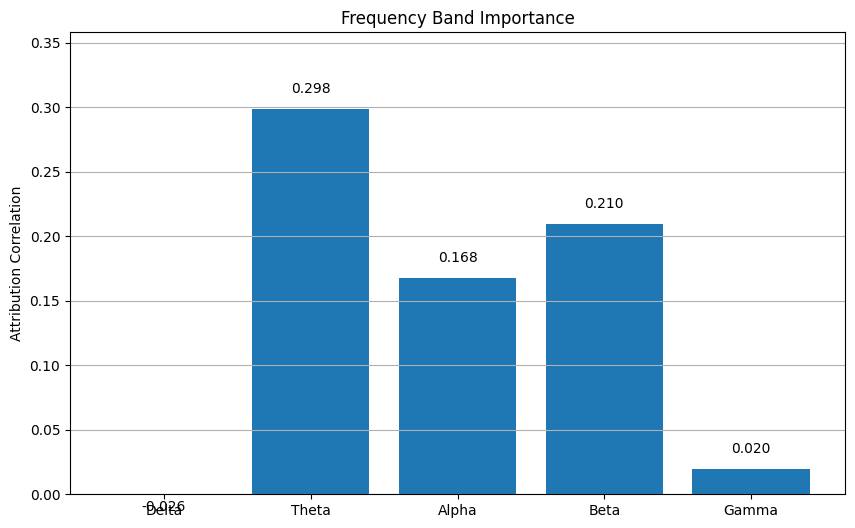


Analyzing Right Hand - Sample 2/5


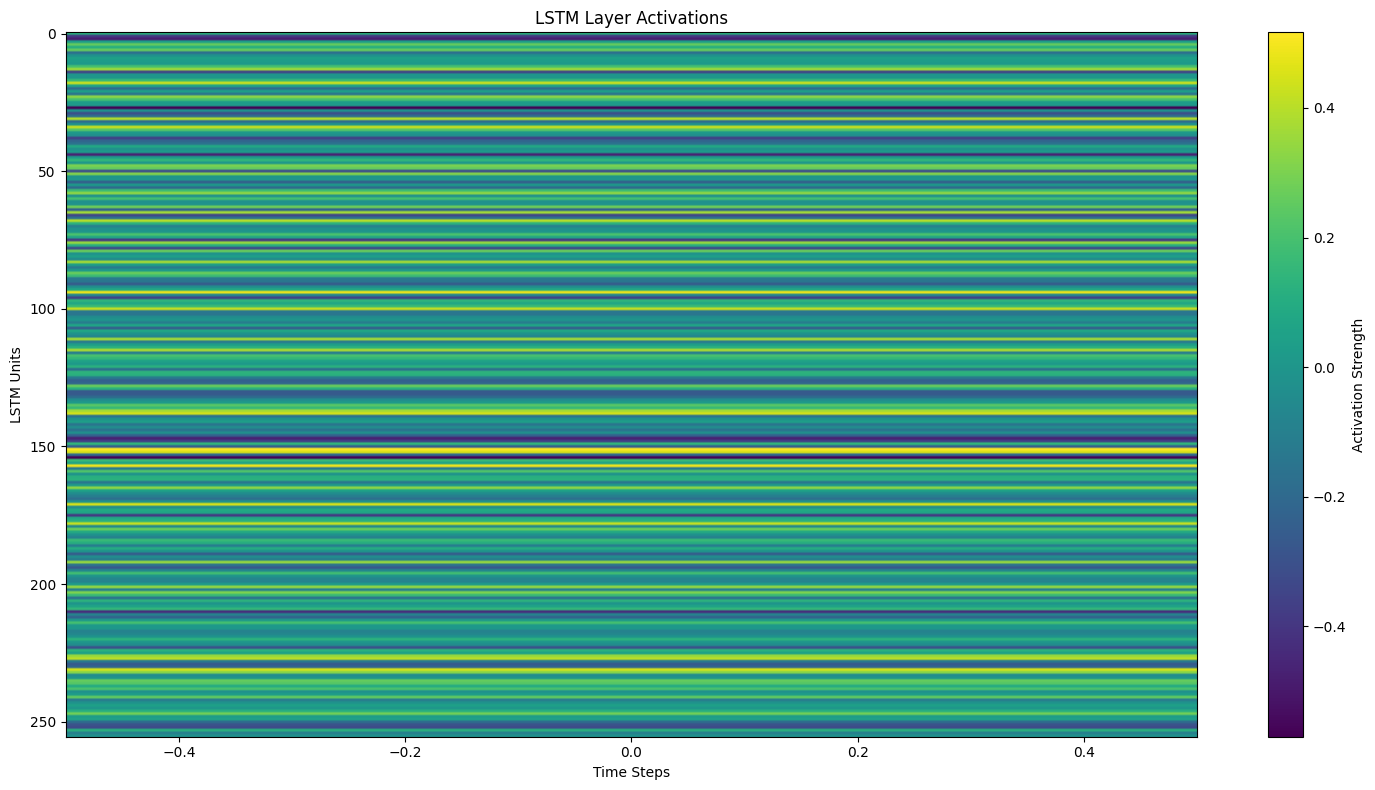

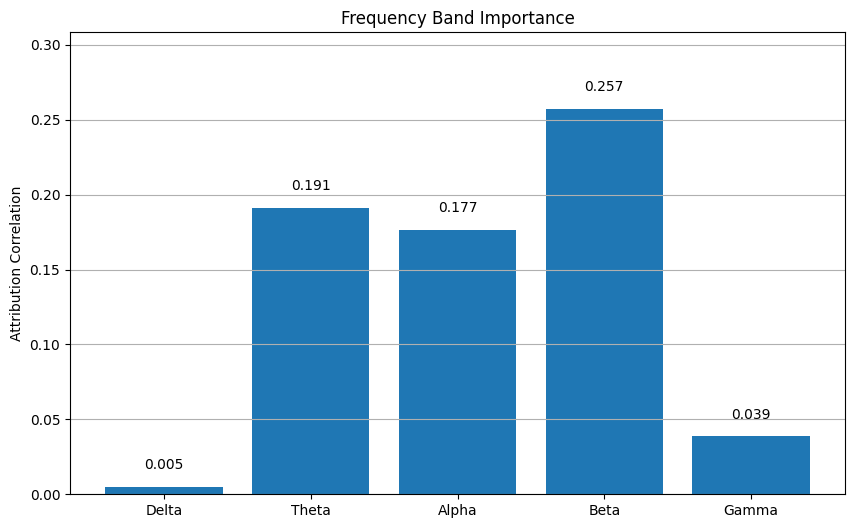


Analyzing Right Hand - Sample 3/5


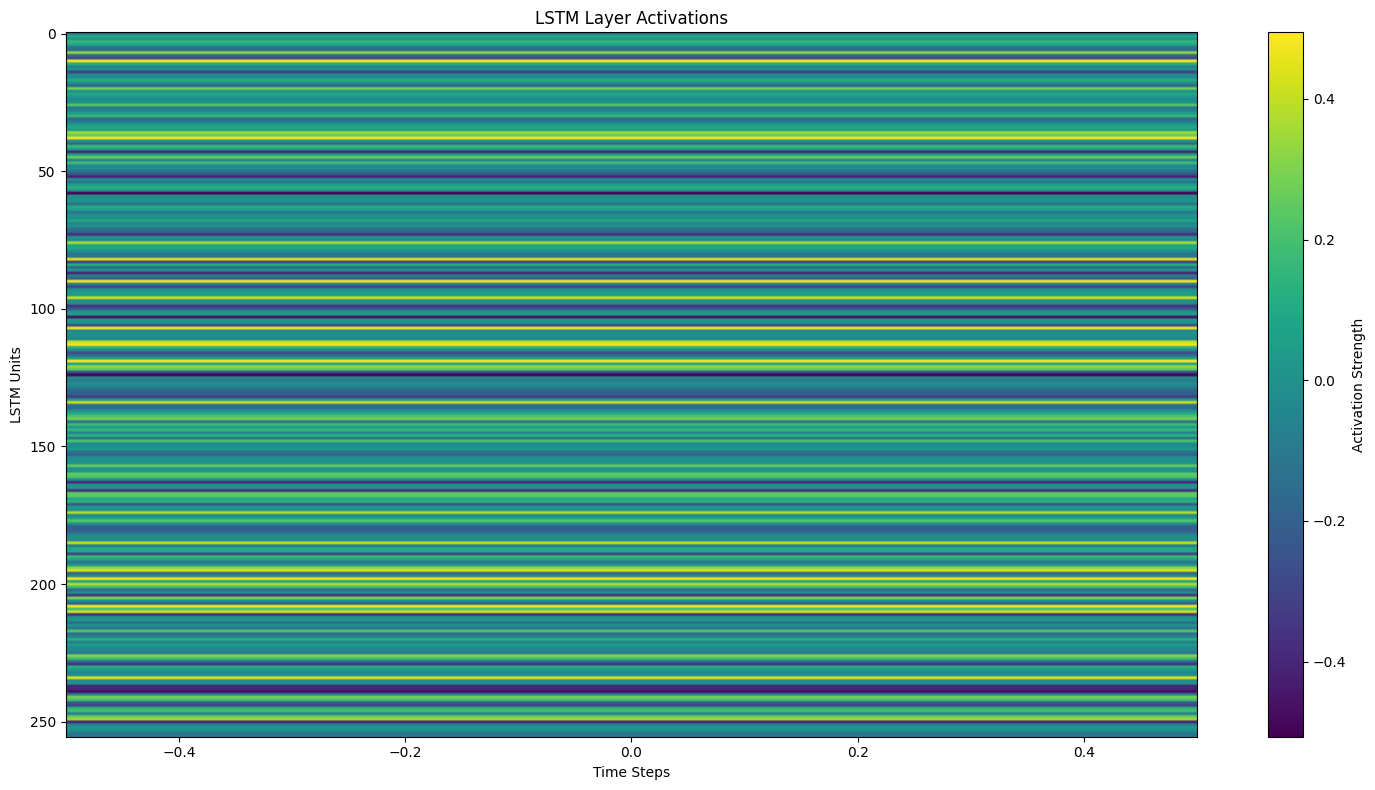

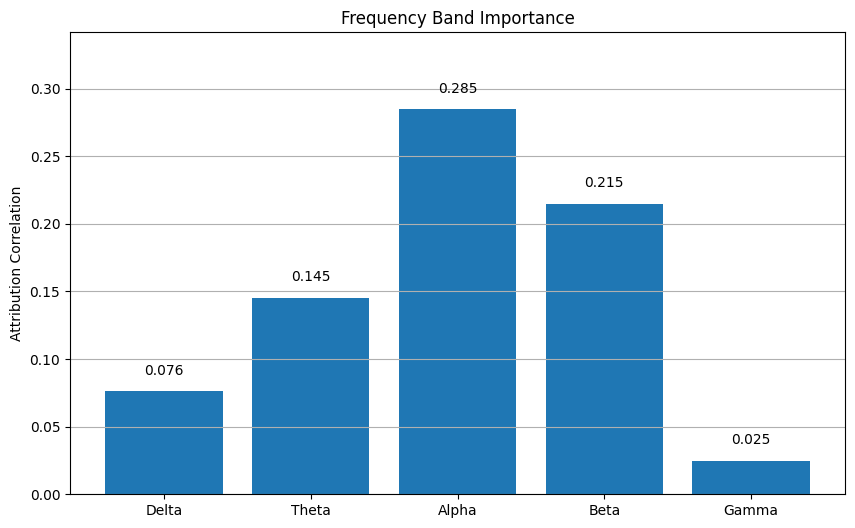


Analyzing Right Hand - Sample 4/5


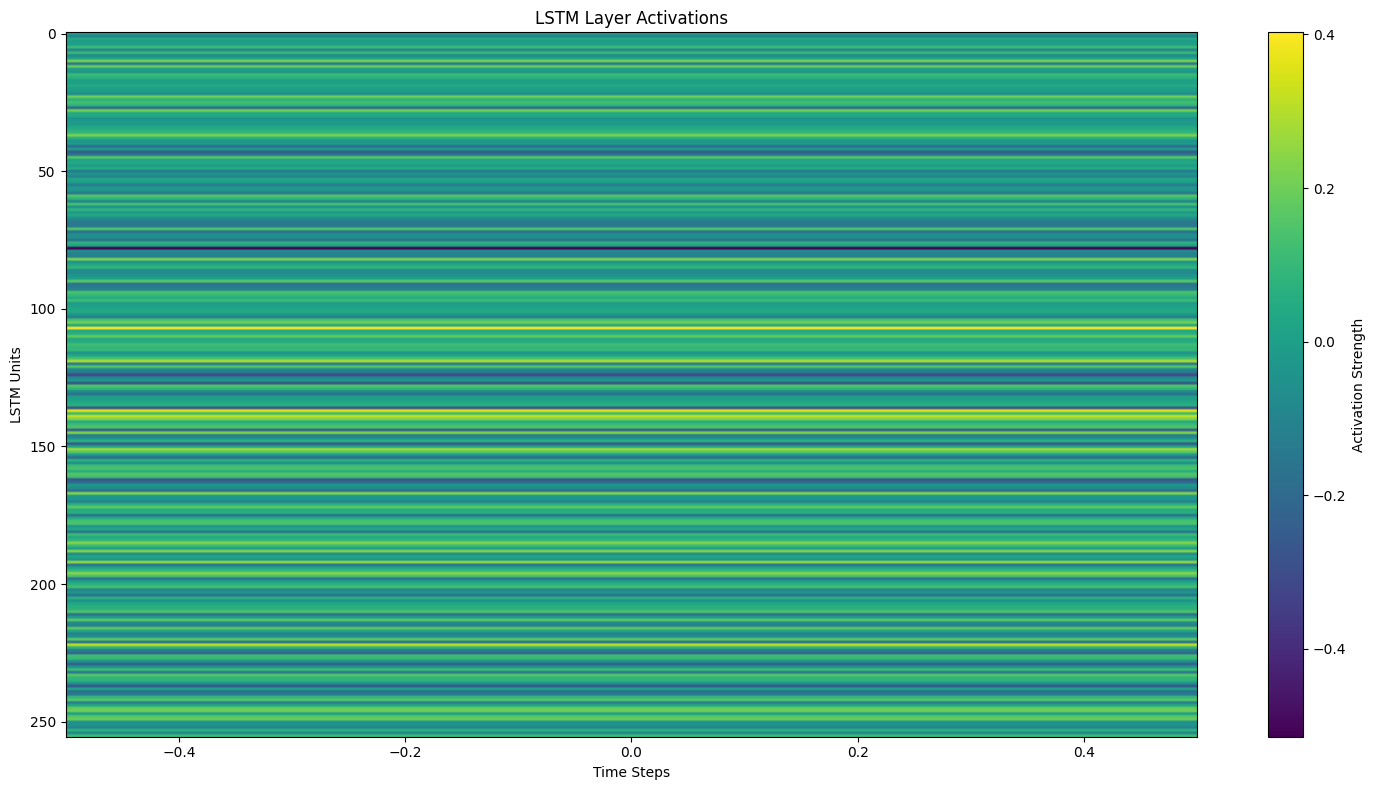

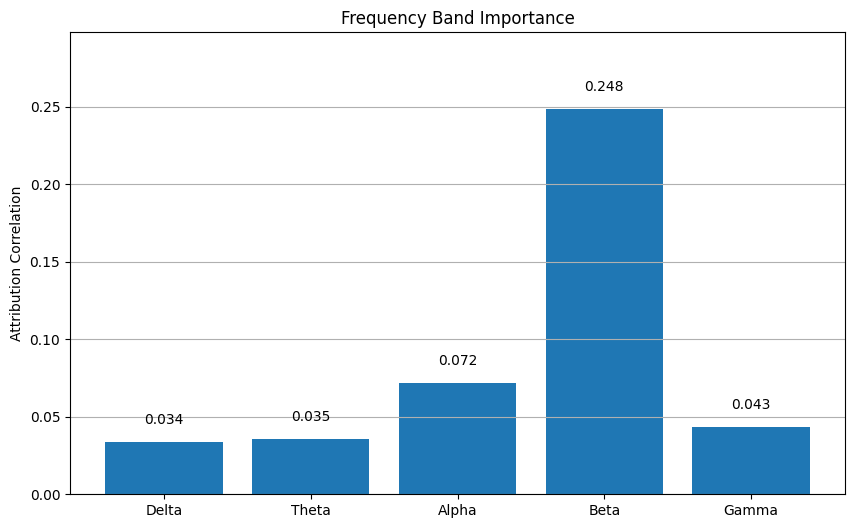


Analyzing Right Hand - Sample 5/5


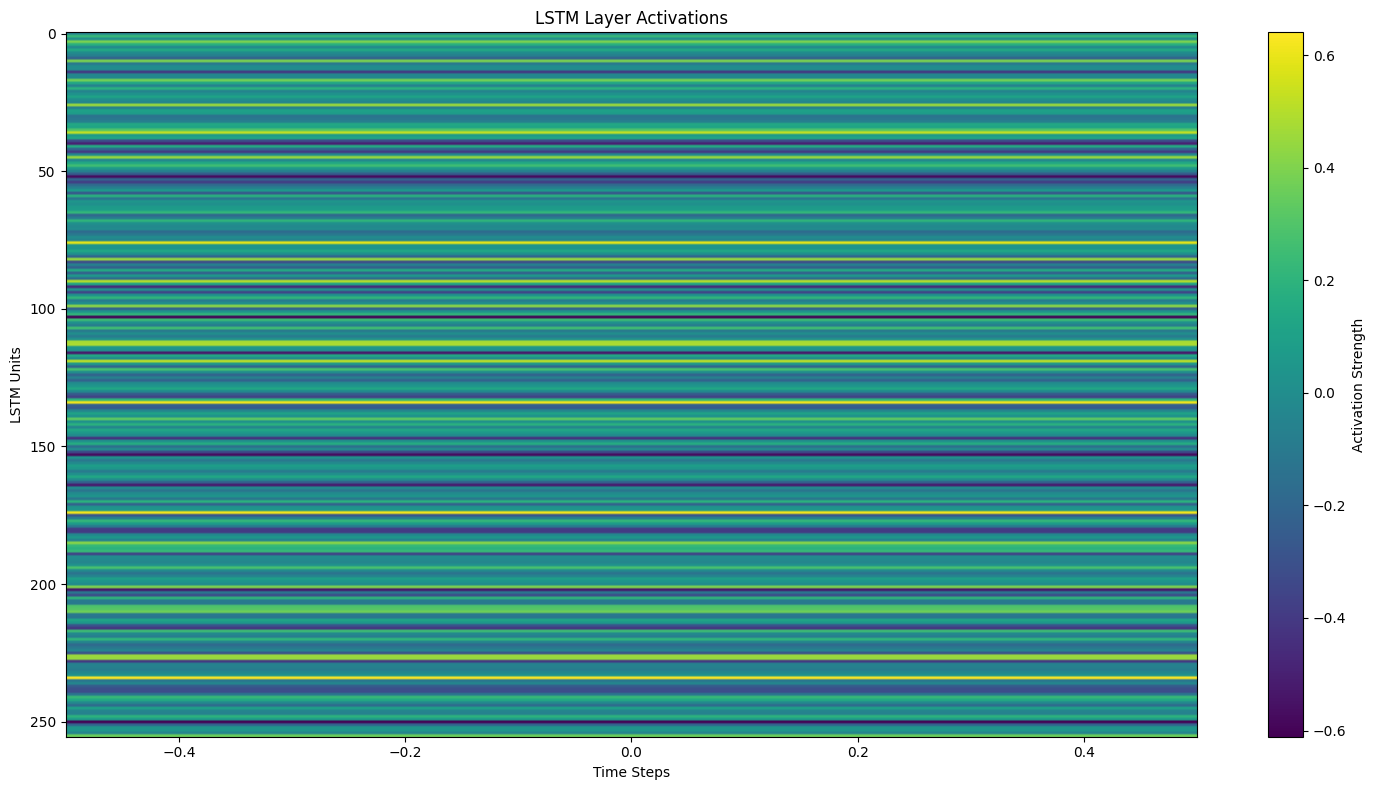

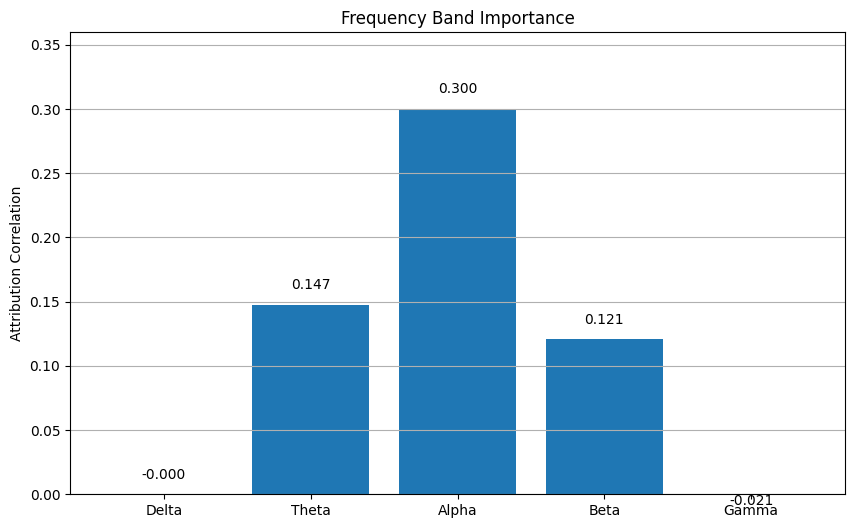


Channel Importance for Right Hand


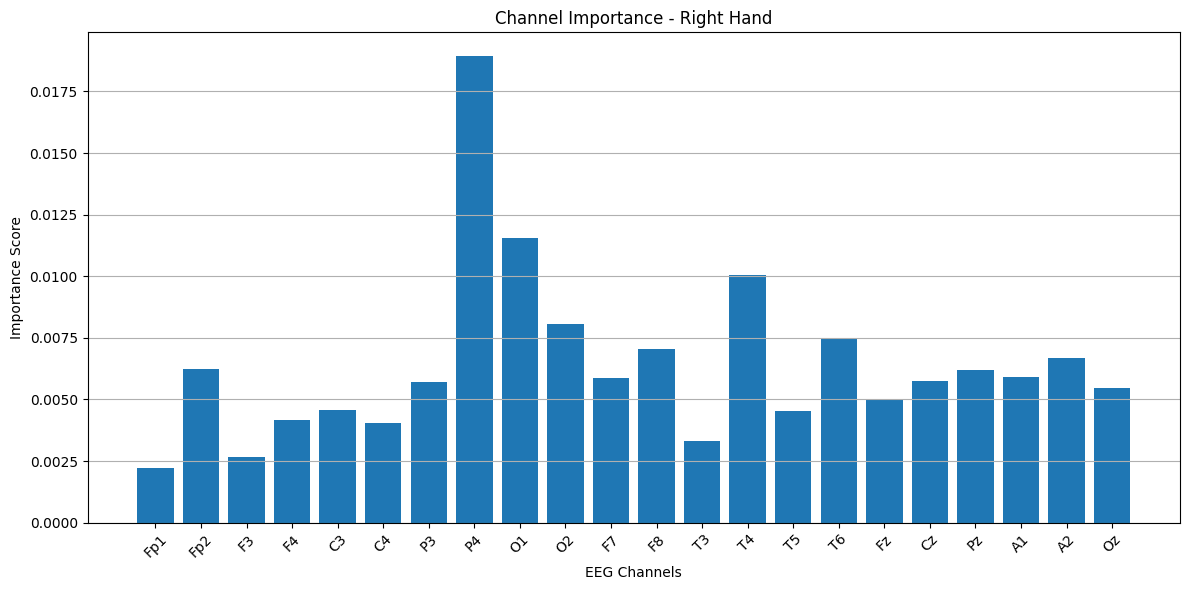


Attributions Over Time for Right Hand


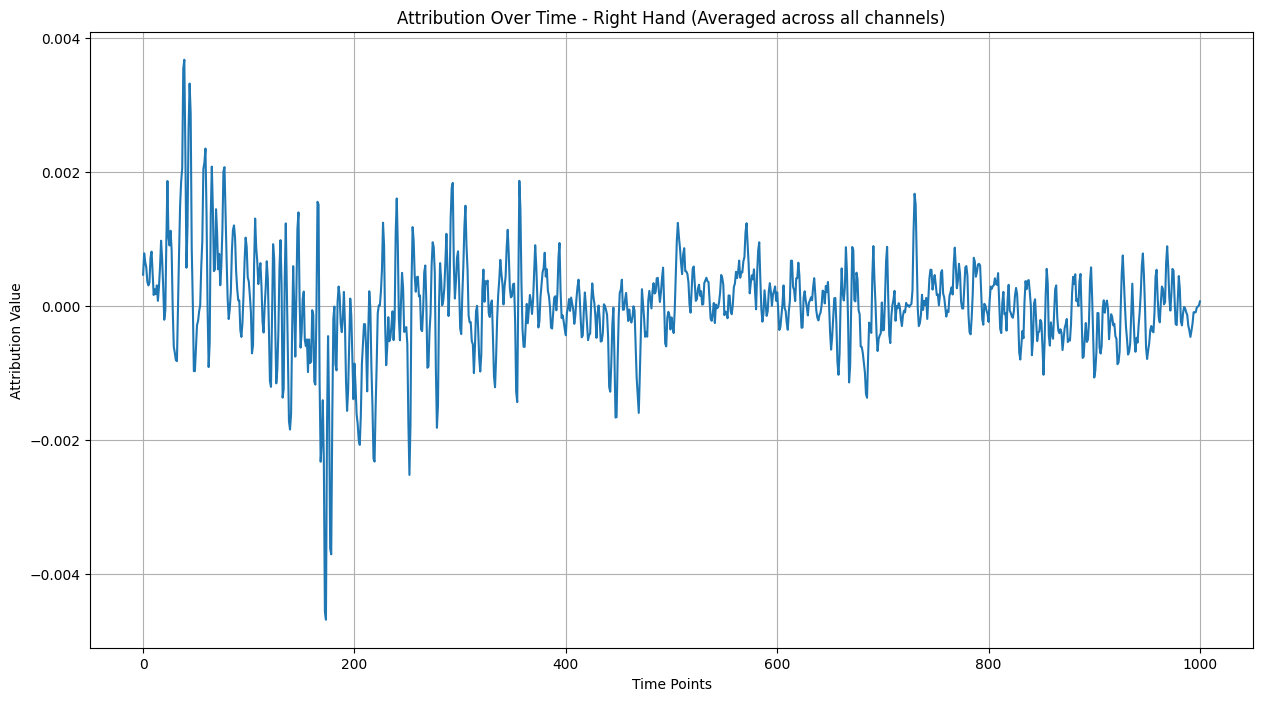


Topographic Attribution Map for Right Hand


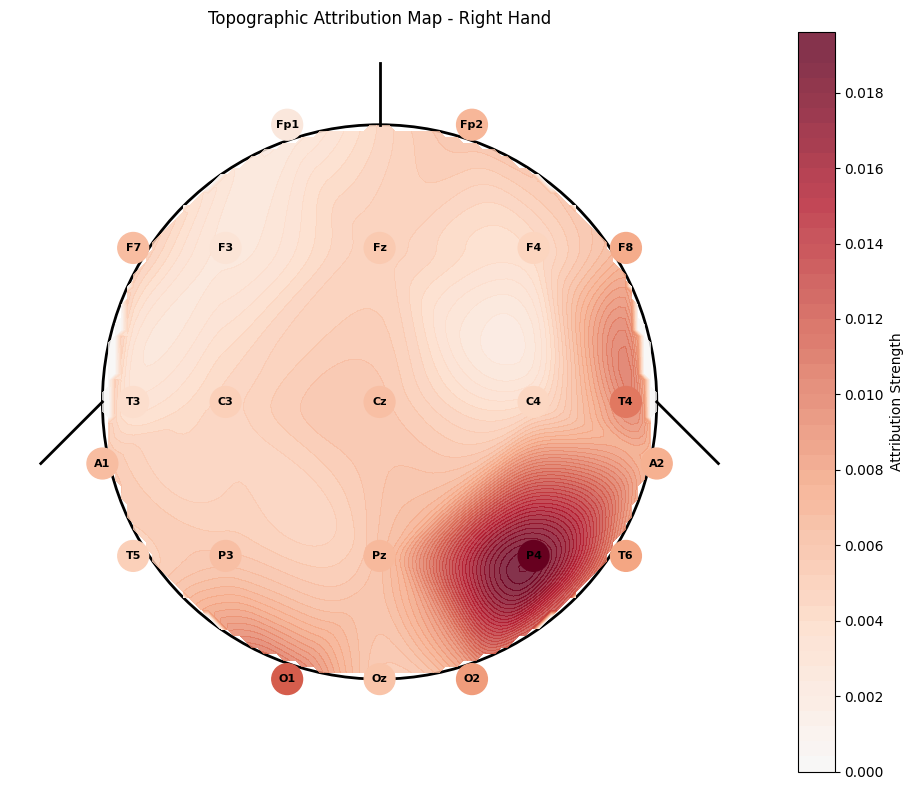


Most Influential Time Points for Right Hand


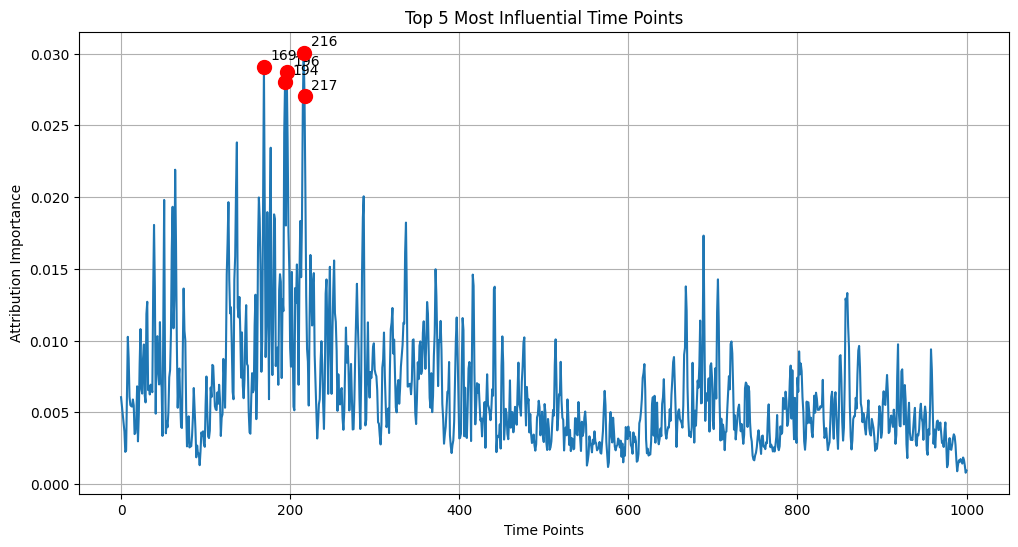


Frequency Band Importance for Right Hand


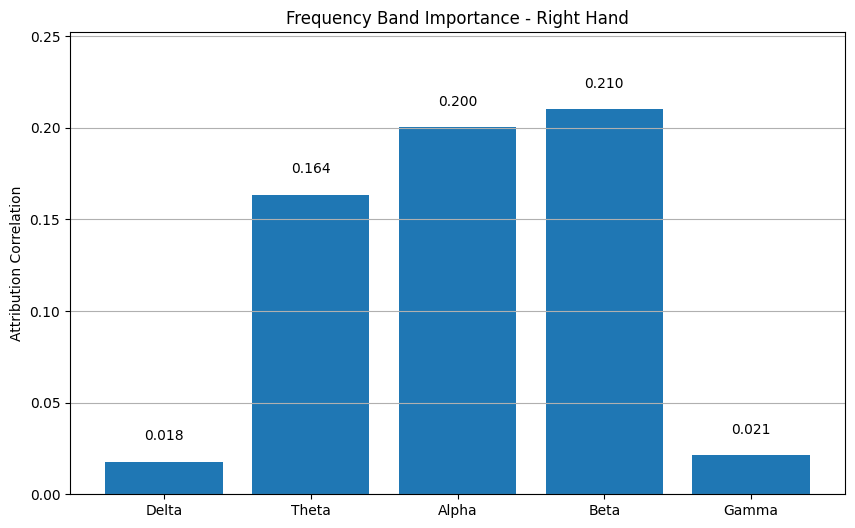


Time-Frequency Analysis for Right Hand


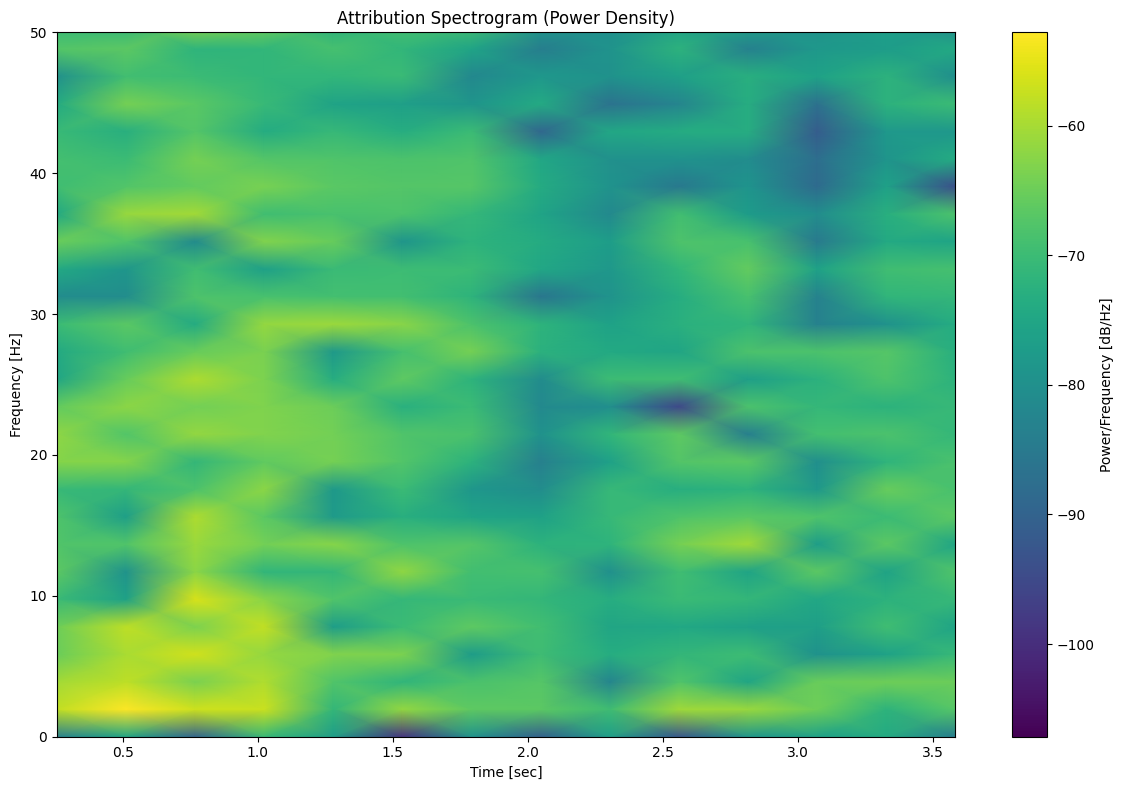

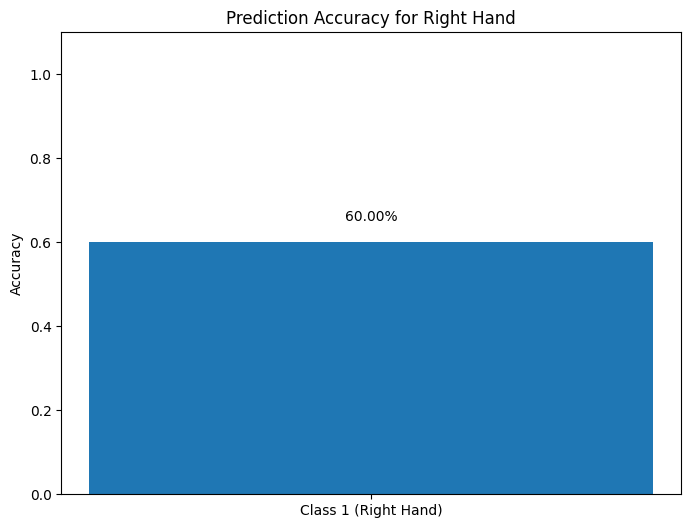


ANALYZING CLASS: Feet

Analyzing Feet - Sample 1/5


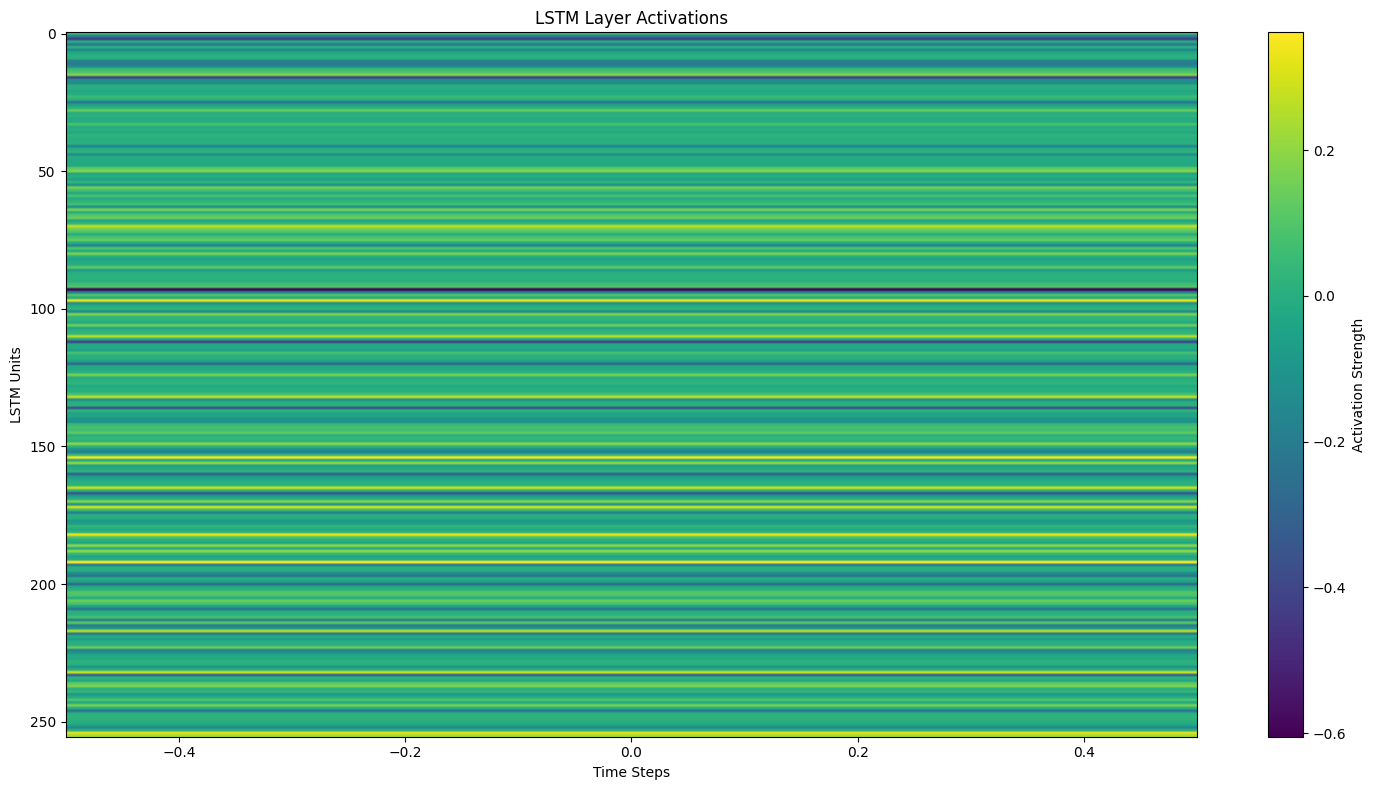

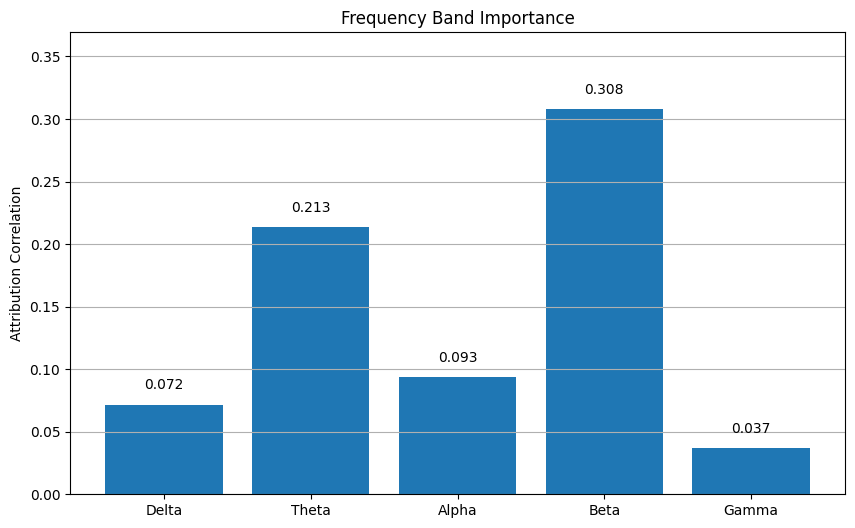


Analyzing Feet - Sample 2/5


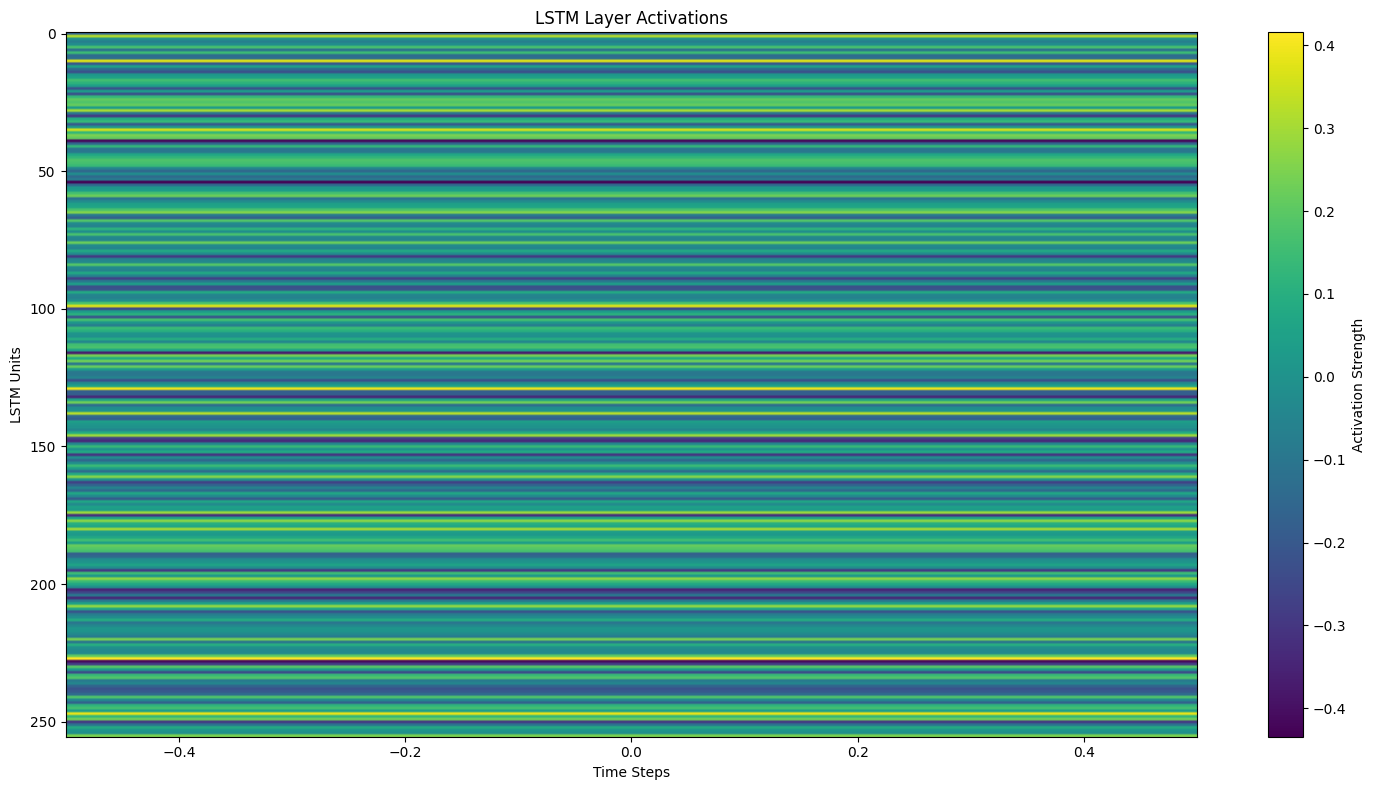

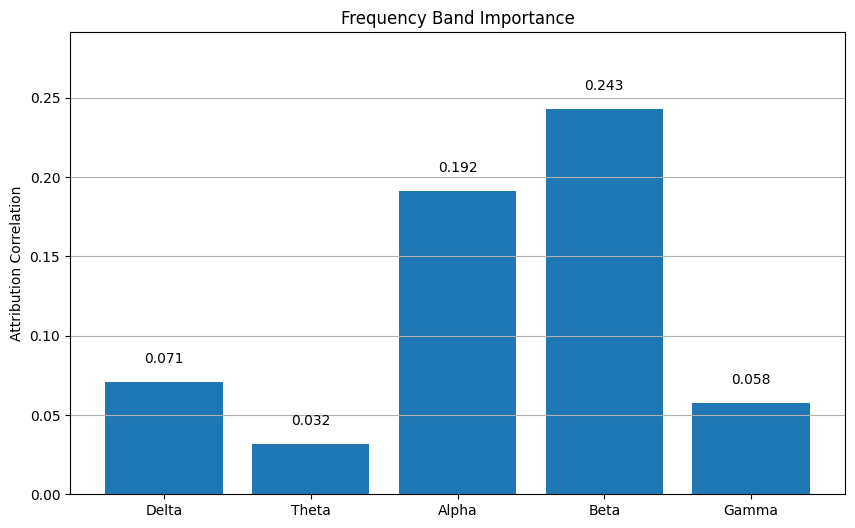


Analyzing Feet - Sample 3/5


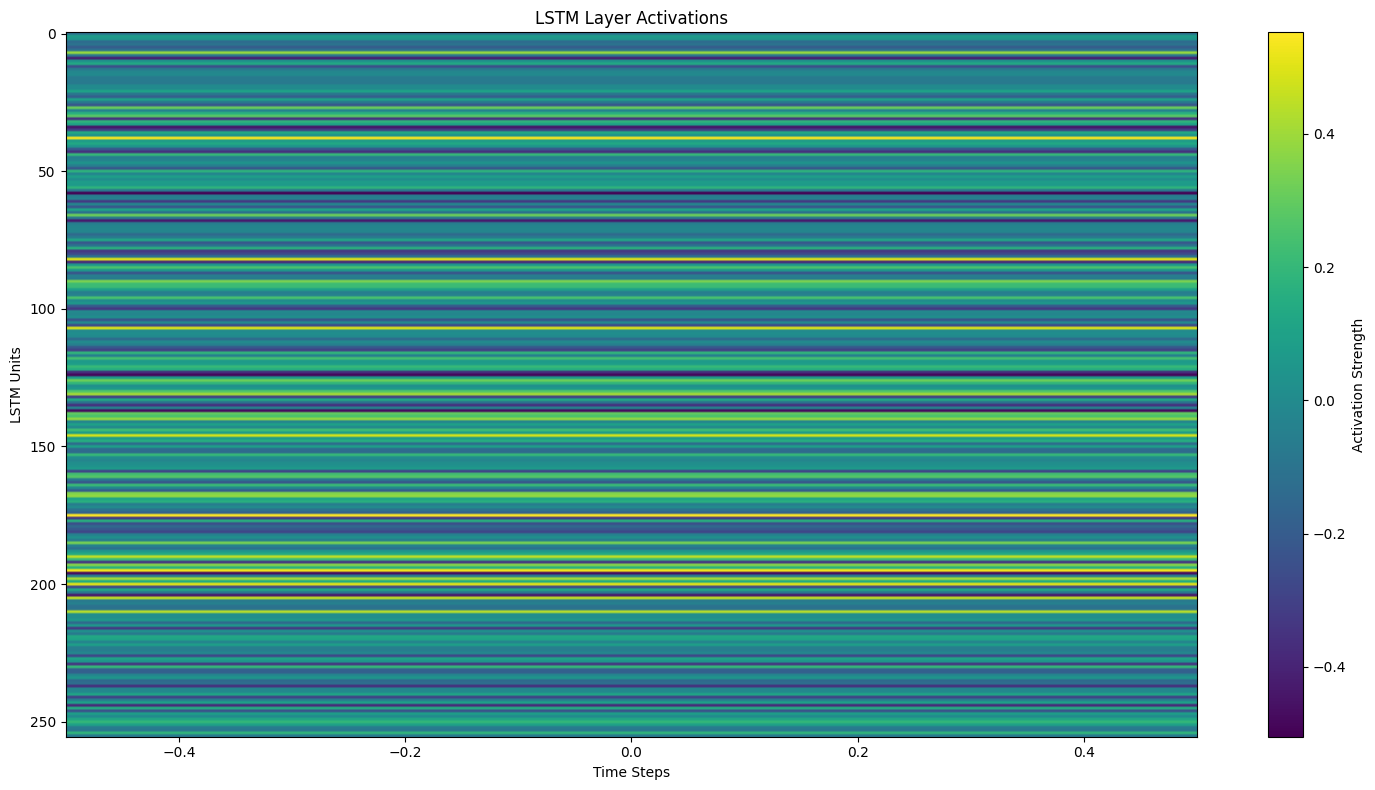

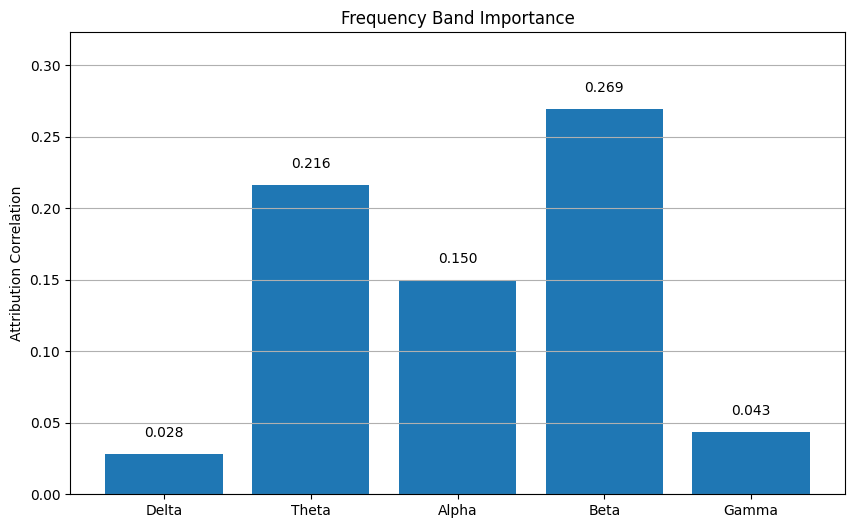


Analyzing Feet - Sample 4/5


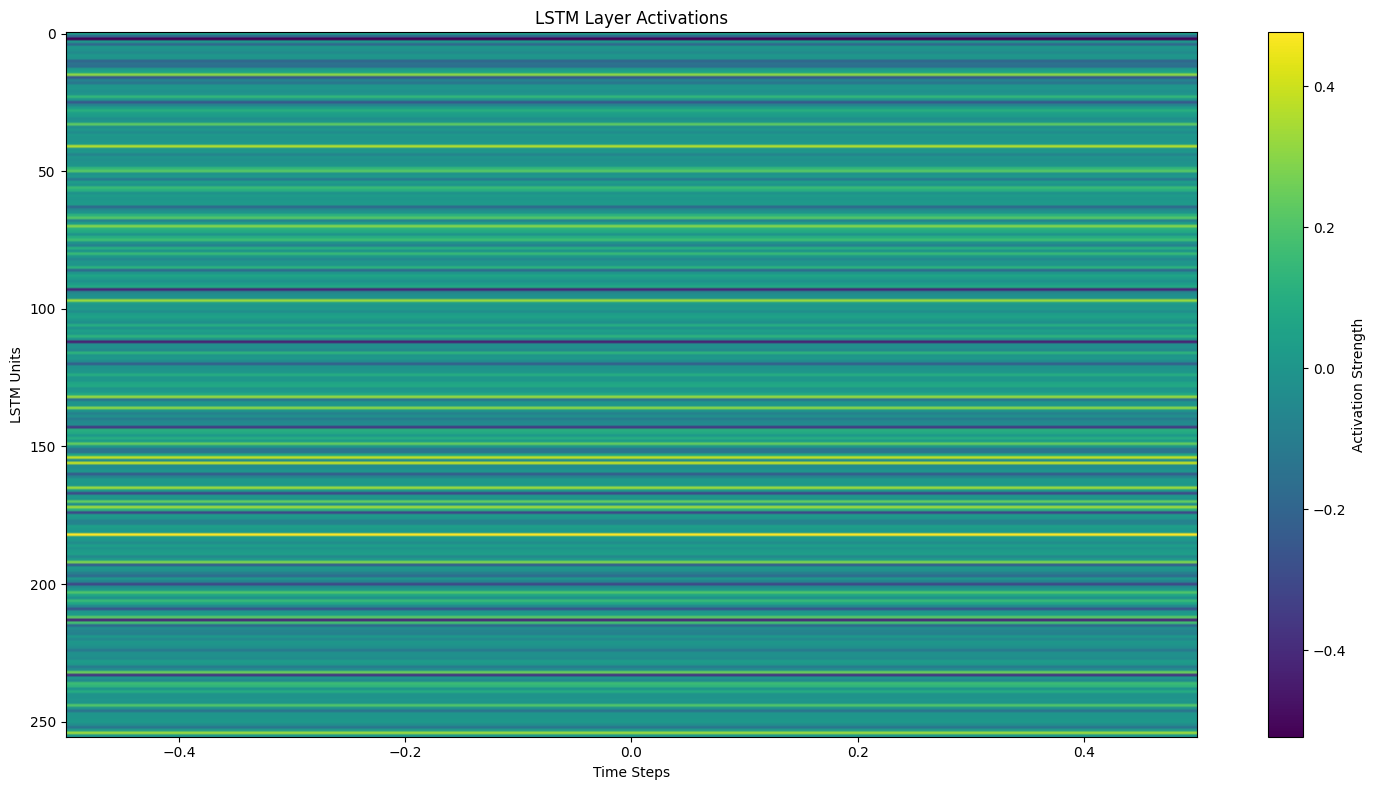

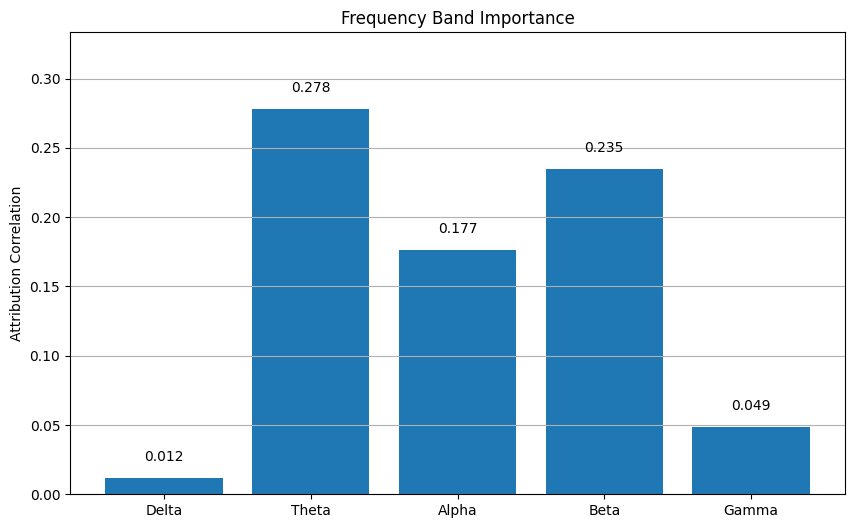


Analyzing Feet - Sample 5/5


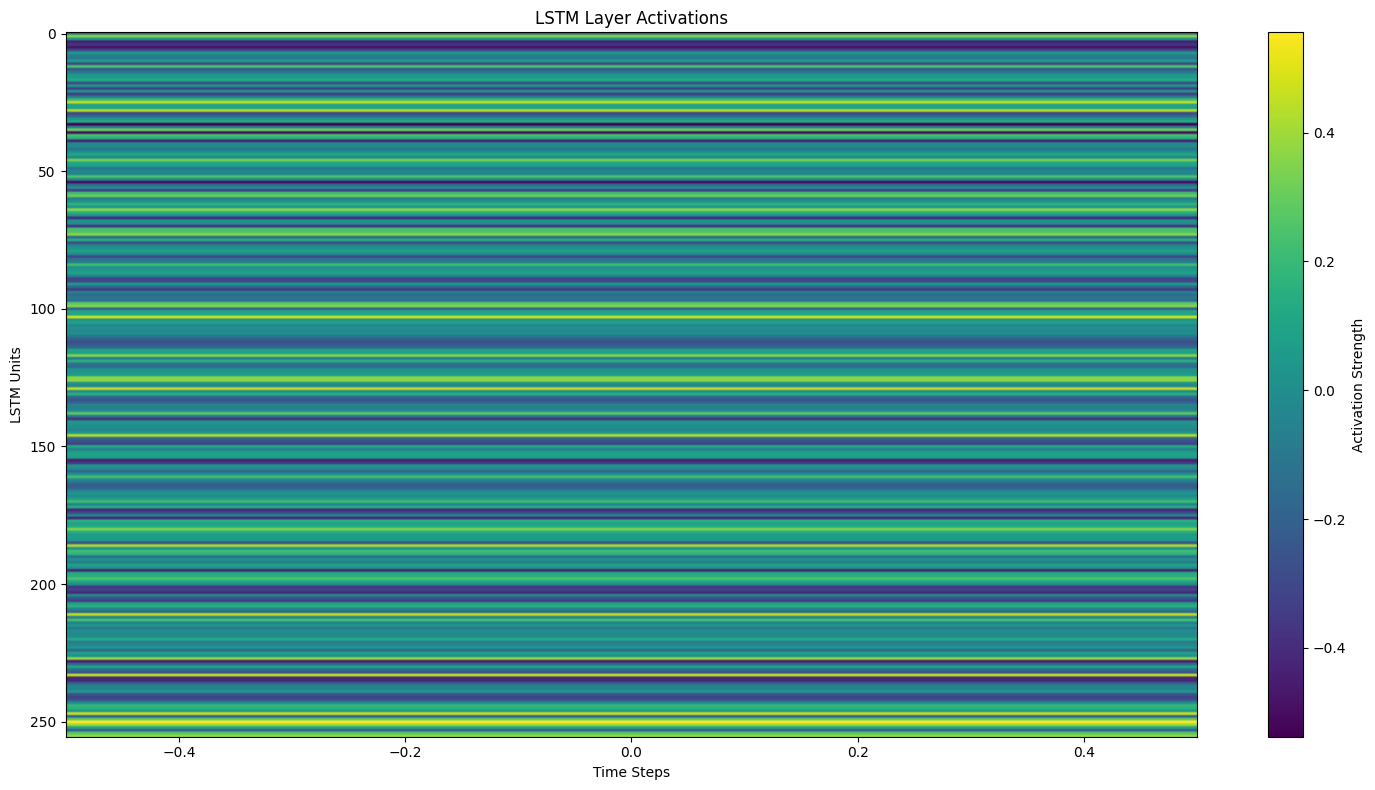

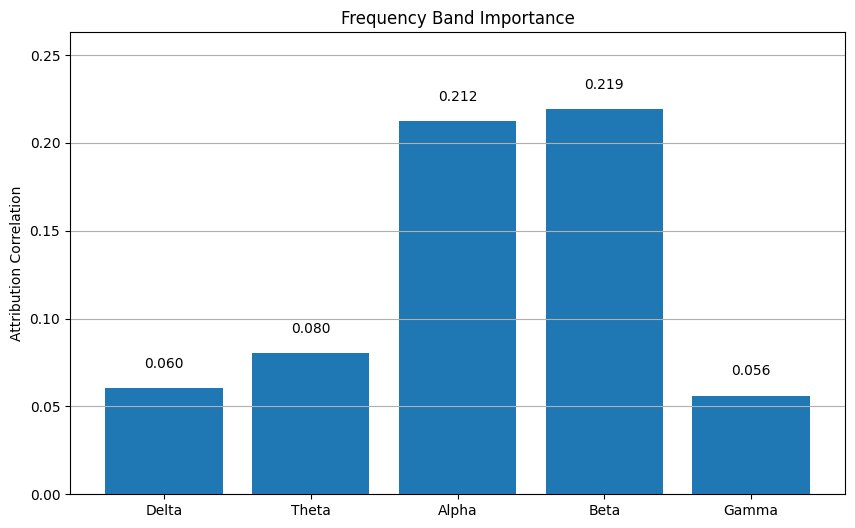


Channel Importance for Feet


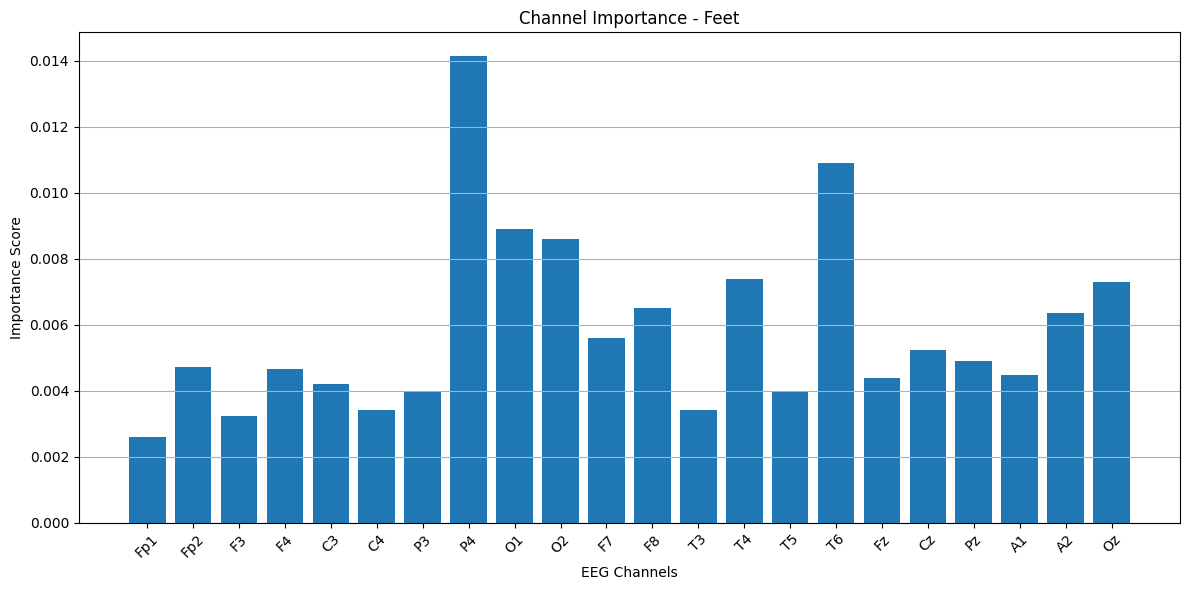


Attributions Over Time for Feet


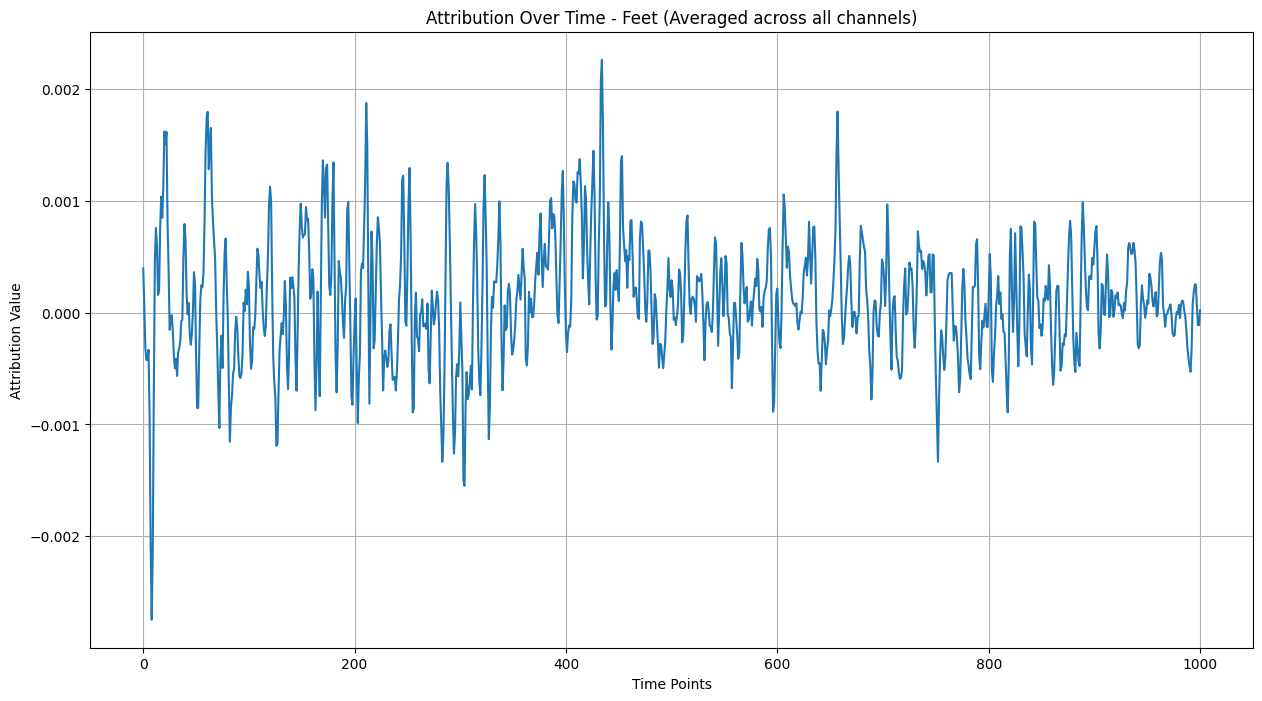


Topographic Attribution Map for Feet


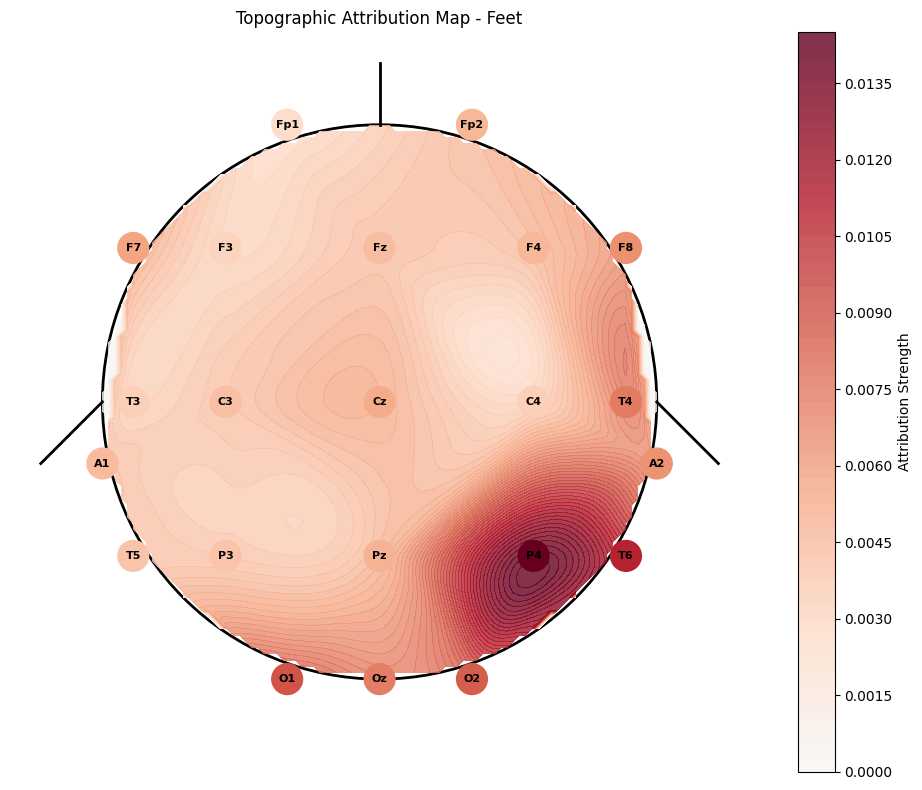


Most Influential Time Points for Feet


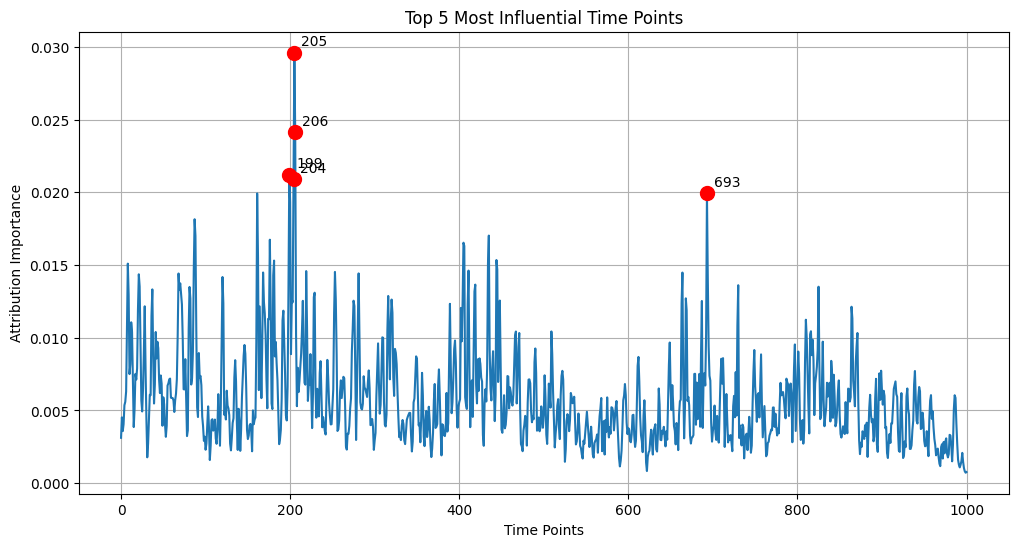


Frequency Band Importance for Feet


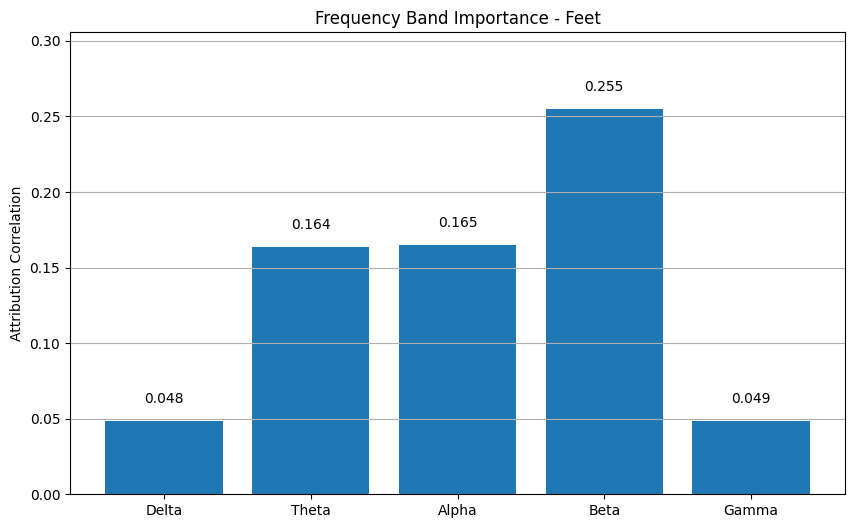


Time-Frequency Analysis for Feet


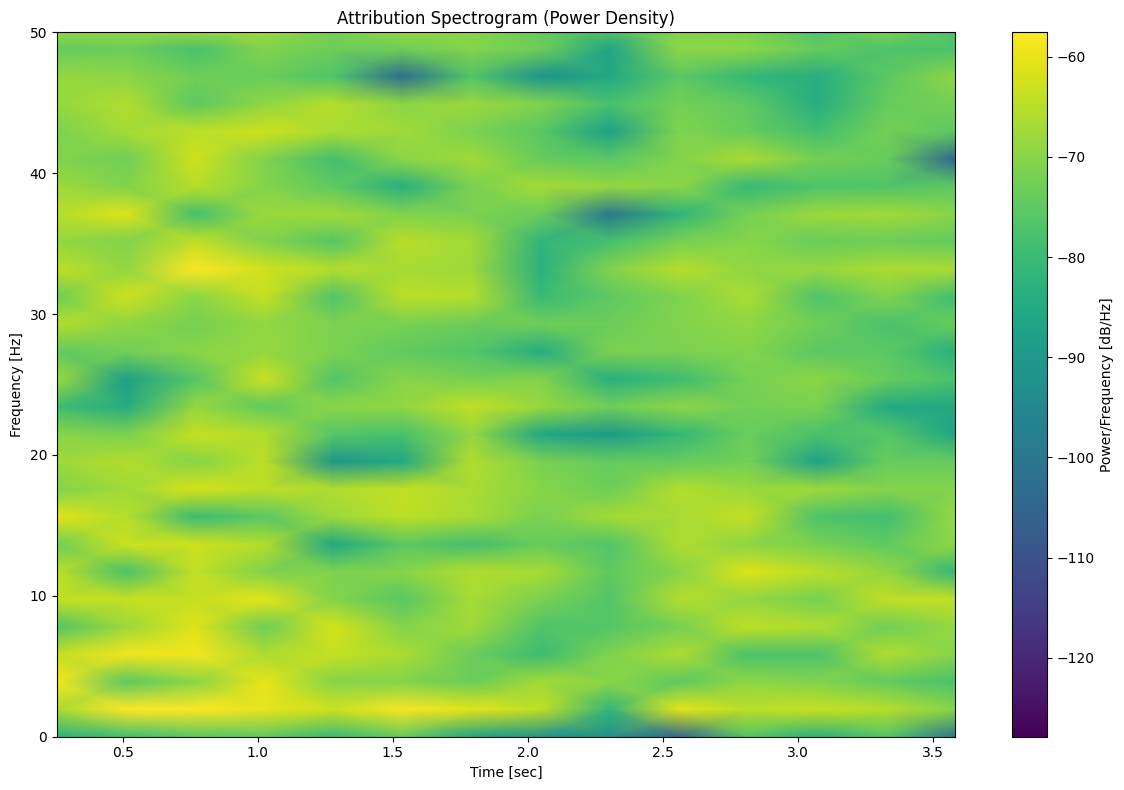

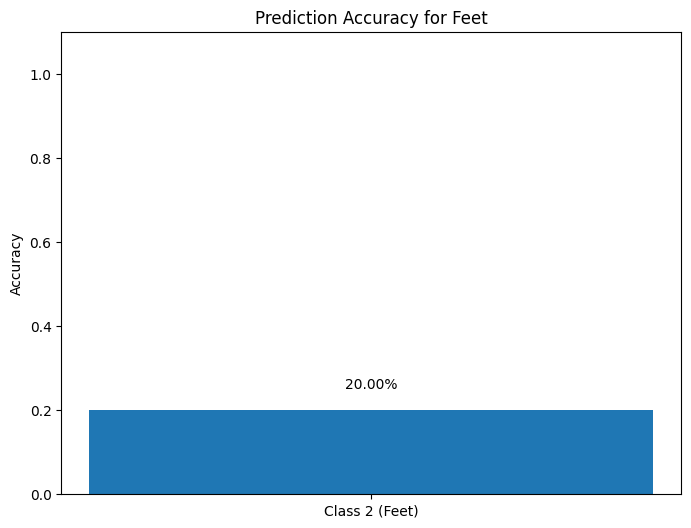


ANALYZING CLASS: Tongue

Analyzing Tongue - Sample 1/5


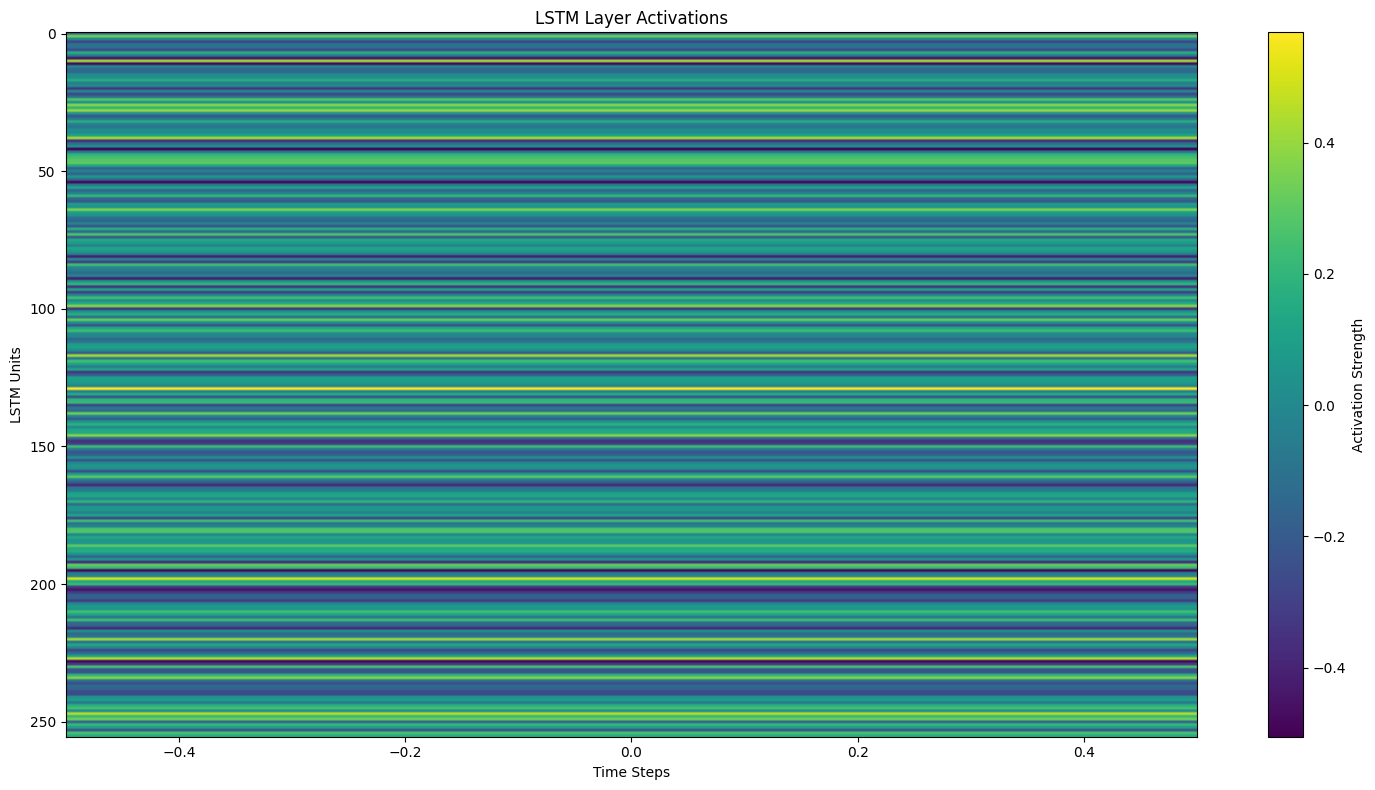

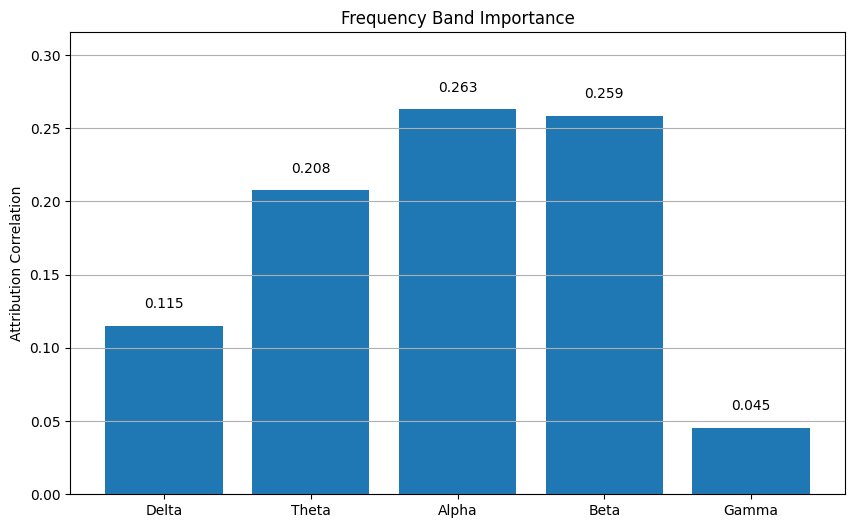


Analyzing Tongue - Sample 2/5


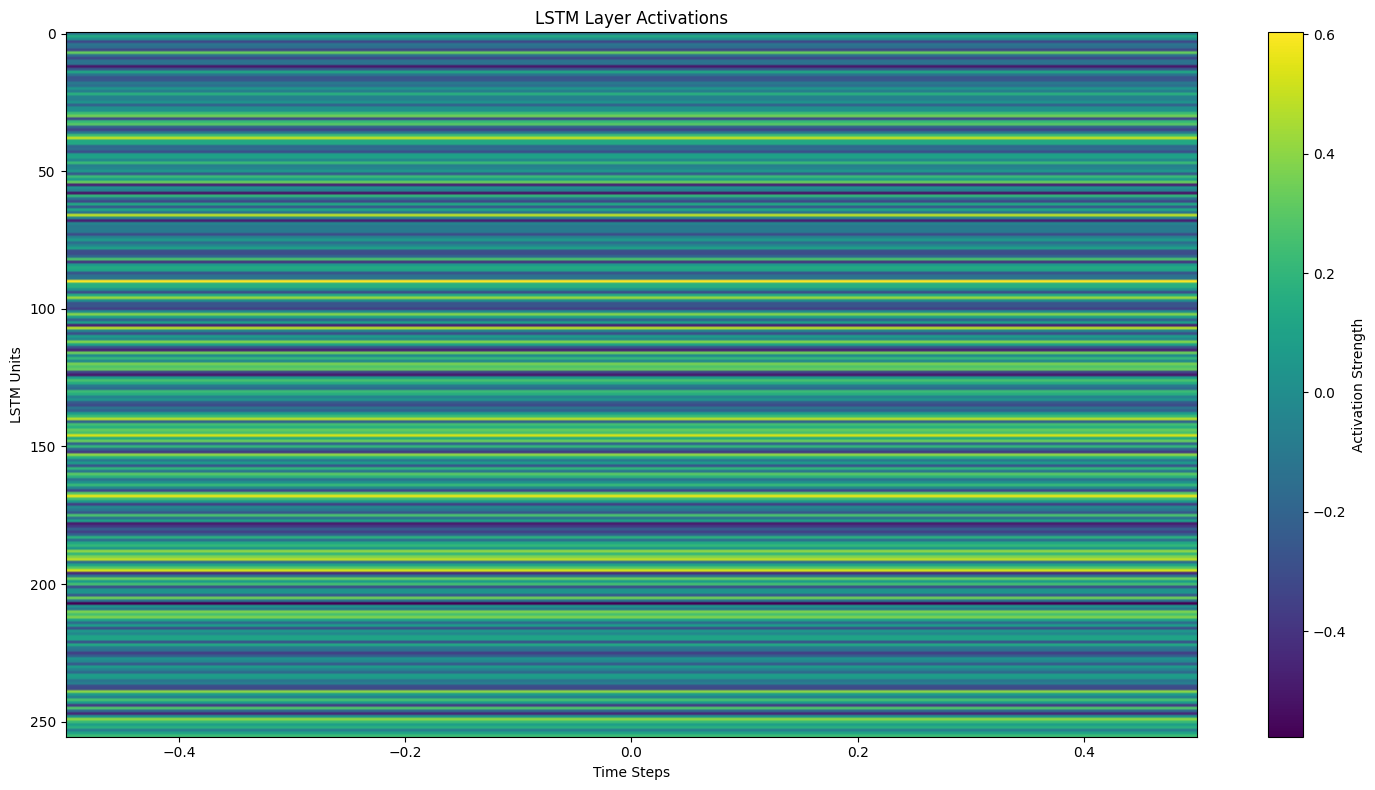

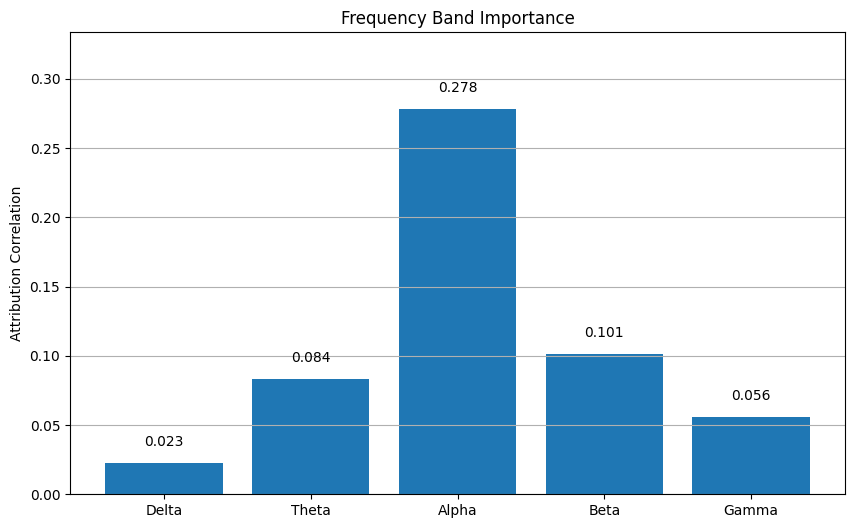


Analyzing Tongue - Sample 3/5


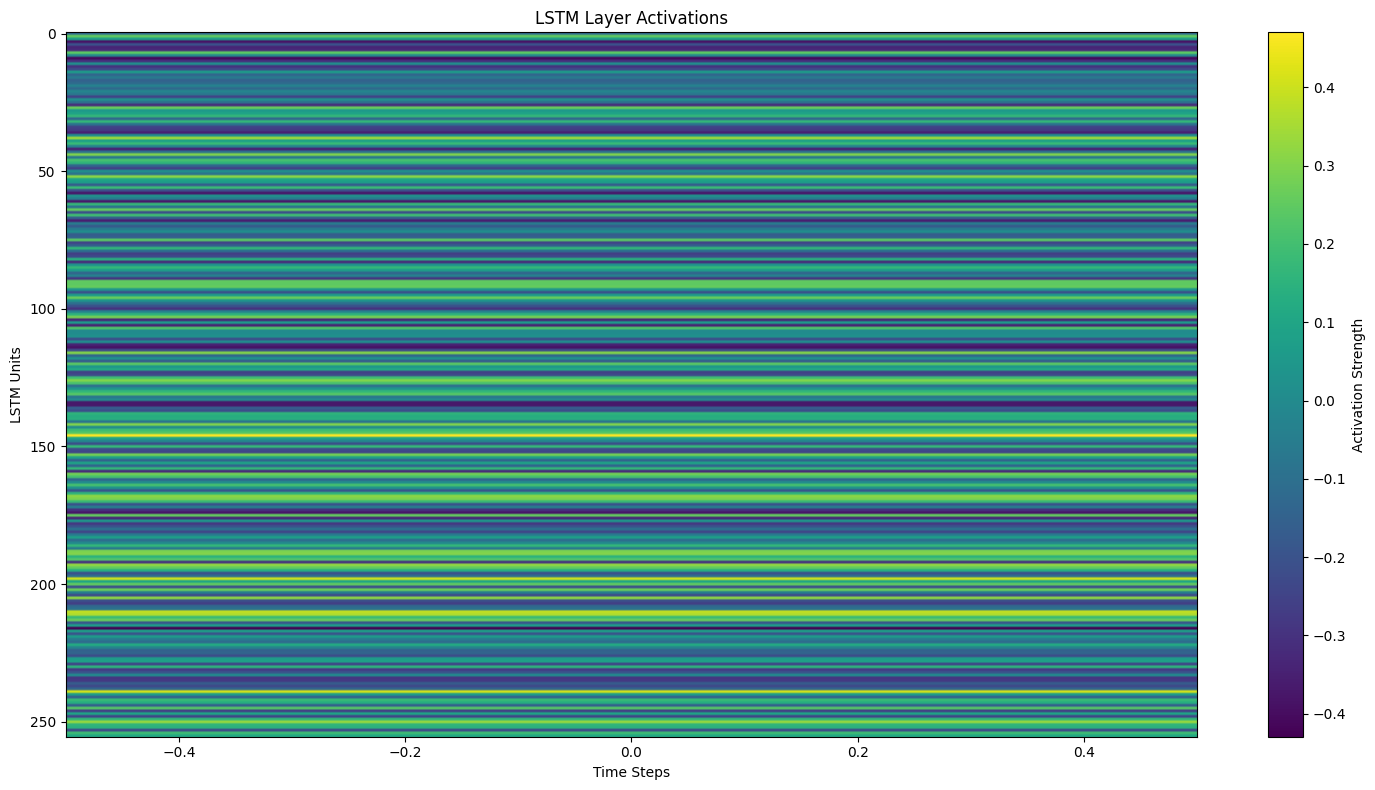

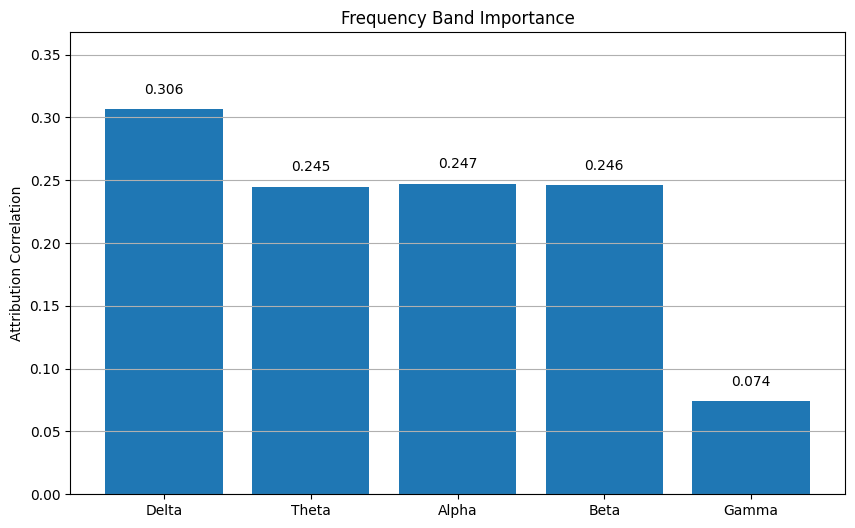


Analyzing Tongue - Sample 4/5


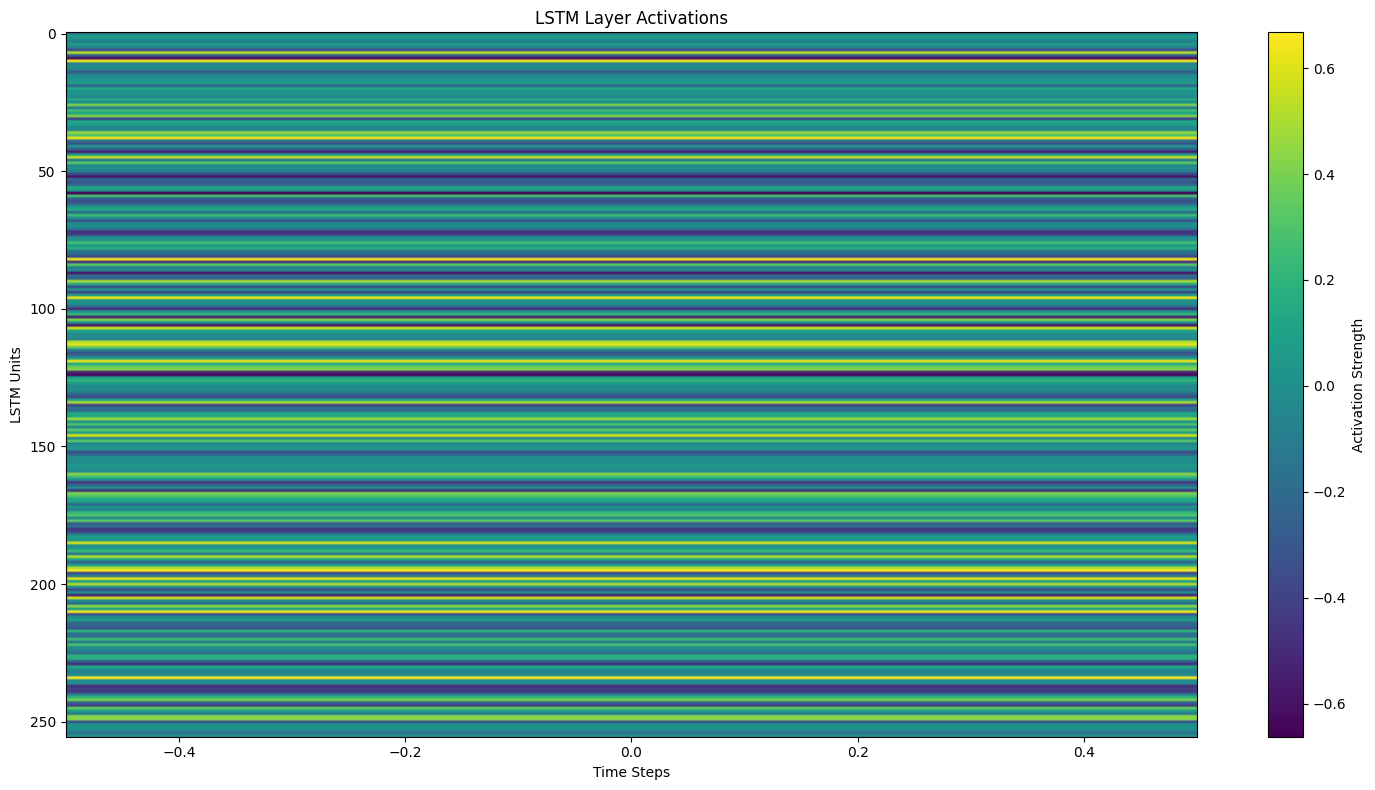

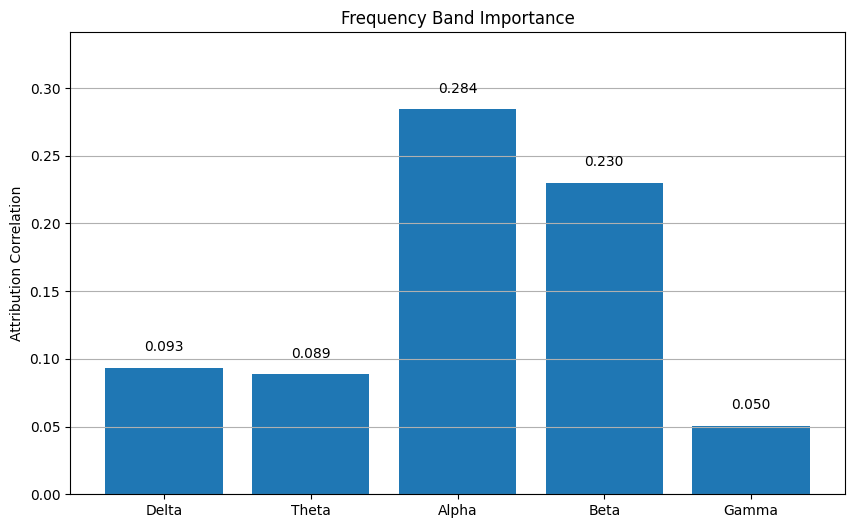


Analyzing Tongue - Sample 5/5


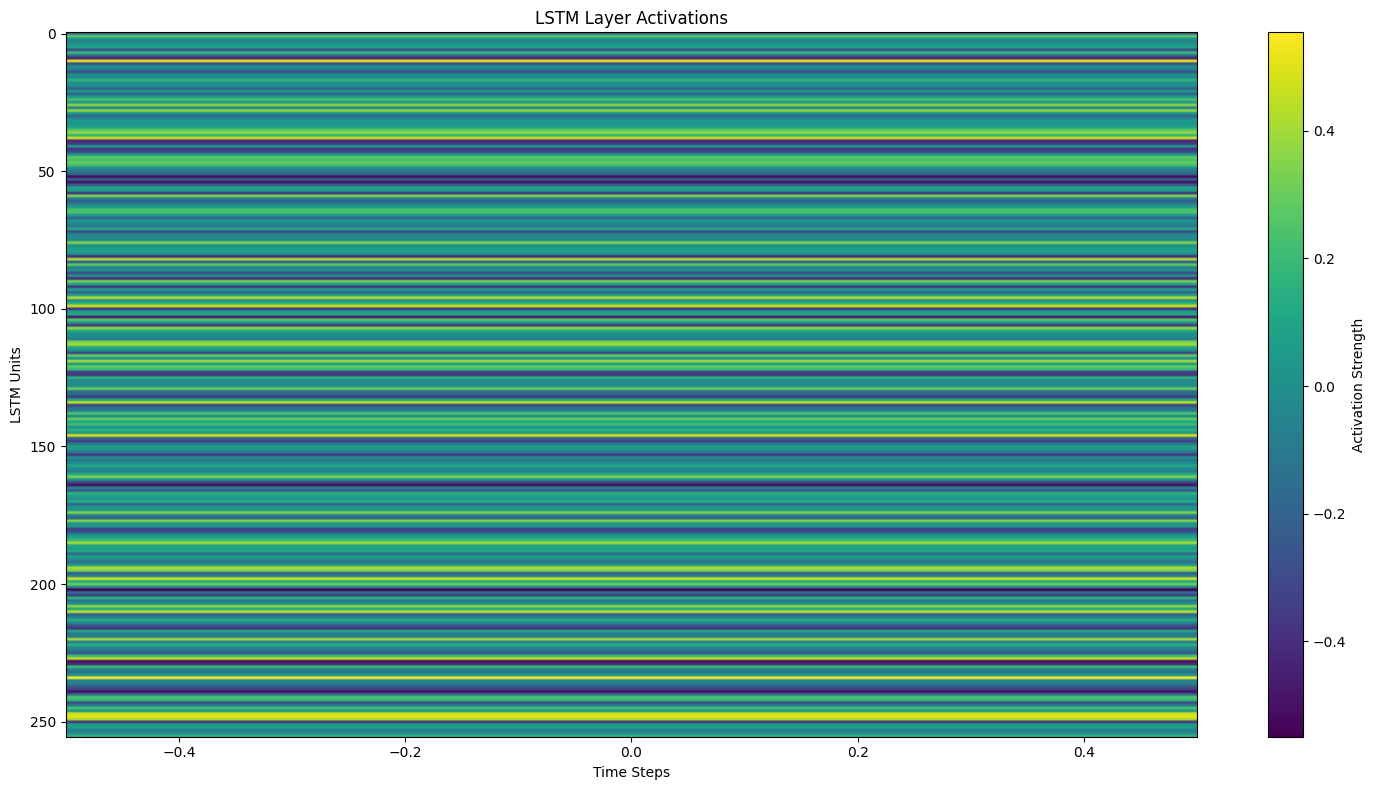

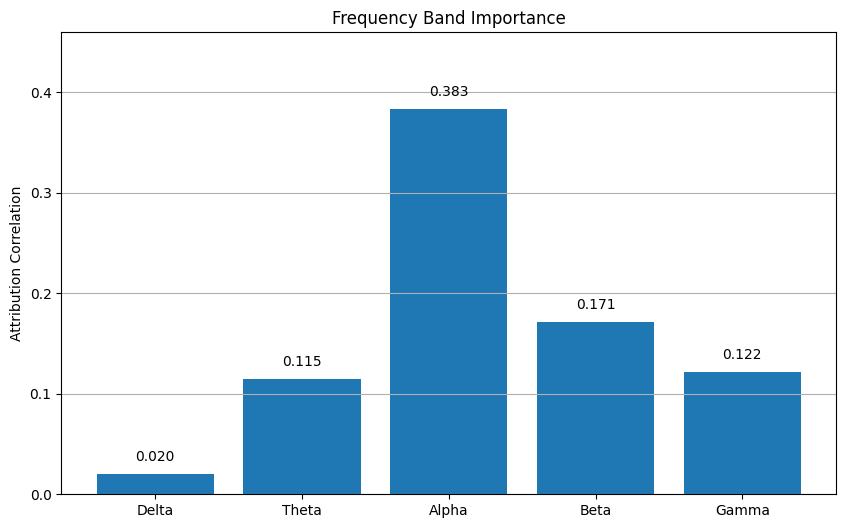


Channel Importance for Tongue


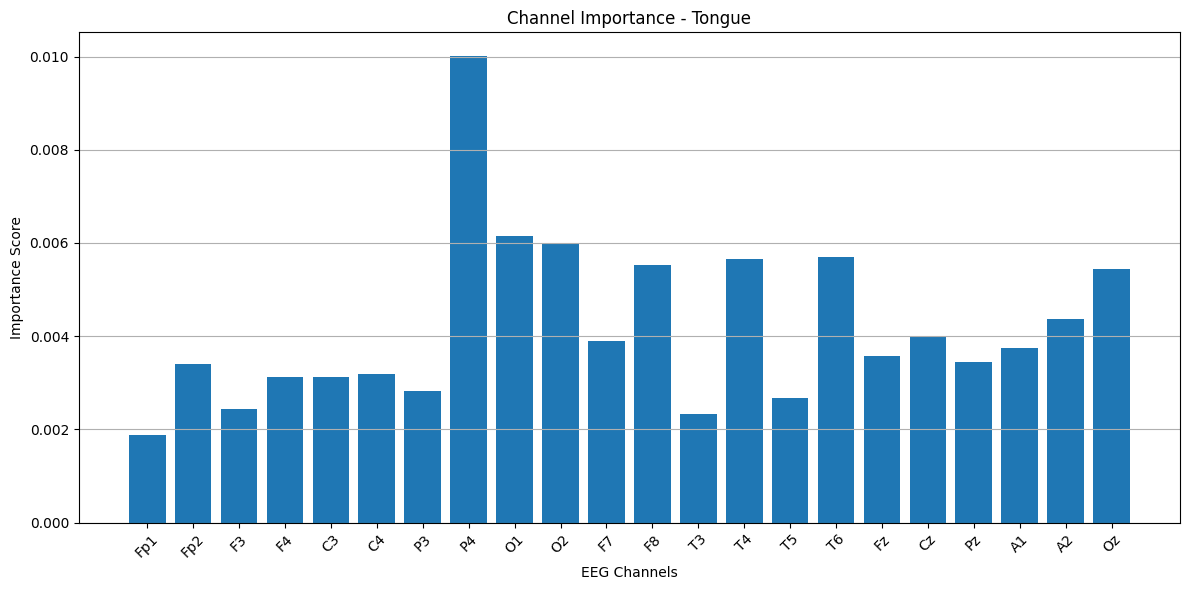


Attributions Over Time for Tongue


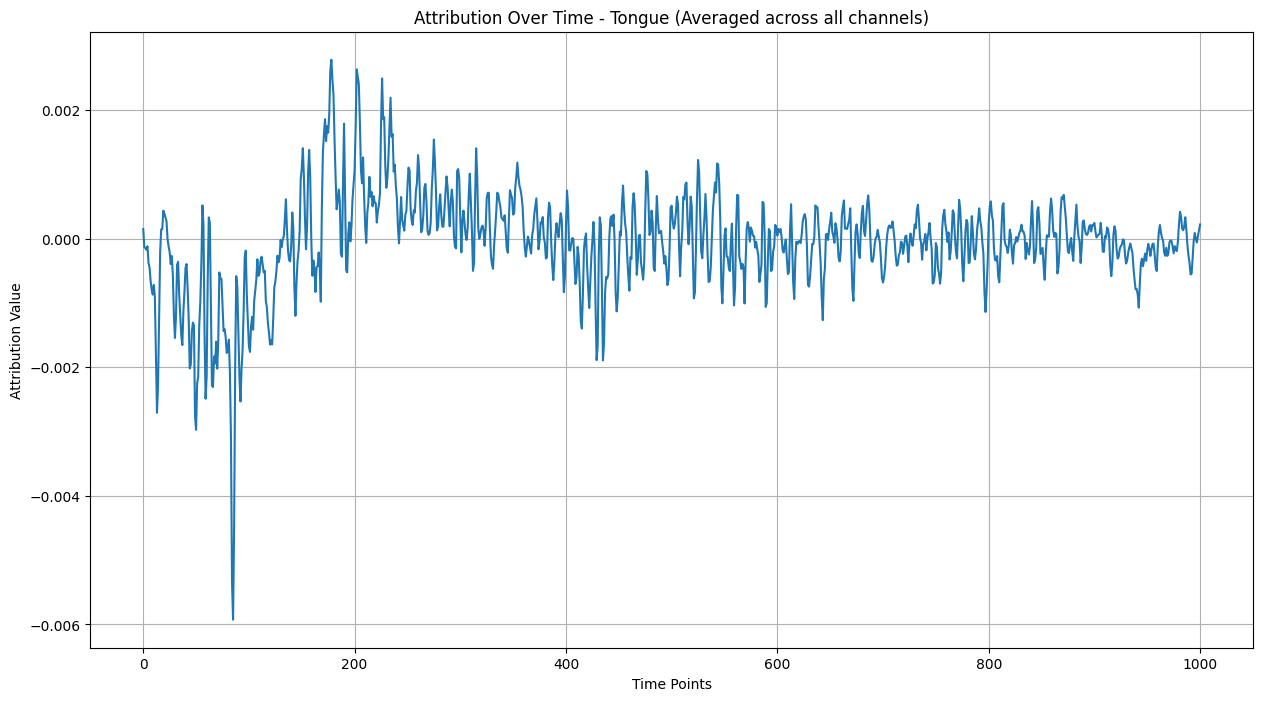


Topographic Attribution Map for Tongue


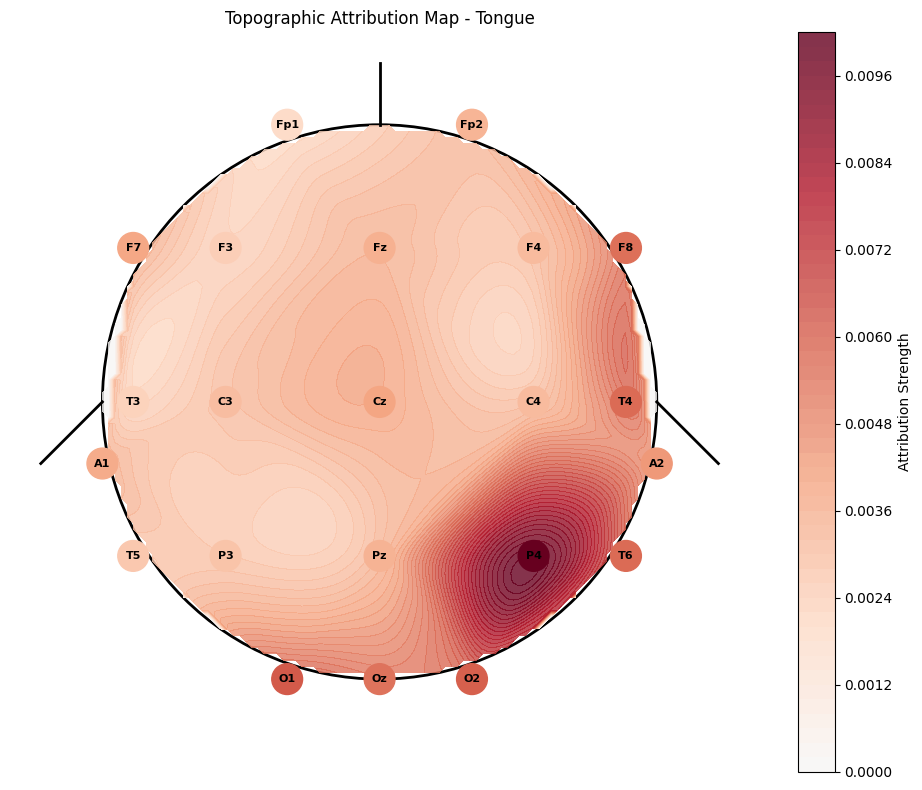


Most Influential Time Points for Tongue


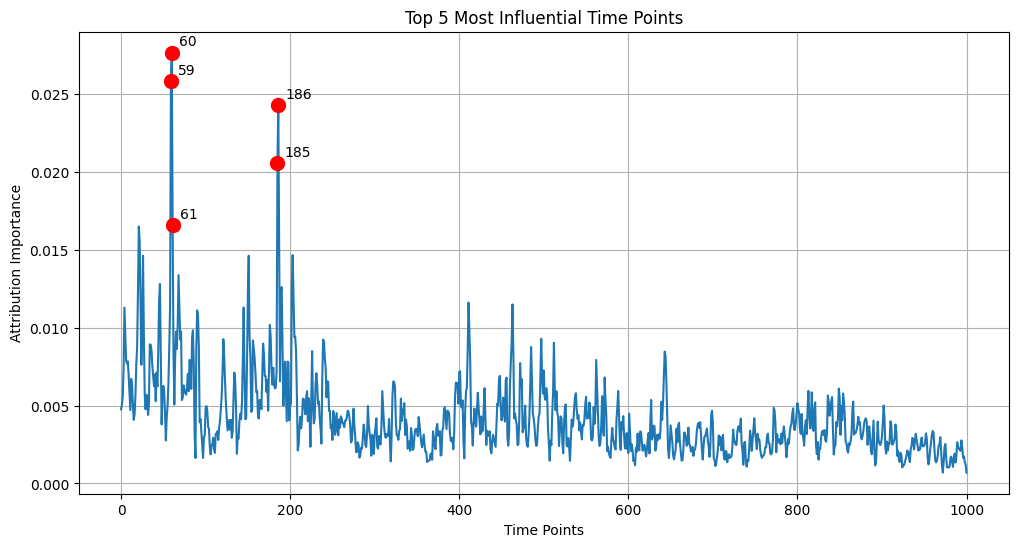


Frequency Band Importance for Tongue


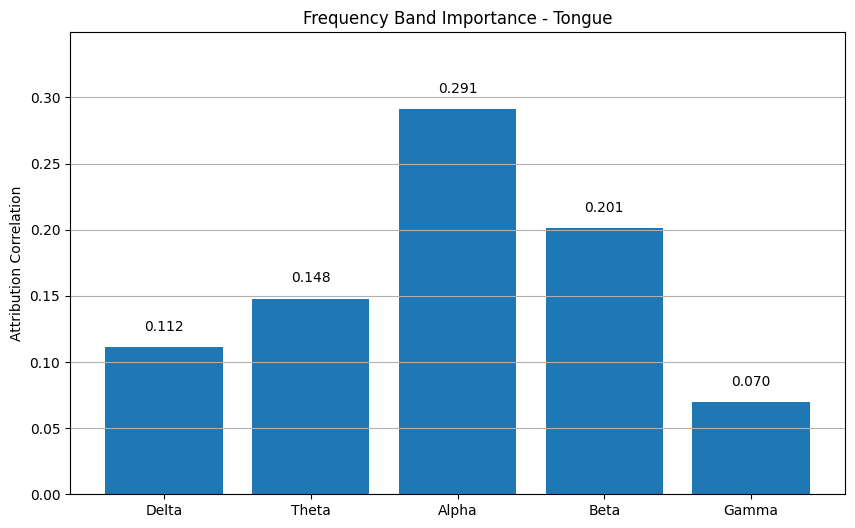


Time-Frequency Analysis for Tongue


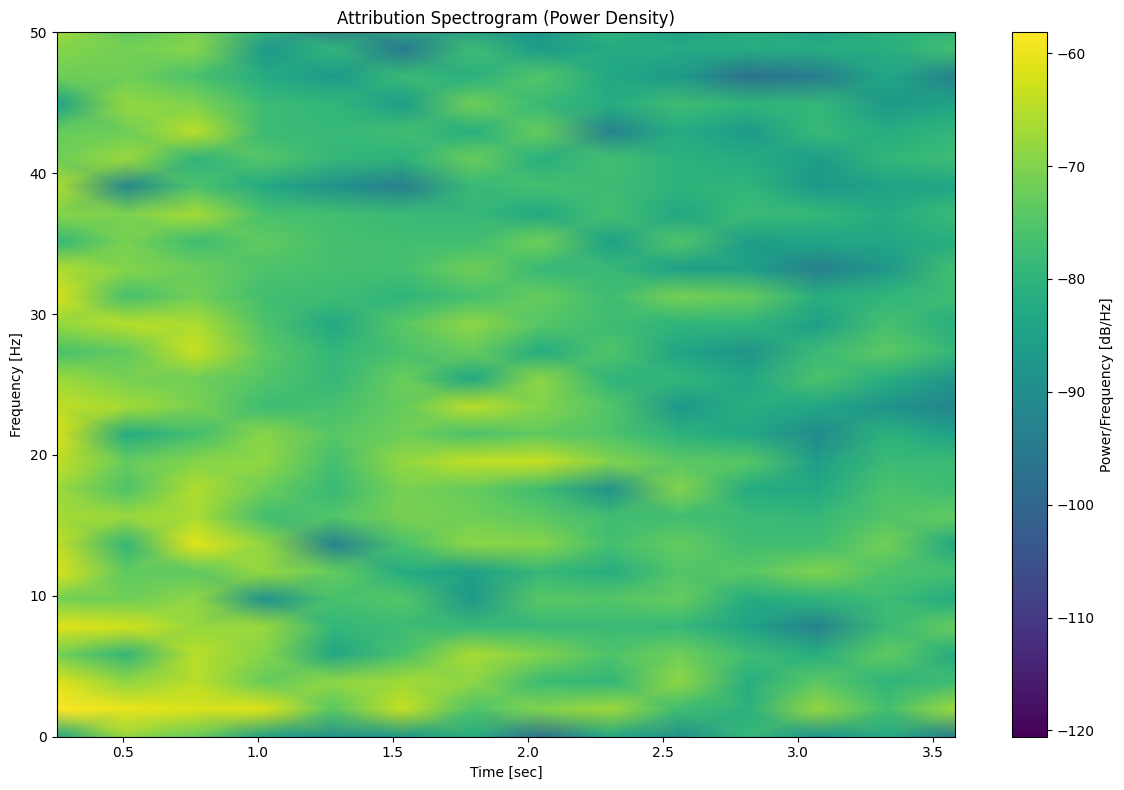

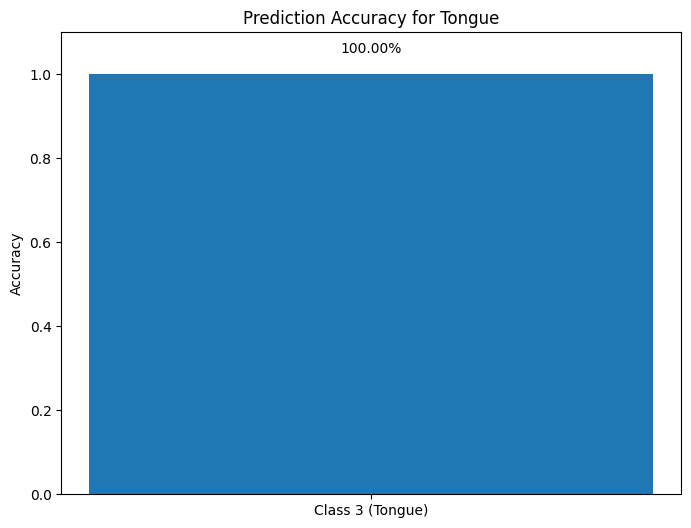


COMPARATIVE ANALYSIS ACROSS ALL CLASSES

Comparing Channel Importance Across Classes


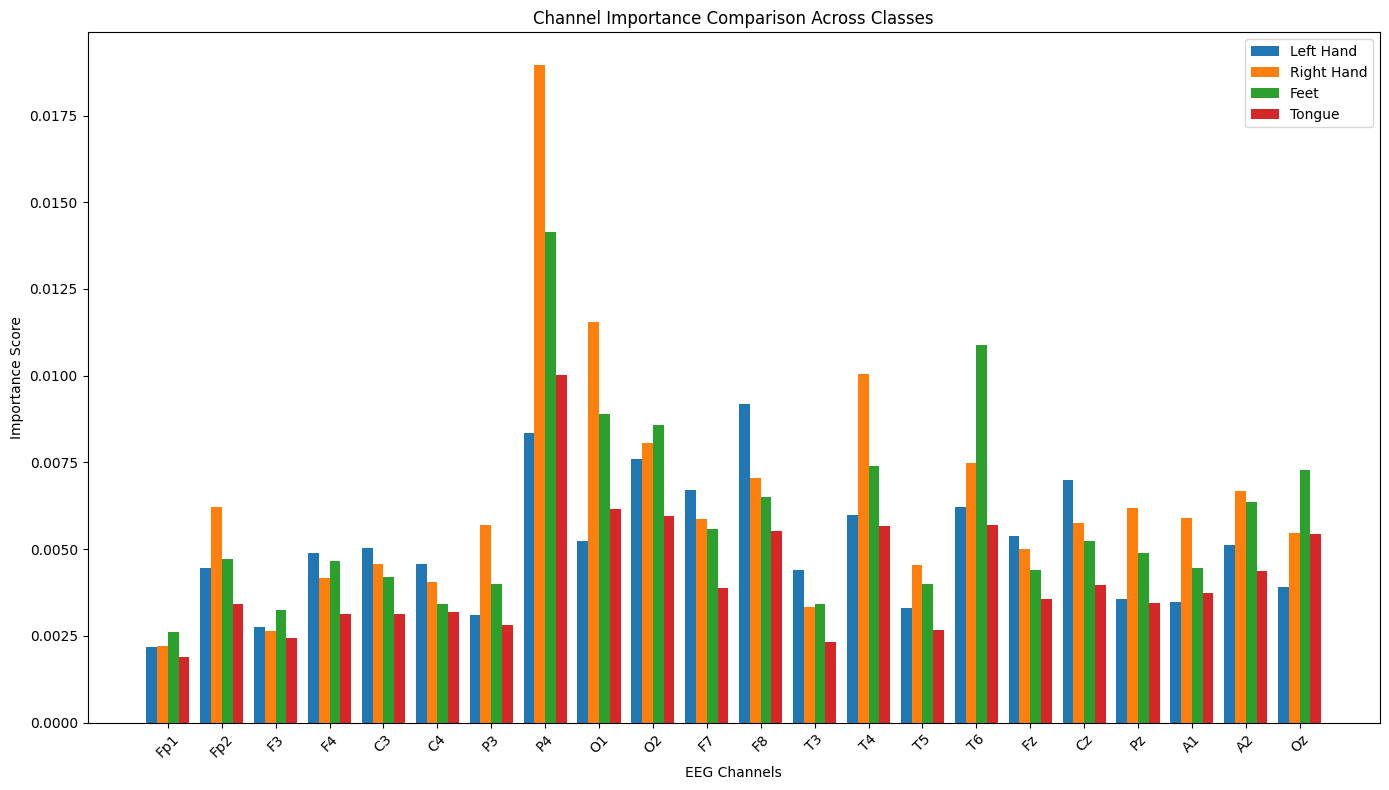

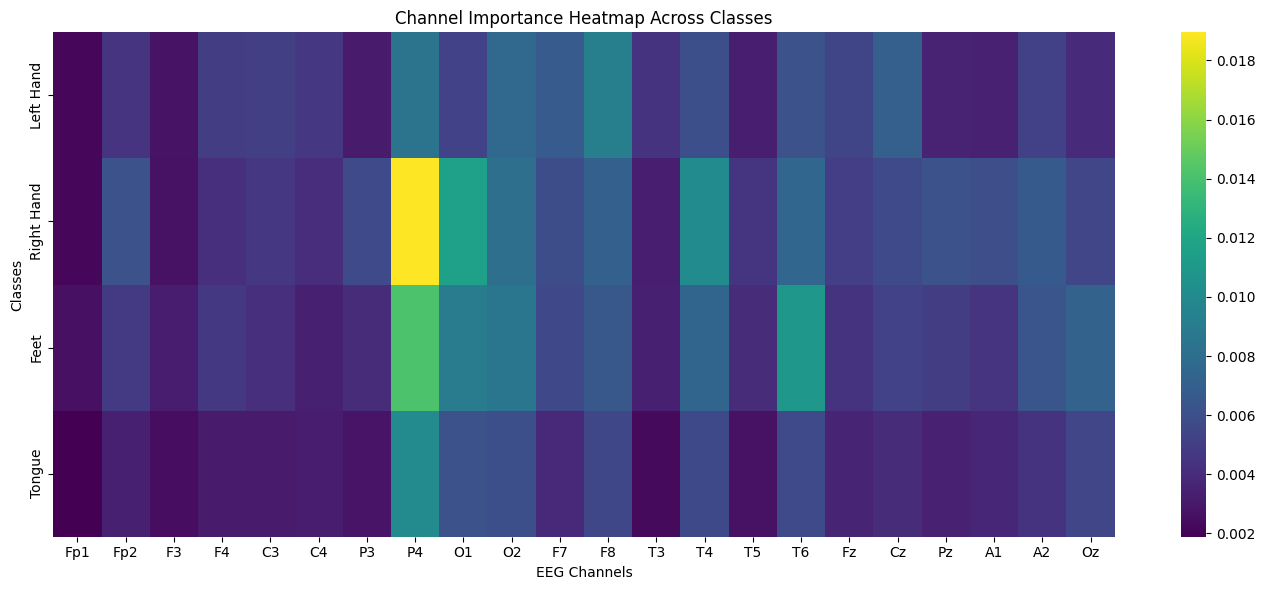


Comparing Frequency Band Importance Across Classes


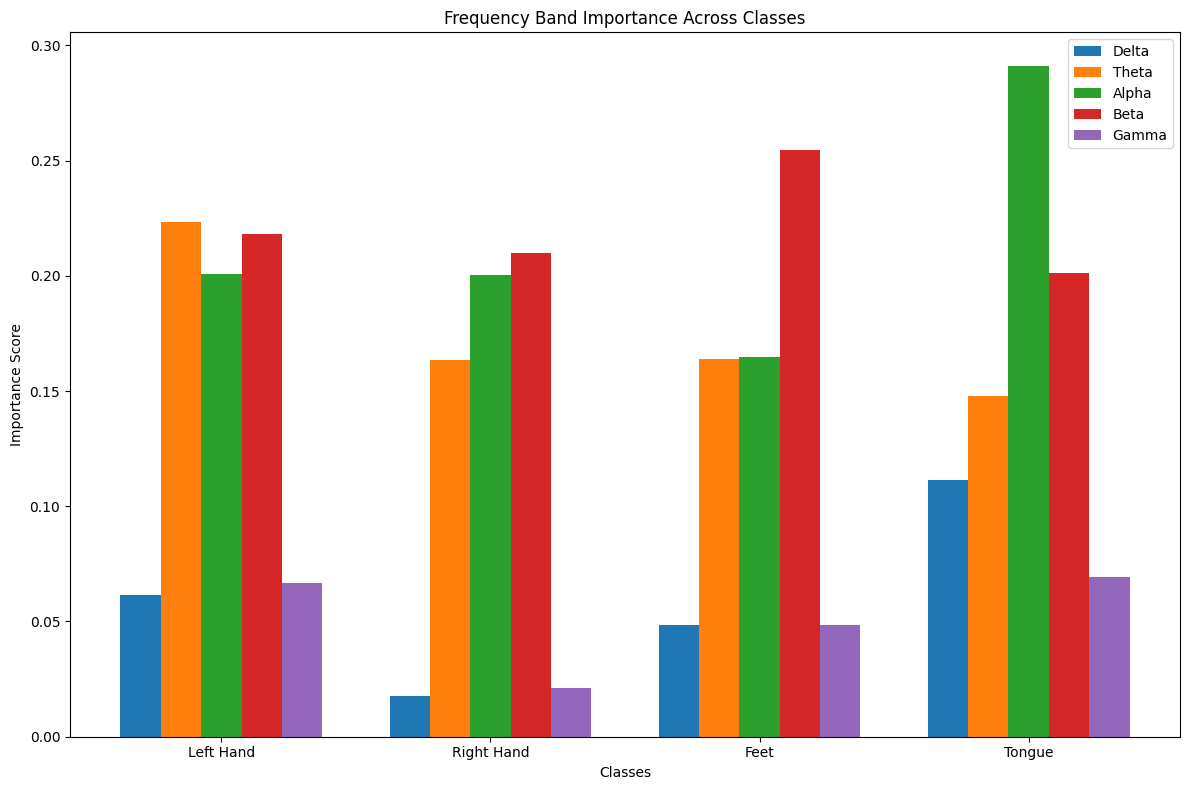

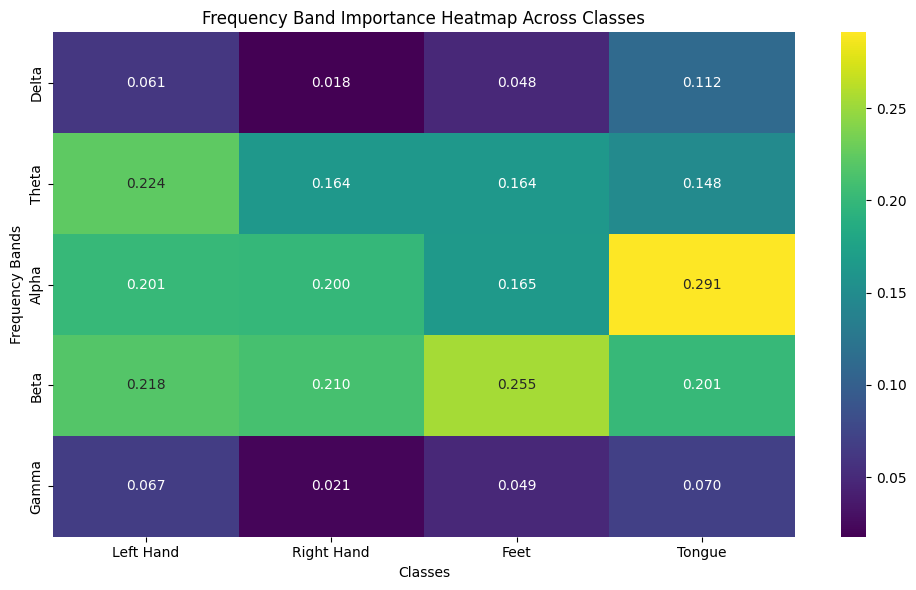


Comparing Attribution Patterns Over Time Across Classes


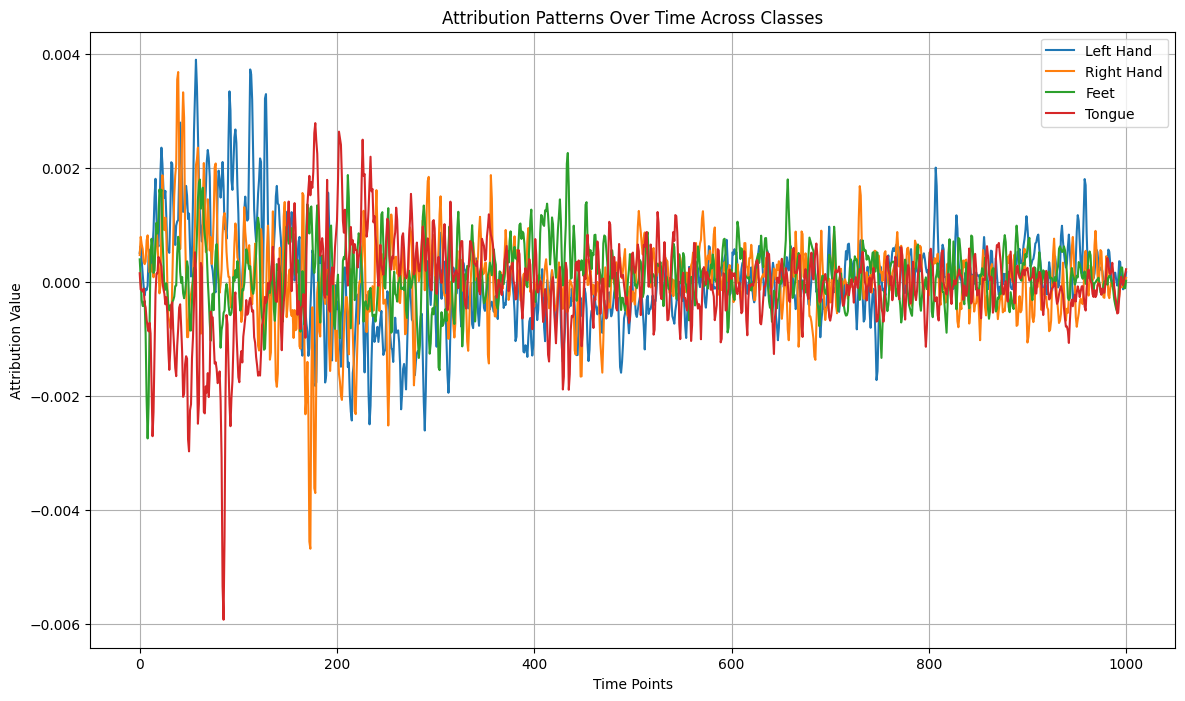


Comparing Topographic Attribution Maps Across Classes


<ipython-input-40-6d835d25f202>:399: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar


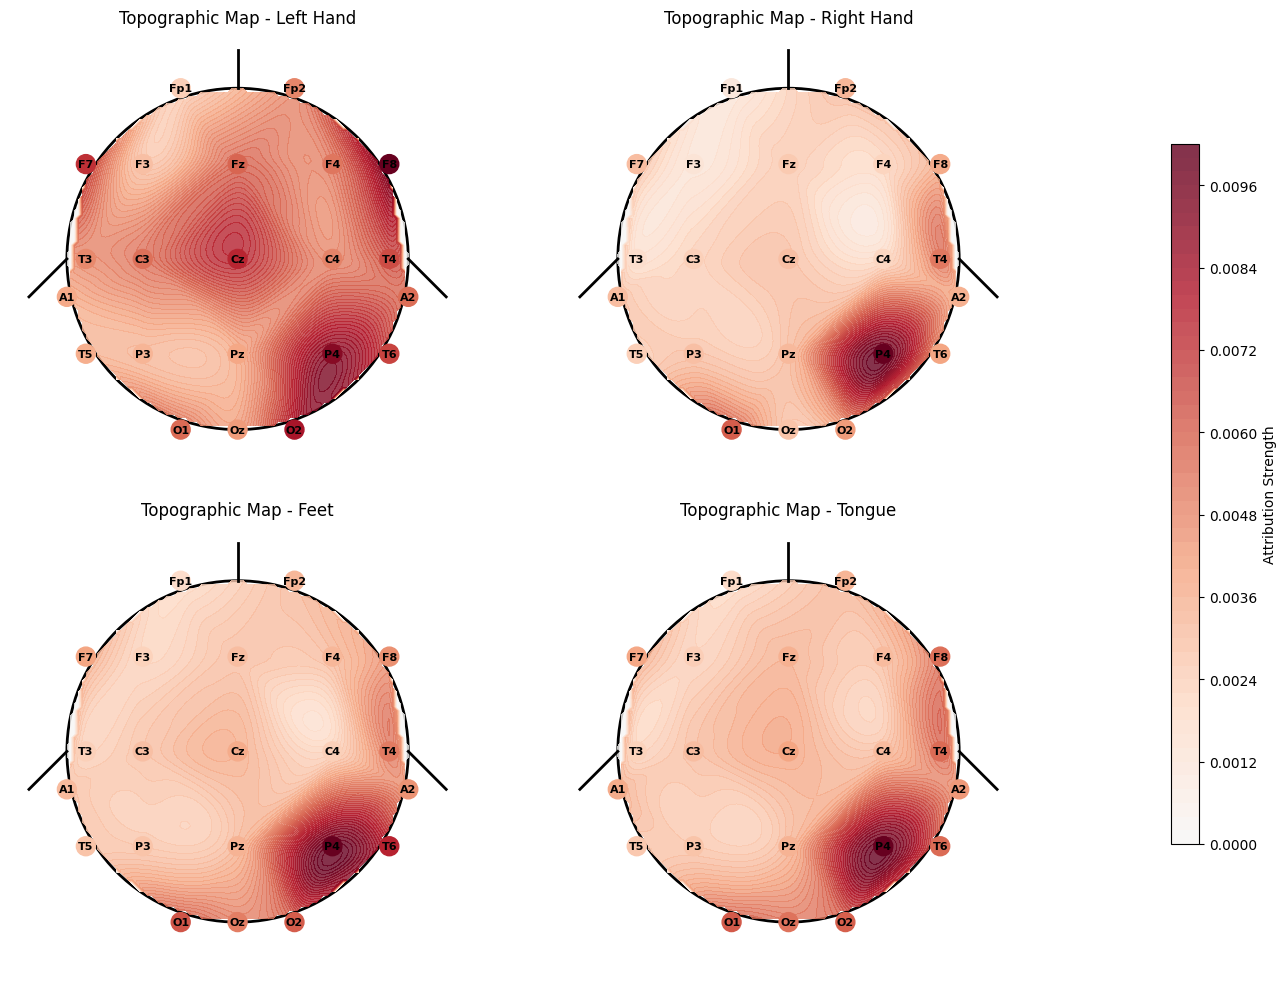


Class-specific XAI analysis complete!


In [40]:
class EEGClassExplainer(EEGExplainer):
    def __init__(self, model, device, class_names=None):
        """
        Initialize the class-specific EEG explainer with a trained model

        Args:
            model: Trained PyTorch model
            device: Device to run computations on (CPU or CUDA)
            class_names: Names of the classes for plotting
        """
        super().__init__(model, device, class_names)

    def analyze_all_classes(self, test_dataset, num_samples=5):
        """
        Analyze samples from each class separately and visualize class-specific patterns

        Args:
            test_dataset: Test dataset containing samples from all classes
            num_samples: Number of samples to analyze per class
        """
        # Create data loader to sample data
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

        # Collect samples for each class
        class_samples = {i: [] for i in range(len(self.class_names))}

        for inputs, labels in test_loader:
            # Process only until we have enough samples for each class
            if all(len(class_samples[i]) >= num_samples for i in range(len(self.class_names))):
                break

            for i, label in enumerate(labels):
                label = label.item()
                if len(class_samples[label]) < num_samples:
                    input_tensor = inputs[i:i+1]
                    class_samples[label].append(input_tensor)

        # Analyze each class separately
        class_results = {}

        for class_idx, samples in class_samples.items():
            if not samples:
                continue

            print(f"\n{'='*80}")
            print(f"ANALYZING CLASS: {self.class_names[class_idx]}")
            print(f"{'='*80}")

            # Calculate and store results for this class
            class_results[class_idx] = self._analyze_class(samples, class_idx)

        # Generate comparative visualizations across classes
        self._generate_class_comparisons(class_results)

        return class_results

    def _analyze_class(self, samples, class_idx):
        """Analyze samples from a specific class"""
        results = {
            "samples": samples,
            "predictions": [],
            "attributions": {
                "integrated_gradients": [],
                "deep_lift": [],
                "occlusion": []
            },
            "lstm_features": [],
            "band_importance": []
        }

        # Analyze each sample in this class
        for i, sample in enumerate(samples):
            print(f"\nAnalyzing {self.class_names[class_idx]} - Sample {i+1}/{len(samples)}")

            # Make prediction
            prediction = self.predict_sample(sample)
            results["predictions"].append(prediction)

            # Calculate attributions using different methods
            ig_attr = self.integrated_gradients(sample, target_class=class_idx)
            results["attributions"]["integrated_gradients"].append(ig_attr)

            dl_attr = self.deep_lift(sample, target_class=class_idx)
            results["attributions"]["deep_lift"].append(dl_attr)

            occl_attr = self.occlusion_analysis(sample, target_class=class_idx)
            results["attributions"]["occlusion"].append(occl_attr)

            # Get LSTM features
            lstm_output = self.get_lstm_feature_importance(sample)
            results["lstm_features"].append(lstm_output)

            # Analyze frequency bands
            band_importance = self.analyze_frequency_bands(sample, ig_attr)
            results["band_importance"].append(band_importance)

        # Calculate average attributions across samples
        avg_ig = torch.mean(torch.stack([attr for attr in results["attributions"]["integrated_gradients"]]), dim=0)
        avg_dl = torch.mean(torch.stack([attr for attr in results["attributions"]["deep_lift"]]), dim=0)

        # Store average attributions
        results["avg_attributions"] = {
            "integrated_gradients": avg_ig,
            "deep_lift": avg_dl
        }

        # Calculate average frequency band importance
        avg_band_importance = {}
        for band in results["band_importance"][0].keys():
            avg_band_importance[band] = np.mean([results["band_importance"][i][band] for i in range(len(samples))])

        results["avg_band_importance"] = avg_band_importance

        # Visualize results for this class
        self._visualize_class_results(results, class_idx)

        return results

    def _visualize_class_results(self, results, class_idx):
        """Generate visualizations for a specific class"""
        class_name = self.class_names[class_idx]

        # 1. Visualize average channel importance
        print(f"\nChannel Importance for {class_name}")
        self.plot_channel_importance(
            results["avg_attributions"]["integrated_gradients"],
            title=f"Channel Importance - {class_name}"
        )

        # 2. Visualize average attributions over time
        print(f"\nAttributions Over Time for {class_name}")
        self.plot_attributions_over_time(
            results["avg_attributions"]["integrated_gradients"],
            title=f"Attribution Over Time - {class_name}"
        )

        # 3. Visualize topographic map
        print(f"\nTopographic Attribution Map for {class_name}")
        self.plot_topomap_attribution(
            results["avg_attributions"]["integrated_gradients"],
            title=f"Topographic Attribution Map - {class_name}"
        )

        # 4. Visualize most influential time points
        print(f"\nMost Influential Time Points for {class_name}")
        self.analyze_most_influential_time_points(
            results["avg_attributions"]["integrated_gradients"],
            top_n=5
        )

        # 5. Visualize frequency band importance
        print(f"\nFrequency Band Importance for {class_name}")
        plt.figure(figsize=(10, 6))
        bands = list(results["avg_band_importance"].keys())
        values = [results["avg_band_importance"][band] for band in bands]

        bars = plt.bar(bands, values)
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom')

        plt.title(f"Frequency Band Importance - {class_name}")
        plt.ylabel("Attribution Correlation")
        plt.grid(True, axis='y')
        plt.ylim(0, max(values) * 1.2)
        plt.show()

        # 6. Visualize time-frequency representation
        print(f"\nTime-Frequency Analysis for {class_name}")
        self.plot_time_frequency_attribution(
            results["avg_attributions"]["integrated_gradients"],
            sampling_rate=250
        )

        # 7. Visualize prediction accuracy for this class
        correct_predictions = sum(1 for pred in results["predictions"]
                               if pred["class_idx"] == class_idx)
        accuracy = correct_predictions / len(results["predictions"])

        plt.figure(figsize=(8, 6))
        plt.bar([f"Class {class_idx} ({class_name})"], [accuracy])
        plt.title(f"Prediction Accuracy for {class_name}")
        plt.ylabel("Accuracy")
        plt.ylim(0, 1.1)
        plt.text(0, accuracy + 0.05, f"{accuracy:.2%}", ha='center')
        plt.show()

    def _generate_class_comparisons(self, class_results):
        """Generate visualizations comparing all classes"""
        print("\n" + "="*80)
        print("COMPARATIVE ANALYSIS ACROSS ALL CLASSES")
        print("="*80)

        # 1. Compare channel importance across classes
        self._compare_channel_importance(class_results)

        # 2. Compare frequency band importance across classes
        self._compare_frequency_bands(class_results)

        # 3. Compare activation patterns over time
        self._compare_time_patterns(class_results)

        # 4. Compare topographic maps
        self._compare_topographic_maps(class_results)

    def _compare_channel_importance(self, class_results):
        """Compare channel importance across all classes"""
        print("\nComparing Channel Importance Across Classes")

        # Calculate channel importance for each class
        channel_importance = {}
        for class_idx, results in class_results.items():
            attr_np = results["avg_attributions"]["integrated_gradients"].squeeze().detach().cpu().numpy()
            channel_importance[class_idx] = np.mean(np.abs(attr_np), axis=1)

        # Plot comparison
        plt.figure(figsize=(14, 8))

        bar_width = 0.2
        index = np.arange(len(self.channel_names))

        for i, (class_idx, importance) in enumerate(channel_importance.items()):
            plt.bar(index + i*bar_width, importance, bar_width,
                    label=f"{self.class_names[class_idx]}")

        plt.xlabel('EEG Channels')
        plt.ylabel('Importance Score')
        plt.title('Channel Importance Comparison Across Classes')
        # FIX: Use channel_importance instead of class_importance
        plt.xticks(index + bar_width * (len(channel_importance) - 1) / 2, self.channel_names, rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Create a heatmap for more clear visualization
        plt.figure(figsize=(14, 6))
        importance_matrix = np.array([importance for importance in channel_importance.values()])

        sns.heatmap(importance_matrix, cmap='viridis',
                    xticklabels=self.channel_names,
                    yticklabels=[self.class_names[idx] for idx in channel_importance.keys()])
        plt.title('Channel Importance Heatmap Across Classes')
        plt.xlabel('EEG Channels')
        plt.ylabel('Classes')
        plt.tight_layout()
        plt.show()

    def _compare_frequency_bands(self, class_results):
        """Compare frequency band importance across all classes"""
        print("\nComparing Frequency Band Importance Across Classes")

        # Collect band importance for each class
        bands = list(class_results[0]["avg_band_importance"].keys())
        band_data = {band: [] for band in bands}
        class_labels = []

        for class_idx, results in class_results.items():
            class_labels.append(self.class_names[class_idx])
            for band in bands:
                band_data[band].append(results["avg_band_importance"][band])

        # Create a grouped bar chart
        plt.figure(figsize=(12, 8))

        bar_width = 0.15
        index = np.arange(len(class_labels))

        for i, band in enumerate(bands):
            plt.bar(index + i*bar_width, band_data[band], bar_width, label=band)

        plt.xlabel('Classes')
        plt.ylabel('Importance Score')
        plt.title('Frequency Band Importance Across Classes')
        plt.xticks(index + bar_width * (len(bands) - 1) / 2, class_labels)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Create a heatmap for clearer visualization
        plt.figure(figsize=(10, 6))
        band_matrix = np.array([band_data[band] for band in bands])

        sns.heatmap(band_matrix, cmap='viridis',
                    xticklabels=class_labels,
                    yticklabels=bands,
                    annot=True, fmt=".3f")
        plt.title('Frequency Band Importance Heatmap Across Classes')
        plt.xlabel('Classes')
        plt.ylabel('Frequency Bands')
        plt.tight_layout()
        plt.show()

    def _compare_time_patterns(self, class_results):
        """Compare attribution patterns over time across all classes"""
        print("\nComparing Attribution Patterns Over Time Across Classes")

        plt.figure(figsize=(14, 8))

        for class_idx, results in class_results.items():
            # Get the averaged attributions
            attr = results["avg_attributions"]["integrated_gradients"]
            attr_np = attr.squeeze().detach().cpu().numpy()

            # Average across channels for visualization
            avg_attr = np.mean(attr_np, axis=0)

            # Plot the average attribution over time
            plt.plot(avg_attr, label=f"{self.class_names[class_idx]}")

        plt.xlabel('Time Points')
        plt.ylabel('Attribution Value')
        plt.title('Attribution Patterns Over Time Across Classes')
        plt.legend()
        plt.grid(True)
        plt.show()

    def _compare_topographic_maps(self, class_results):
        """Compare topographic maps across all classes"""
        print("\nComparing Topographic Attribution Maps Across Classes")

        # Calculate number of rows and columns for subplot grid
        n_classes = len(class_results)
        n_cols = 2
        n_rows = (n_classes + n_cols - 1) // n_cols  # Ceiling division

        plt.figure(figsize=(14, 5 * n_rows))

        for i, (class_idx, results) in enumerate(class_results.items()):
            plt.subplot(n_rows, n_cols, i+1)

            # Get attributions
            attr = results["avg_attributions"]["integrated_gradients"]

            # Calculate channel importance
            attr_np = attr.squeeze().cpu().numpy()
            channel_importance = np.mean(np.abs(attr_np), axis=1)

            # Draw head circle
            head_circle = plt.Circle((0, 0), 0.9, fill=False, color='black', linewidth=2)
            plt.gca().add_patch(head_circle)

            # Draw nose and ears
            nose = plt.Line2D([0, 0], [0.9, 1.1], color='black', linewidth=2)
            plt.gca().add_line(nose)
            left_ear = plt.Line2D([-0.9, -1.1], [0, -0.2], color='black', linewidth=2)
            right_ear = plt.Line2D([0.9, 1.1], [0, -0.2], color='black', linewidth=2)
            plt.gca().add_line(left_ear)
            plt.gca().add_line(right_ear)

            # Normalize values for colormap
            vmin = -np.max(np.abs(channel_importance))
            vmax = np.max(np.abs(channel_importance))
            norm = plt.Normalize(vmin=vmin, vmax=vmax)

            # Plot channels
            for j, pos in enumerate(self.channel_positions):
                color = plt.cm.RdBu_r(norm(channel_importance[j]))
                channel_circle = plt.Circle(pos, 0.05, color=color, zorder=2)
                plt.gca().add_patch(channel_circle)
                plt.gca().text(pos[0], pos[1], self.channel_names[j],
                      ha='center', va='center', fontsize=8,
                      fontweight='bold', color='black', zorder=3)

            # Create interpolation grid
            grid_resolution = 100
            xi = np.linspace(-1, 1, grid_resolution)
            yi = np.linspace(-1, 1, grid_resolution)
            Xi, Yi = np.meshgrid(xi, yi)

            # Use scipy's griddata for interpolation
            from scipy.interpolate import griddata

            # Extract coordinates
            x = self.channel_positions[:, 0]
            y = self.channel_positions[:, 1]

            # Interpolate channel values onto the grid
            Zi = griddata((x, y), channel_importance, (Xi, Yi), method='cubic', fill_value=0)

            # Create a mask for points outside the head
            mask = np.sqrt(Xi**2 + Yi**2) > 0.9
            Zi = np.ma.masked_array(Zi, mask=mask)

            # Plot interpolated values
            im = plt.gca().contourf(Xi, Yi, Zi, 60, cmap='RdBu_r', norm=norm, zorder=1, alpha=0.8)

            # Set title and axis properties
            plt.title(f"Topographic Map - {self.class_names[class_idx]}")
            plt.xlim(-1.2, 1.2)
            plt.ylim(-1.2, 1.2)
            plt.gca().set_aspect('equal')
            plt.gca().set_axis_off()

        # Add a single colorbar for the entire figure
        cbar_ax = plt.axes([0.92, 0.15, 0.02, 0.7])
        plt.colorbar(im, cax=cbar_ax, label='Attribution Strength')

        plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar
        plt.show()


# Modified implementation function to use our new class-specific explainer
def implement_class_specific_xai_analysis(model_path, test_dataset):
    """
    Implement class-specific XAI analysis for a trained EEG model

    Args:
        model_path: Path to the trained model weights
        test_dataset: Test dataset for evaluation
    """
    # Load the trained model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = EEGNetLSTMModel(
        chans=22,
        classes=4,
        time_points=1001,
        temp_kernel=16,
        f1=32,
        f2=64,
        dropout_rate=0.6
    ).to(device)

    # Load trained weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Define class names for motor imagery
    class_names = ["Left Hand", "Right Hand", "Feet", "Tongue"]

    # Initialize the class-specific explainer
    explainer = EEGClassExplainer(model, device, class_names)

    # First evaluate overall model performance
    print("Evaluating overall model performance...")
    performance = explainer.evaluate_model(test_dataset)

    # Then perform class-specific analysis
    print("\nStarting class-specific analysis...")
    class_results = explainer.analyze_all_classes(test_dataset, num_samples=5)

    print("\nClass-specific XAI analysis complete!")

    return {
        "overall_performance": performance,
        "class_specific_results": class_results
    }

# Execute the class-specific analysis
class_specific_results = implement_class_specific_xai_analysis('/content/cnn_lstm_model.pth', test_dataset)